<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_LAMBDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [2]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


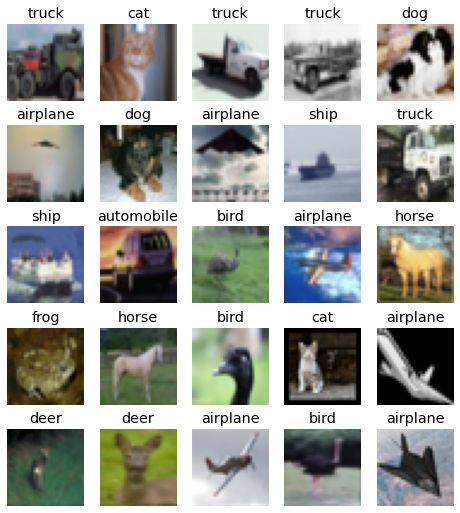

In [3]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [4]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


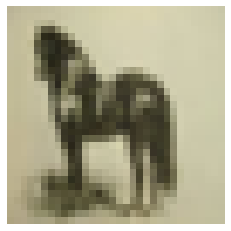

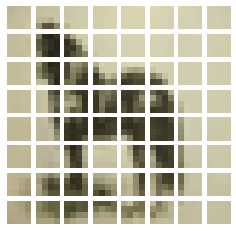

In [5]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

##CNN

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

##VIT

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) from the official keras website.

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

##LambdaNetworks

[LambdaNetworks](https://arxiv.org/abs/2102.08602) from Irwan Bello.  

The LambdaNets is based on [tfkeras.py](https://github.com/lucidrains/lambda-networks/blob/main/lambda_networks/tfkeras.py) from [lucidrains/lambda-networks](https://github.com/lucidrains/lambda-networks) and [lambda2d.py](https://github.com/g0lemXIV/LambdaNetworks/blob/main/lambda_layers/lambda2d.py) from [g0lemXIV/LambdaNetworks](https://github.com/g0lemXIV/LambdaNetworks) .  

**Good to know points from the paper**
*   The paper main introduces lambdalayer and uses it to replace the convs in ResNet to create LambdaResNet.
*   LambdaResNet achieves high accuracy but is very slow (~7x slower).
*   The main conclusion is that a hybrid model of conv + lambda has the best speed-accuracy tradeoff.
*   The best hybrid model replaces only some blocks in C4 and all the blocks in C5.




In [9]:
! pip install einops
from einops.layers.tensorflow import Rearrange

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  BatchNormalization, 
  Conv2D,
  Conv3D
)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from tensorflow import einsum, meshgrid


def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  

def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)


def calc_rel_pos(n: int):
  """Generates a relative position meshgrid.
  
  Args:
    n: Size of the original meshgrid. Size = Height = Width.

  Returns: 
    rel_pos: An array of [n*n, n*n, 2] with value range from [-n+1, n-1] to 
             [0, 2n-2].
  """
  # [2, n, n]
  pos = tf.stack(meshgrid(tf.range(n), tf.range(n), indexing = 'ij'))
  # [n*n, 2], pos[n] = (i, j)
  pos = Rearrange('n i j -> (i j) n')(pos)             
  # [n*n, n*n, 2], rel_pos[n, m] = (rel_i, rel_j)
  rel_pos = pos[None, :] - pos[:, None]                
  # shift value range from [-n+1, n-1] to [0, 2n-2]
  rel_pos += n - 1
  # [n*n, n*n, 2]                      
  return rel_pos


class Lambda(Layer):
  """Lambda Networks implementation."""

  def __init__(self,
               output_dim: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               batch_norm: bool = True,
               **kwargs):
    """Constructor

    Args:
      output_dim: Output dimension of the layer or v_dim * `num_heads`.
      k_dim: Dimension of key.
      u_dim: Intra depth for multiquery heads.
      num_heads: Number of heads for multiquery.
      n_r_size: If `local_contexts=True` n = height*width of query,
                else r = receptive field.
      local_contexts: If True lambdaconv is used, 
                      else relative position embeddings are used.
      batch_norm: Whether to apply batch norm to query and value after
                  the linear projection.

    """
    super().__init__(**kwargs)

    self.output_dim = output_dim
    self.u_dim = u_dim  # intra-depth dimension
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.batch_norm = batch_norm

    assert (self.output_dim % self.num_heads) == 0, \
      '`output_dim` must be divisible by `num_heads` for multi-head query.'
    self.v_dim = self.output_dim // self.num_heads
    self.k_dim = k_dim
    self.num_heads = num_heads

    self.to_q = Conv2D(self.k_dim * self.num_heads, 1, use_bias=self.batch_norm)
    self.to_k = Conv2D(self.k_dim * self.u_dim, 1, use_bias=self.batch_norm)
    self.to_v = Conv2D(self.v_dim * self.u_dim, 1, use_bias=self.batch_norm)

    self.norm_q = BatchNormalization() if self.batch_norm else None
    self.norm_v = BatchNormalization() if self.batch_norm else None

    if self.local_contexts:
      assert (self.n_r_size % 2) == 1, 'Receptive kernel size should be odd'
      self.pos_conv = Conv3D(self.k_dim, 
                             (1, self.n_r_size, self.n_r_size), 
                             padding='same')
    else:
      assert n is not None, 'You must specify the window length (n = h = w)'
      rel_length = 2 * self.n_r_size - 1
      self.rel_pos_emb = self.add_weight(name='pos_emb',
                                         shape=(rel_length, rel_length, 
                                                self.k_dim, self.u_dim),
                                         initializer=RandomNormal,
                                         trainable=True)
      self.rel_pos = calc_rel_pos(self.n_r_size)

  def call(self, x):
    """
    Info on the notations for reference:
    x = 2D Image data (Assumption)
    q = query
    k = key
    v = value
    h = number of heads for multiquery
    u = intradepth
    b = batch size
    hh = height of input data
    ww = width of input data
    m = height * width of key / value.
    n = height * width of query.
    """
    b, hh, ww, c, u, h = *x.get_shape().as_list(), self.u_dim, self.num_heads

    q = self.to_q(x)
    k = self.to_k(x)
    v = self.to_v(x)

    if self.batch_norm:
      q = self.norm_q(q)
      v = self.norm_v(v)

    q = Rearrange('b hh ww (h k) -> b h k (hh ww)', h=h)(q)
    k = Rearrange('b hh ww (u k) -> b u k (hh ww)', u=u)(k)
    v = Rearrange('b hh ww (u v) -> b u v (hh ww)', u=u)(v)

    k = tf.nn.softmax(k)

    Lc = einsum('b u k m, b u v m -> b k v', k, v)
    Yc = einsum('b h k n, b k v -> b n h v', q, Lc)

    if self.local_contexts:
      # lambda convs, embedding is represented by the conv kernels.
      v = Rearrange('b u v (hh ww) -> b v hh ww u', hh=hh, ww=ww)(v)
      Lp = self.pos_conv(v)
      Lp = Rearrange('b v h w k -> b v k (h w)')(Lp)
      Yp = einsum('b h k n, b v k n -> b n h v', q, Lp)
    else:
      # relative position embedding.
      rel_pos_emb = tf.gather_nd(self.rel_pos_emb, self.rel_pos)
      Lp = einsum('n m k u, b u v m -> b n k v', rel_pos_emb, v)
      Yp = einsum('b h k n, b n k v -> b n h v', q, Lp)

    Y = Yc + Yp
    out = Rearrange('b (hh ww) h v -> b hh ww (h v)', hh = hh, ww = ww)(Y)
    return out

  def get_config(self):
    return {"output_dim": self.output_dim,
            "k_dim": self.k_dim,
            "u_dim": self.u_dim,
            "num_heads": self.num_heads,
            "n_r_size": self.n_r_size,
            "local_contexts": self.local_contexts,
            "batch_norm": self.batch_norm}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class LambdaNetwork(Model):
  """LambdaNetworks implementation. """
  
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               preprocess: bool = False,
               **kwargs):
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.k_dim = k_dim
    self.u_dim = u_dim
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')

    # self.lamb3 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    # self.lamb4 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    self.lamb3 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb3')
    self.lamb4 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')

    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)

    x = self.pool4(self.lamb4(self.lamb3(x)))
    x = self.drop4(x, training=training)

    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.logits(x)

    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

# Train

Training configs.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [11]:
def train_and_eval(_model, _checkpoint_filepath, verbose=1):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.
      verbose: Option for logging output during train and eval.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
      verbose=verbose
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  return history

# Loss and accuracy plots

In [12]:
def plot(losses: list, accuracies: list, legend_labels: list, subplot_title: list):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  for x, ll in zip(losses, legend_labels):
    ax1.plot(x, label=ll)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()    
  
  for x, ll in zip(accuracies, legend_labels):
    ax2.plot(x, label=ll)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()    

  plt.show()

#Experiments

In [13]:
history = dict()

##Exp 1
Model : CNN  
Preprocessing : False  
Batch size : 256

In [14]:
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history['CNN'] = train_and_eval(model, SAVE_PATH + '_CNN', verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

##Exp 2
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [15]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history['VIT'] = train_and_eval(model, SAVE_PATH + '_VIT_4x4_2hds', verbose=2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.7253 - sparse_categorical_accuracy: 0.3645 - val_loss: 1.4874 - val_sparse_categorical_accuracy: 0.4599


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.5641 - sparse_categorical_accuracy: 0.4310 - val_loss: 1.3916 - val_sparse_categorical_accuracy: 0.4955


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.4750 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.2993 - val_sparse_categorical_accuracy: 0.5222


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.4147 - sparse_categorical_accuracy: 0.4876 - val_loss: 1.2811 - val_sparse_categorical_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.3627 - sparse_categorical_accuracy: 0.5076 - val_loss: 1.2355 - val_sparse_categorical_accuracy: 0.5585


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.3213 - sparse_categorical_accuracy: 0.5225 - val_loss: 1.1981 - val_sparse_categorical_accuracy: 0.5634


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.2813 - sparse_categorical_accuracy: 0.5393 - val_loss: 1.1543 - val_sparse_categorical_accuracy: 0.5836


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.2464 - sparse_categorical_accuracy: 0.5526 - val_loss: 1.1424 - val_sparse_categorical_accuracy: 0.5843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.2149 - sparse_categorical_accuracy: 0.5629 - val_loss: 1.1036 - val_sparse_categorical_accuracy: 0.6038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.1860 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.6068


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.1586 - sparse_categorical_accuracy: 0.5848 - val_loss: 1.0966 - val_sparse_categorical_accuracy: 0.5996
Epoch 13/50
196/196 - 5s - loss: 1.1277 - sparse_categorical_accuracy: 0.5963 - val_loss: 1.0483 - val_sparse_categorical_accuracy: 0.6254


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 14/50
196/196 - 5s - loss: 1.1036 - sparse_categorical_accuracy: 0.6043 - val_loss: 1.0416 - val_sparse_categorical_accuracy: 0.6249
Epoch 15/50
196/196 - 5s - loss: 1.0842 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.0231 - val_sparse_categorical_accuracy: 0.6329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 1.0562 - sparse_categorical_accuracy: 0.6218 - val_loss: 1.0112 - val_sparse_categorical_accuracy: 0.6329
Epoch 17/50
196/196 - 5s - loss: 1.0369 - sparse_categorical_accuracy: 0.6300 - val_loss: 1.0023 - val_sparse_categorical_accuracy: 0.6424


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 18/50
196/196 - 5s - loss: 1.0180 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.9673 - val_sparse_categorical_accuracy: 0.6498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.9918 - sparse_categorical_accuracy: 0.6448 - val_loss: 0.9672 - val_sparse_categorical_accuracy: 0.6552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.9806 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.9481 - val_sparse_categorical_accuracy: 0.6609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.9564 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.9353 - val_sparse_categorical_accuracy: 0.6668


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.9413 - sparse_categorical_accuracy: 0.6631 - val_loss: 0.9396 - val_sparse_categorical_accuracy: 0.6621
Epoch 23/50
196/196 - 5s - loss: 0.9230 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.9357 - val_sparse_categorical_accuracy: 0.6698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.9100 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.9010 - val_sparse_categorical_accuracy: 0.6790


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 25/50
196/196 - 5s - loss: 0.8899 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.9141 - val_sparse_categorical_accuracy: 0.6772
Epoch 26/50
196/196 - 5s - loss: 0.8783 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.8908 - val_sparse_categorical_accuracy: 0.6819


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.8575 - sparse_categorical_accuracy: 0.6945 - val_loss: 0.8850 - val_sparse_categorical_accuracy: 0.6896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.8509 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.8935 - val_sparse_categorical_accuracy: 0.6817
Epoch 29/50
196/196 - 5s - loss: 0.8371 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.8755 - val_sparse_categorical_accuracy: 0.6888
Epoch 30/50
196/196 - 5s - loss: 0.8202 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.6887
Epoch 31/50
196/196 - 5s - loss: 0.8024 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8591 - val_sparse_categorical_accuracy: 0.6969


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.8018 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.6928
Epoch 33/50
196/196 - 5s - loss: 0.7847 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.6992


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 34/50
196/196 - 5s - loss: 0.7764 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.6977
Epoch 35/50
196/196 - 5s - loss: 0.7626 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.8451 - val_sparse_categorical_accuracy: 0.7001


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.7480 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.8518 - val_sparse_categorical_accuracy: 0.7000
Epoch 37/50
196/196 - 5s - loss: 0.7384 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.8384 - val_sparse_categorical_accuracy: 0.7057


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.7382 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.8316 - val_sparse_categorical_accuracy: 0.7095


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.7169 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.8276 - val_sparse_categorical_accuracy: 0.7048
Epoch 40/50
196/196 - 5s - loss: 0.7098 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.7104


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 41/50
196/196 - 5s - loss: 0.7006 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.8326 - val_sparse_categorical_accuracy: 0.7048
Epoch 42/50
196/196 - 5s - loss: 0.6924 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7096
Epoch 43/50
196/196 - 5s - loss: 0.6894 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.8258 - val_sparse_categorical_accuracy: 0.7085
Epoch 44/50
196/196 - 5s - loss: 0.6670 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.8279 - val_sparse_categorical_accuracy: 0.7101
Epoch 45/50
196/196 - 5s - loss: 0.6587 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.8321 - val_sparse_categorical_accuracy: 0.7148


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.6607 - sparse_categorical_accuracy: 0.7652 - val_loss: 0.8171 - val_sparse_categorical_accuracy: 0.7135
Epoch 47/50
196/196 - 5s - loss: 0.6525 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.7136
Epoch 48/50
196/196 - 5s - loss: 0.6382 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.8050 - val_sparse_categorical_accuracy: 0.7225


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 49/50
196/196 - 5s - loss: 0.6364 - sparse_categorical_accuracy: 0.7745 - val_loss: 0.8088 - val_sparse_categorical_accuracy: 0.7178
Epoch 50/50
196/196 - 5s - loss: 0.6347 - sparse_categorical_accuracy: 0.7754 - val_loss: 0.8011 - val_sparse_categorical_accuracy: 0.7166
Total training time 473.8842170238495 seconds


##Exp 3 - X Heads, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8,16  
u dim : 1  
Heads : 1,2,4,8  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  1, 2, 4, 8,16| 2, 4, 8,16,32| 4, 8,16,32,64| 8,16,32,64,128|
K = k * u        =  1, 2, 4, 8,16| 1, 2, 4, 8,16| 1, 2, 4, 8,16| 1, 2, 4, 8, 16|
V = 64 // hd * u = 64,64,64,64,64|32,32,32,32,32|16,16,16,16,16| 8, 8, 8, 8,  8|
</pre>


In [16]:
u_dim = 1
for hds in [1,2,4,8]:
  for k_dim in [1,2,4,8,16]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=hds,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0   

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 4s - loss: 1.6111 - sparse_categorical_accuracy: 0.4115 - val_loss: 1.4479 - val_sparse_categorical_accuracy: 0.4777


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 4s - loss: 1.4285 - sparse_categorical_accuracy: 0.4836 - val_loss: 1.3005 - val_sparse_categorical_accuracy: 0.5281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 4s - loss: 1.3148 - sparse_categorical_accuracy: 0.5287 - val_loss: 1.2165 - val_sparse_categorical_accuracy: 0.5728


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 4s - loss: 1.2353 - sparse_categorical_accuracy: 0.5628 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 4s - loss: 1.1535 - sparse_categorical_accuracy: 0.5907 - val_loss: 1.0293 - val_sparse_categorical_accuracy: 0.6338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 4s - loss: 1.1045 - sparse_categorical_accuracy: 0.6107 - val_loss: 1.0067 - val_sparse_categorical_accuracy: 0.6378


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 4s - loss: 1.0715 - sparse_categorical_accuracy: 0.6216 - val_loss: 0.9585 - val_sparse_categorical_accuracy: 0.6638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 4s - loss: 1.0419 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.9294 - val_sparse_categorical_accuracy: 0.6752


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 4s - loss: 1.0081 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.8890 - val_sparse_categorical_accuracy: 0.6837


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 4s - loss: 0.9782 - sparse_categorical_accuracy: 0.6549 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.6906


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 4s - loss: 0.9668 - sparse_categorical_accuracy: 0.6597 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.6919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 4s - loss: 0.9424 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.7070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 4s - loss: 0.9247 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.8391 - val_sparse_categorical_accuracy: 0.7055
Epoch 15/50
196/196 - 4s - loss: 0.9124 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.8052 - val_sparse_categorical_accuracy: 0.7180


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 4s - loss: 0.8875 - sparse_categorical_accuracy: 0.6874 - val_loss: 0.7955 - val_sparse_categorical_accuracy: 0.7238


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 4s - loss: 0.8886 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.7832 - val_sparse_categorical_accuracy: 0.7234
Epoch 18/50
196/196 - 4s - loss: 0.8723 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.7796 - val_sparse_categorical_accuracy: 0.7305


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 4s - loss: 0.8603 - sparse_categorical_accuracy: 0.6984 - val_loss: 0.7551 - val_sparse_categorical_accuracy: 0.7412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 4s - loss: 0.8488 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.7649 - val_sparse_categorical_accuracy: 0.7353
Epoch 21/50
196/196 - 4s - loss: 0.8331 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7465


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 4s - loss: 0.8283 - sparse_categorical_accuracy: 0.7080 - val_loss: 0.7573 - val_sparse_categorical_accuracy: 0.7351
Epoch 23/50
196/196 - 4s - loss: 0.8106 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.7388
Epoch 24/50
196/196 - 4s - loss: 0.8050 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.7385 - val_sparse_categorical_accuracy: 0.7430
Epoch 25/50
196/196 - 4s - loss: 0.7960 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7290 - val_sparse_categorical_accuracy: 0.7466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 4s - loss: 0.7936 - sparse_categorical_accuracy: 0.7187 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.7530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 4s - loss: 0.7801 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.7472
Epoch 28/50
196/196 - 4s - loss: 0.7774 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.7026 - val_sparse_categorical_accuracy: 0.7557


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 29/50
196/196 - 4s - loss: 0.7700 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.7539
Epoch 30/50
196/196 - 4s - loss: 0.7591 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.6889 - val_sparse_categorical_accuracy: 0.7608


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 4s - loss: 0.7542 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.6825 - val_sparse_categorical_accuracy: 0.7602
Epoch 32/50
196/196 - 4s - loss: 0.7499 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 33/50
196/196 - 4s - loss: 0.7432 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.6983 - val_sparse_categorical_accuracy: 0.7538
Epoch 34/50
196/196 - 4s - loss: 0.7269 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7650


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 4s - loss: 0.7284 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.7623
Epoch 36/50
196/196 - 4s - loss: 0.7252 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.7625
Epoch 37/50
196/196 - 4s - loss: 0.7216 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.7700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 38/50
196/196 - 4s - loss: 0.7081 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.7692
Epoch 39/50
196/196 - 4s - loss: 0.7094 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.7703


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 4s - loss: 0.7119 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.6806 - val_sparse_categorical_accuracy: 0.7657
Epoch 41/50
196/196 - 4s - loss: 0.7020 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.7717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 4s - loss: 0.6934 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.7688
Epoch 43/50
196/196 - 4s - loss: 0.6984 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.6682 - val_sparse_categorical_accuracy: 0.7716
Epoch 44/50
196/196 - 4s - loss: 0.6831 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.6411 - val_sparse_categorical_accuracy: 0.7755


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 45/50
196/196 - 4s - loss: 0.6861 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.7747
Epoch 46/50
196/196 - 4s - loss: 0.6746 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.6541 - val_sparse_categorical_accuracy: 0.7692
Epoch 47/50
196/196 - 4s - loss: 0.6743 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.7736
Epoch 48/50
196/196 - 4s - loss: 0.6721 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.6464 - val_sparse_categorical_accuracy: 0.7809


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 4s - loss: 0.6738 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.6733 - val_sparse_categorical_accuracy: 0.7744
Epoch 50/50
196/196 - 4s - loss: 0.6654 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.6408 - val_sparse_categorical_accuracy: 0.7761
Total training time 282.2056031227112 seconds
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6111 - sparse_categorical_accuracy: 0.4128 - val_loss: 1.4590 - val_sparse_categorical_accuracy: 0.4705


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4218 - sparse_categorical_accuracy: 0.4867 - val_loss: 1.2718 - val_sparse_categorical_accuracy: 0.5441


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.2976 - sparse_categorical_accuracy: 0.5372 - val_loss: 1.1617 - val_sparse_categorical_accuracy: 0.5899


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2206 - sparse_categorical_accuracy: 0.5642 - val_loss: 1.1687 - val_sparse_categorical_accuracy: 0.5891
Epoch 6/50
196/196 - 6s - loss: 1.1596 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.0358 - val_sparse_categorical_accuracy: 0.6315


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1142 - sparse_categorical_accuracy: 0.6065 - val_loss: 1.0521 - val_sparse_categorical_accuracy: 0.6282
Epoch 8/50
196/196 - 6s - loss: 1.0829 - sparse_categorical_accuracy: 0.6164 - val_loss: 1.0119 - val_sparse_categorical_accuracy: 0.6511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0480 - sparse_categorical_accuracy: 0.6308 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.6686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0241 - sparse_categorical_accuracy: 0.6412 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.6759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9943 - sparse_categorical_accuracy: 0.6503 - val_loss: 0.8749 - val_sparse_categorical_accuracy: 0.6897


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9689 - sparse_categorical_accuracy: 0.6594 - val_loss: 0.8477 - val_sparse_categorical_accuracy: 0.7066


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9650 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.8781 - val_sparse_categorical_accuracy: 0.6971
Epoch 14/50
196/196 - 6s - loss: 0.9404 - sparse_categorical_accuracy: 0.6679 - val_loss: 0.8209 - val_sparse_categorical_accuracy: 0.7119


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9251 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.8388 - val_sparse_categorical_accuracy: 0.7086
Epoch 16/50
196/196 - 6s - loss: 0.9102 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.8479 - val_sparse_categorical_accuracy: 0.7142


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.9063 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.8631 - val_sparse_categorical_accuracy: 0.7010
Epoch 18/50
196/196 - 6s - loss: 0.8811 - sparse_categorical_accuracy: 0.6895 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.7277


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.8751 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7273
Epoch 20/50
196/196 - 6s - loss: 0.8710 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.7237
Epoch 21/50
196/196 - 6s - loss: 0.8519 - sparse_categorical_accuracy: 0.7009 - val_loss: 0.7598 - val_sparse_categorical_accuracy: 0.7328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8387 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.7240
Epoch 23/50
196/196 - 6s - loss: 0.8269 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.7595 - val_sparse_categorical_accuracy: 0.7420


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 6s - loss: 0.8209 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.7287
Epoch 25/50
196/196 - 6s - loss: 0.8089 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7397
Epoch 26/50
196/196 - 6s - loss: 0.8061 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.7545 - val_sparse_categorical_accuracy: 0.7405
Epoch 27/50
196/196 - 6s - loss: 0.8028 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7632 - val_sparse_categorical_accuracy: 0.7420
Epoch 28/50
196/196 - 6s - loss: 0.7904 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.7874 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7488 - val_sparse_categorical_accuracy: 0.7483
Epoch 30/50
196/196 - 6s - loss: 0.7733 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.7368 - val_sparse_categorical_accuracy: 0.7478
Epoch 31/50
196/196 - 6s - loss: 0.7669 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.7557


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7515 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.6929 - val_sparse_categorical_accuracy: 0.7586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7548 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.7478
Epoch 34/50
196/196 - 6s - loss: 0.7503 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.7563 - val_sparse_categorical_accuracy: 0.7553
Epoch 35/50
196/196 - 6s - loss: 0.7405 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.7085 - val_sparse_categorical_accuracy: 0.7573
Epoch 36/50
196/196 - 6s - loss: 0.7386 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.6905 - val_sparse_categorical_accuracy: 0.7649


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.7342 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7642
Epoch 38/50
196/196 - 6s - loss: 0.7290 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.7013 - val_sparse_categorical_accuracy: 0.7606
Epoch 39/50
196/196 - 6s - loss: 0.7174 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.7594
Epoch 40/50
196/196 - 6s - loss: 0.7169 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.7667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.7119 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.7594 - val_sparse_categorical_accuracy: 0.7615
Epoch 42/50
196/196 - 6s - loss: 0.7015 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.7765 - val_sparse_categorical_accuracy: 0.7614
Epoch 43/50
196/196 - 6s - loss: 0.7066 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.7096 - val_sparse_categorical_accuracy: 0.7638
Epoch 44/50
196/196 - 6s - loss: 0.6924 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.7439 - val_sparse_categorical_accuracy: 0.7603
Epoch 45/50
196/196 - 6s - loss: 0.6969 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.7569
Epoch 46/50
196/196 - 6s - loss: 0.6920 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.6834 - val_sparse_categorical_accuracy: 0.7702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 6s - loss: 0.6893 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.7739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6815 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.7265 - val_sparse_categorical_accuracy: 0.7719
Epoch 49/50
196/196 - 6s - loss: 0.6801 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.6849 - val_sparse_categorical_accuracy: 0.7675
Epoch 50/50
196/196 - 6s - loss: 0.6756 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.7633
Total training time 346.223313331604 seconds
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
___________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5760 - sparse_categorical_accuracy: 0.4278 - val_loss: 1.5106 - val_sparse_categorical_accuracy: 0.4458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3821 - sparse_categorical_accuracy: 0.5036 - val_loss: 1.3493 - val_sparse_categorical_accuracy: 0.5264


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2760 - sparse_categorical_accuracy: 0.5458 - val_loss: 1.1832 - val_sparse_categorical_accuracy: 0.5716


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.1957 - sparse_categorical_accuracy: 0.5769 - val_loss: 1.2468 - val_sparse_categorical_accuracy: 0.5576
Epoch 6/50
196/196 - 7s - loss: 1.1372 - sparse_categorical_accuracy: 0.5948 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.5729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.0993 - sparse_categorical_accuracy: 0.6110 - val_loss: 1.0315 - val_sparse_categorical_accuracy: 0.6390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0563 - sparse_categorical_accuracy: 0.6252 - val_loss: 1.0535 - val_sparse_categorical_accuracy: 0.6432


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0319 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.6650


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0043 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.6769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9845 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.9538 - val_sparse_categorical_accuracy: 0.6757
Epoch 12/50
196/196 - 7s - loss: 0.9593 - sparse_categorical_accuracy: 0.6632 - val_loss: 1.0084 - val_sparse_categorical_accuracy: 0.6557
Epoch 13/50
196/196 - 7s - loss: 0.9412 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.8946 - val_sparse_categorical_accuracy: 0.6841


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9186 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.8676 - val_sparse_categorical_accuracy: 0.6928


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.9054 - sparse_categorical_accuracy: 0.6805 - val_loss: 0.8928 - val_sparse_categorical_accuracy: 0.6943


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.8964 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.8861 - val_sparse_categorical_accuracy: 0.6986


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8715 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.8638 - val_sparse_categorical_accuracy: 0.7102


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8577 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.8678 - val_sparse_categorical_accuracy: 0.7040
Epoch 19/50
196/196 - 7s - loss: 0.8553 - sparse_categorical_accuracy: 0.7010 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8347 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.7990 - val_sparse_categorical_accuracy: 0.7232
Epoch 21/50
196/196 - 7s - loss: 0.8231 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.7587 - val_sparse_categorical_accuracy: 0.7289


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 7s - loss: 0.8095 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.7538 - val_sparse_categorical_accuracy: 0.7327


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.7989 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7781 - val_sparse_categorical_accuracy: 0.7433


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7888 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.7381
Epoch 25/50
196/196 - 7s - loss: 0.7793 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7371
Epoch 26/50
196/196 - 7s - loss: 0.7732 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.7767 - val_sparse_categorical_accuracy: 0.7305
Epoch 27/50
196/196 - 7s - loss: 0.7643 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7428
Epoch 28/50
196/196 - 7s - loss: 0.7594 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7461


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7487 - sparse_categorical_accuracy: 0.7401 - val_loss: 0.8033 - val_sparse_categorical_accuracy: 0.7427
Epoch 30/50
196/196 - 7s - loss: 0.7349 - sparse_categorical_accuracy: 0.7418 - val_loss: 0.7500 - val_sparse_categorical_accuracy: 0.7401
Epoch 31/50
196/196 - 7s - loss: 0.7293 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.8146 - val_sparse_categorical_accuracy: 0.7454
Epoch 32/50
196/196 - 7s - loss: 0.7283 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8022 - val_sparse_categorical_accuracy: 0.7459
Epoch 33/50
196/196 - 7s - loss: 0.7106 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7072 - val_sparse_categorical_accuracy: 0.7558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 7s - loss: 0.7065 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.6945 - val_sparse_categorical_accuracy: 0.7649


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 7s - loss: 0.7118 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.7551
Epoch 36/50
196/196 - 7s - loss: 0.6985 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.7606
Epoch 37/50
196/196 - 7s - loss: 0.6929 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.7507 - val_sparse_categorical_accuracy: 0.7490
Epoch 38/50
196/196 - 7s - loss: 0.6845 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.7393 - val_sparse_categorical_accuracy: 0.7591
Epoch 39/50
196/196 - 7s - loss: 0.6819 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.7635
Epoch 40/50
196/196 - 7s - loss: 0.6696 - sparse_categorical_accuracy: 0.7629 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.7642
Epoch 41/50
196/196 - 7s - loss: 0.6718 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.6855 - val_sparse_categorical_accuracy: 0.7668


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 7s - loss: 0.6656 - sparse_categorical_accuracy: 0.7684 - val_loss: 0.6903 - val_sparse_categorical_accuracy: 0.7615
Epoch 43/50
196/196 - 7s - loss: 0.6612 - sparse_categorical_accuracy: 0.7711 - val_loss: 0.7342 - val_sparse_categorical_accuracy: 0.7678


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 44/50
196/196 - 7s - loss: 0.6600 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.7841 - val_sparse_categorical_accuracy: 0.7668
Epoch 45/50
196/196 - 7s - loss: 0.6497 - sparse_categorical_accuracy: 0.7721 - val_loss: 0.6733 - val_sparse_categorical_accuracy: 0.7732


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 7s - loss: 0.6530 - sparse_categorical_accuracy: 0.7723 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7743


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 7s - loss: 0.6455 - sparse_categorical_accuracy: 0.7746 - val_loss: 0.7356 - val_sparse_categorical_accuracy: 0.7628
Epoch 48/50
196/196 - 7s - loss: 0.6332 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.7691
Epoch 49/50
196/196 - 7s - loss: 0.6403 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.6851 - val_sparse_categorical_accuracy: 0.7780


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.6299 - sparse_categorical_accuracy: 0.7789 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.7688
Total training time 411.291250705719 seconds
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5072 - sparse_categorical_accuracy: 0.4555 - val_loss: 1.4653 - val_sparse_categorical_accuracy: 0.4867


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3680 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.2904 - val_sparse_categorical_accuracy: 0.5429


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2531 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.1400 - val_sparse_categorical_accuracy: 0.5934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1876 - sparse_categorical_accuracy: 0.5799 - val_loss: 1.0900 - val_sparse_categorical_accuracy: 0.6194


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1243 - sparse_categorical_accuracy: 0.6049 - val_loss: 1.0319 - val_sparse_categorical_accuracy: 0.6340


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.0868 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.6168
Epoch 8/50
196/196 - 9s - loss: 1.0628 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.9897 - val_sparse_categorical_accuracy: 0.6625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 9s - loss: 1.0249 - sparse_categorical_accuracy: 0.6382 - val_loss: 1.0249 - val_sparse_categorical_accuracy: 0.6493
Epoch 10/50
196/196 - 9s - loss: 0.9948 - sparse_categorical_accuracy: 0.6490 - val_loss: 0.9553 - val_sparse_categorical_accuracy: 0.6662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.9757 - sparse_categorical_accuracy: 0.6594 - val_loss: 0.8973 - val_sparse_categorical_accuracy: 0.6877


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 9s - loss: 0.9516 - sparse_categorical_accuracy: 0.6656 - val_loss: 0.9198 - val_sparse_categorical_accuracy: 0.6782
Epoch 13/50
196/196 - 9s - loss: 0.9315 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.6978


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.9098 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.6831
Epoch 15/50
196/196 - 9s - loss: 0.8906 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.8330 - val_sparse_categorical_accuracy: 0.7110


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.8798 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.8051 - val_sparse_categorical_accuracy: 0.7236


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 9s - loss: 0.8663 - sparse_categorical_accuracy: 0.6951 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.7209
Epoch 18/50
196/196 - 9s - loss: 0.8535 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7283


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.8340 - sparse_categorical_accuracy: 0.7087 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.7333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 20/50
196/196 - 9s - loss: 0.8265 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.7356


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.8097 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7330
Epoch 22/50
196/196 - 9s - loss: 0.8012 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7659 - val_sparse_categorical_accuracy: 0.7371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.7977 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7288 - val_sparse_categorical_accuracy: 0.7476


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.7798 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.7494


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 9s - loss: 0.7747 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.7600 - val_sparse_categorical_accuracy: 0.7384
Epoch 26/50
196/196 - 9s - loss: 0.7725 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.7513


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 9s - loss: 0.7603 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.7271 - val_sparse_categorical_accuracy: 0.7494
Epoch 28/50
196/196 - 9s - loss: 0.7459 - sparse_categorical_accuracy: 0.7372 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.7507
Epoch 29/50
196/196 - 9s - loss: 0.7440 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.6962 - val_sparse_categorical_accuracy: 0.7595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 9s - loss: 0.7397 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.7243 - val_sparse_categorical_accuracy: 0.7528
Epoch 31/50
196/196 - 9s - loss: 0.7289 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7317 - val_sparse_categorical_accuracy: 0.7574
Epoch 32/50
196/196 - 9s - loss: 0.7268 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.7594
Epoch 33/50
196/196 - 9s - loss: 0.7164 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.7401 - val_sparse_categorical_accuracy: 0.7484
Epoch 34/50
196/196 - 9s - loss: 0.7108 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.6877 - val_sparse_categorical_accuracy: 0.7660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 9s - loss: 0.7016 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.6822 - val_sparse_categorical_accuracy: 0.7620
Epoch 36/50
196/196 - 9s - loss: 0.6936 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.7538
Epoch 37/50
196/196 - 9s - loss: 0.6898 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.7579
Epoch 38/50
196/196 - 9s - loss: 0.6872 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.7735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 9s - loss: 0.6846 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.7337 - val_sparse_categorical_accuracy: 0.7643
Epoch 40/50
196/196 - 9s - loss: 0.6808 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.6824 - val_sparse_categorical_accuracy: 0.7739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 9s - loss: 0.6695 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.7756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 9s - loss: 0.6706 - sparse_categorical_accuracy: 0.7651 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.7551
Epoch 43/50
196/196 - 9s - loss: 0.6613 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.7680
Epoch 44/50
196/196 - 9s - loss: 0.6599 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.7527 - val_sparse_categorical_accuracy: 0.7716
Epoch 45/50
196/196 - 9s - loss: 0.6533 - sparse_categorical_accuracy: 0.7701 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.7713
Epoch 46/50
196/196 - 9s - loss: 0.6442 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.6893 - val_sparse_categorical_accuracy: 0.7690
Epoch 47/50
196/196 - 9s - loss: 0.6443 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.7752
Epoch 48/50
196/196 - 9s - loss: 0.6388 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.6788 - val_sparse_categorical_accuracy: 0.7795


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 9s - loss: 0.6341 - sparse_categorical_accuracy: 0.7769 - val_loss: 0.6966 - val_sparse_categorical_accuracy: 0.7806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 9s - loss: 0.6288 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7786
Total training time 515.2261667251587 seconds
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 13s - loss: 1.5480 - sparse_categorical_accuracy: 0.4353 - val_loss: 1.5535 - val_sparse_categorical_accuracy: 0.4428


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 13s - loss: 1.3704 - sparse_categorical_accuracy: 0.5122 - val_loss: 1.2318 - val_sparse_categorical_accuracy: 0.5532


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 13s - loss: 1.2526 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.2603 - val_sparse_categorical_accuracy: 0.5537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 13s - loss: 1.1759 - sparse_categorical_accuracy: 0.5867 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.6064


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 13s - loss: 1.1255 - sparse_categorical_accuracy: 0.6031 - val_loss: 1.0523 - val_sparse_categorical_accuracy: 0.6323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 13s - loss: 1.0802 - sparse_categorical_accuracy: 0.6203 - val_loss: 1.0512 - val_sparse_categorical_accuracy: 0.6448


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 13s - loss: 1.0434 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.9839 - val_sparse_categorical_accuracy: 0.6614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 13s - loss: 1.0166 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.9281 - val_sparse_categorical_accuracy: 0.6748


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 13s - loss: 0.9775 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.9088 - val_sparse_categorical_accuracy: 0.6844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 13s - loss: 0.9641 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.9180 - val_sparse_categorical_accuracy: 0.6833
Epoch 12/50
196/196 - 13s - loss: 0.9399 - sparse_categorical_accuracy: 0.6687 - val_loss: 0.8544 - val_sparse_categorical_accuracy: 0.7042


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 13s - loss: 0.9172 - sparse_categorical_accuracy: 0.6798 - val_loss: 0.8590 - val_sparse_categorical_accuracy: 0.7026
Epoch 14/50
196/196 - 13s - loss: 0.8990 - sparse_categorical_accuracy: 0.6863 - val_loss: 0.8701 - val_sparse_categorical_accuracy: 0.7044


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 13s - loss: 0.8825 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.8071 - val_sparse_categorical_accuracy: 0.7188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 13s - loss: 0.8702 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.7749 - val_sparse_categorical_accuracy: 0.7297


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 13s - loss: 0.8455 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.7757 - val_sparse_categorical_accuracy: 0.7314


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 13s - loss: 0.8385 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.7287
Epoch 19/50
196/196 - 13s - loss: 0.8247 - sparse_categorical_accuracy: 0.7110 - val_loss: 0.8043 - val_sparse_categorical_accuracy: 0.7300
Epoch 20/50
196/196 - 13s - loss: 0.8244 - sparse_categorical_accuracy: 0.7109 - val_loss: 0.8164 - val_sparse_categorical_accuracy: 0.7230
Epoch 21/50
196/196 - 13s - loss: 0.8043 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.8824 - val_sparse_categorical_accuracy: 0.7312
Epoch 22/50
196/196 - 13s - loss: 0.7963 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.8707 - val_sparse_categorical_accuracy: 0.7162
Epoch 23/50
196/196 - 13s - loss: 0.7901 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.7486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 13s - loss: 0.7745 - sparse_categorical_accuracy: 0.7290 - val_loss: 0.7616 - val_sparse_categorical_accuracy: 0.7461
Epoch 25/50
196/196 - 13s - loss: 0.7753 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.7498 - val_sparse_categorical_accuracy: 0.7472
Epoch 26/50
196/196 - 13s - loss: 0.7630 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.7425
Epoch 27/50
196/196 - 13s - loss: 0.7432 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 13s - loss: 0.7468 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.8422 - val_sparse_categorical_accuracy: 0.7360
Epoch 29/50
196/196 - 13s - loss: 0.7389 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.7332
Epoch 30/50
196/196 - 13s - loss: 0.7341 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7672 - val_sparse_categorical_accuracy: 0.7521
Epoch 31/50
196/196 - 13s - loss: 0.7295 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.7588


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 32/50
196/196 - 13s - loss: 0.7163 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.7870 - val_sparse_categorical_accuracy: 0.7529
Epoch 33/50
196/196 - 13s - loss: 0.7162 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.8346 - val_sparse_categorical_accuracy: 0.7535
Epoch 34/50
196/196 - 13s - loss: 0.7060 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.7685


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 13s - loss: 0.7027 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.7597
Epoch 36/50
196/196 - 13s - loss: 0.6998 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.7607
Epoch 37/50
196/196 - 13s - loss: 0.6928 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.7604
Epoch 38/50
196/196 - 13s - loss: 0.6889 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.6942 - val_sparse_categorical_accuracy: 0.7626
Epoch 39/50
196/196 - 13s - loss: 0.6814 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.7514 - val_sparse_categorical_accuracy: 0.7664
Epoch 40/50
196/196 - 13s - loss: 0.6778 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 13s - loss: 0.6744 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.7541 - val_sparse_categorical_accuracy: 0.7654
Epoch 42/50
196/196 - 13s - loss: 0.6656 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.7077 - val_sparse_categorical_accuracy: 0.7638
Epoch 43/50
196/196 - 13s - loss: 0.6586 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.7674
Epoch 44/50
196/196 - 13s - loss: 0.6576 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7541
Epoch 45/50
196/196 - 13s - loss: 0.6588 - sparse_categorical_accuracy: 0.7689 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.7714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 13s - loss: 0.6517 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.6685 - val_sparse_categorical_accuracy: 0.7730


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 13s - loss: 0.6465 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.6792 - val_sparse_categorical_accuracy: 0.7701
Epoch 48/50
196/196 - 13s - loss: 0.6476 - sparse_categorical_accuracy: 0.7737 - val_loss: 0.7229 - val_sparse_categorical_accuracy: 0.7739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 13s - loss: 0.6363 - sparse_categorical_accuracy: 0.7769 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.7760


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 13s - loss: 0.6306 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.7271 - val_sparse_categorical_accuracy: 0.7709
Total training time 711.5299875736237 seconds
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 3s - loss: 1.6677 - sparse_categorical_accuracy: 0.3903 - val_loss: 1.5604 - val_sparse_categorical_accuracy: 0.4307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 3s - loss: 1.5082 - sparse_categorical_accuracy: 0.4526 - val_loss: 1.4565 - val_sparse_categorical_accuracy: 0.4810


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 3s - loss: 1.4073 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.2984 - val_sparse_categorical_accuracy: 0.5296


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 3s - loss: 1.3320 - sparse_categorical_accuracy: 0.5212 - val_loss: 1.3817 - val_sparse_categorical_accuracy: 0.5223
Epoch 6/50
196/196 - 3s - loss: 1.2834 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.1922 - val_sparse_categorical_accuracy: 0.5756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 3s - loss: 1.2285 - sparse_categorical_accuracy: 0.5634 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.5993


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 3s - loss: 1.1875 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.1717 - val_sparse_categorical_accuracy: 0.5755
Epoch 9/50
196/196 - 3s - loss: 1.1566 - sparse_categorical_accuracy: 0.5905 - val_loss: 1.1619 - val_sparse_categorical_accuracy: 0.6000


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 3s - loss: 1.1315 - sparse_categorical_accuracy: 0.5998 - val_loss: 1.0534 - val_sparse_categorical_accuracy: 0.6265


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 3s - loss: 1.1018 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.9972 - val_sparse_categorical_accuracy: 0.6455


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 4s - loss: 1.0730 - sparse_categorical_accuracy: 0.6170 - val_loss: 0.9999 - val_sparse_categorical_accuracy: 0.6465


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 3s - loss: 1.0613 - sparse_categorical_accuracy: 0.6224 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.6534


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 3s - loss: 1.0431 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.9727 - val_sparse_categorical_accuracy: 0.6513
Epoch 15/50
196/196 - 3s - loss: 1.0195 - sparse_categorical_accuracy: 0.6382 - val_loss: 0.9405 - val_sparse_categorical_accuracy: 0.6687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 4s - loss: 1.0020 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.9416 - val_sparse_categorical_accuracy: 0.6702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 3s - loss: 0.9843 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.9202 - val_sparse_categorical_accuracy: 0.6764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 4s - loss: 0.9745 - sparse_categorical_accuracy: 0.6548 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.6674
Epoch 19/50
196/196 - 3s - loss: 0.9707 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.8717 - val_sparse_categorical_accuracy: 0.6933


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 4s - loss: 0.9422 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.8794 - val_sparse_categorical_accuracy: 0.6932
Epoch 21/50
196/196 - 3s - loss: 0.9390 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.6865
Epoch 22/50
196/196 - 4s - loss: 0.9282 - sparse_categorical_accuracy: 0.6685 - val_loss: 0.8607 - val_sparse_categorical_accuracy: 0.6932
Epoch 23/50
196/196 - 4s - loss: 0.9235 - sparse_categorical_accuracy: 0.6705 - val_loss: 0.8683 - val_sparse_categorical_accuracy: 0.6863
Epoch 24/50
196/196 - 3s - loss: 0.9096 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.8460 - val_sparse_categorical_accuracy: 0.6978


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 25/50
196/196 - 4s - loss: 0.9054 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.8520 - val_sparse_categorical_accuracy: 0.6990


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 4s - loss: 0.8826 - sparse_categorical_accuracy: 0.6848 - val_loss: 0.8369 - val_sparse_categorical_accuracy: 0.7046


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 3s - loss: 0.8821 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.8153 - val_sparse_categorical_accuracy: 0.7105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 28/50
196/196 - 3s - loss: 0.8782 - sparse_categorical_accuracy: 0.6870 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.7133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 4s - loss: 0.8653 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7107
Epoch 30/50
196/196 - 3s - loss: 0.8511 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 3s - loss: 0.8545 - sparse_categorical_accuracy: 0.6970 - val_loss: 0.8050 - val_sparse_categorical_accuracy: 0.7156
Epoch 32/50
196/196 - 3s - loss: 0.8457 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.7801 - val_sparse_categorical_accuracy: 0.7226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 4s - loss: 0.8375 - sparse_categorical_accuracy: 0.7002 - val_loss: 0.7992 - val_sparse_categorical_accuracy: 0.7197
Epoch 34/50
196/196 - 3s - loss: 0.8373 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.8249 - val_sparse_categorical_accuracy: 0.7109
Epoch 35/50
196/196 - 4s - loss: 0.8310 - sparse_categorical_accuracy: 0.7052 - val_loss: 0.7847 - val_sparse_categorical_accuracy: 0.7206
Epoch 36/50
196/196 - 3s - loss: 0.8267 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.7916 - val_sparse_categorical_accuracy: 0.7169
Epoch 37/50
196/196 - 3s - loss: 0.8156 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.7819 - val_sparse_categorical_accuracy: 0.7252


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 38/50
196/196 - 3s - loss: 0.8106 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.7824 - val_sparse_categorical_accuracy: 0.7237
Epoch 39/50
196/196 - 3s - loss: 0.8123 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.7265


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 40/50
196/196 - 4s - loss: 0.8025 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.7240
Epoch 41/50
196/196 - 3s - loss: 0.7915 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.7269


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 42/50
196/196 - 3s - loss: 0.7964 - sparse_categorical_accuracy: 0.7166 - val_loss: 0.7670 - val_sparse_categorical_accuracy: 0.7368


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 43/50
196/196 - 3s - loss: 0.7933 - sparse_categorical_accuracy: 0.7168 - val_loss: 0.7653 - val_sparse_categorical_accuracy: 0.7293
Epoch 44/50
196/196 - 3s - loss: 0.7810 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7455 - val_sparse_categorical_accuracy: 0.7377


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 45/50
196/196 - 4s - loss: 0.7776 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7685 - val_sparse_categorical_accuracy: 0.7306
Epoch 46/50
196/196 - 3s - loss: 0.7793 - sparse_categorical_accuracy: 0.7202 - val_loss: 0.7496 - val_sparse_categorical_accuracy: 0.7363
Epoch 47/50
196/196 - 4s - loss: 0.7666 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.7398


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 48/50
196/196 - 3s - loss: 0.7658 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.7460 - val_sparse_categorical_accuracy: 0.7348
Epoch 49/50
196/196 - 4s - loss: 0.7604 - sparse_categorical_accuracy: 0.7276 - val_loss: 0.7341 - val_sparse_categorical_accuracy: 0.7401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 50/50
196/196 - 3s - loss: 0.7660 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.7527 - val_sparse_categorical_accuracy: 0.7366
Total training time 253.0354950428009 seconds
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6353 - sparse_categorical_accuracy: 0.3989 - val_loss: 1.6329 - val_sparse_categorical_accuracy: 0.4158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4799 - sparse_categorical_accuracy: 0.4641 - val_loss: 1.4730 - val_sparse_categorical_accuracy: 0.4677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3765 - sparse_categorical_accuracy: 0.5030 - val_loss: 1.3079 - val_sparse_categorical_accuracy: 0.5333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2897 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.2578 - val_sparse_categorical_accuracy: 0.5592


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.2170 - sparse_categorical_accuracy: 0.5695 - val_loss: 1.2712 - val_sparse_categorical_accuracy: 0.5516
Epoch 7/50
196/196 - 5s - loss: 1.1706 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.3334 - val_sparse_categorical_accuracy: 0.5472
Epoch 8/50
196/196 - 5s - loss: 1.1362 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.0946 - val_sparse_categorical_accuracy: 0.6109


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0981 - sparse_categorical_accuracy: 0.6106 - val_loss: 1.1275 - val_sparse_categorical_accuracy: 0.6106
Epoch 10/50
196/196 - 5s - loss: 1.0702 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.0134 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.0431 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.0177 - val_sparse_categorical_accuracy: 0.6447


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.0192 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.9839 - val_sparse_categorical_accuracy: 0.6571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9936 - sparse_categorical_accuracy: 0.6462 - val_loss: 1.0257 - val_sparse_categorical_accuracy: 0.6471
Epoch 14/50
196/196 - 5s - loss: 0.9755 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.6681


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9627 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9362 - val_sparse_categorical_accuracy: 0.6704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.9421 - sparse_categorical_accuracy: 0.6669 - val_loss: 0.9039 - val_sparse_categorical_accuracy: 0.6802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.9247 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.8973 - val_sparse_categorical_accuracy: 0.6838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.9112 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.6812
Epoch 19/50
196/196 - 5s - loss: 0.8919 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.9232 - val_sparse_categorical_accuracy: 0.6767
Epoch 20/50
196/196 - 5s - loss: 0.8805 - sparse_categorical_accuracy: 0.6871 - val_loss: 0.8836 - val_sparse_categorical_accuracy: 0.6882


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8639 - sparse_categorical_accuracy: 0.6931 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.7134


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.8562 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.8637 - val_sparse_categorical_accuracy: 0.7012
Epoch 23/50
196/196 - 5s - loss: 0.8411 - sparse_categorical_accuracy: 0.7016 - val_loss: 0.9017 - val_sparse_categorical_accuracy: 0.6978
Epoch 24/50
196/196 - 5s - loss: 0.8286 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.8764 - val_sparse_categorical_accuracy: 0.6995
Epoch 25/50
196/196 - 5s - loss: 0.8207 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.7033
Epoch 26/50
196/196 - 5s - loss: 0.8081 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7922 - val_sparse_categorical_accuracy: 0.7346


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.7971 - sparse_categorical_accuracy: 0.7173 - val_loss: 0.8153 - val_sparse_categorical_accuracy: 0.7147
Epoch 28/50
196/196 - 5s - loss: 0.7858 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7846 - val_sparse_categorical_accuracy: 0.7257
Epoch 29/50
196/196 - 5s - loss: 0.7778 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.8334 - val_sparse_categorical_accuracy: 0.7152
Epoch 30/50
196/196 - 5s - loss: 0.7659 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.8041 - val_sparse_categorical_accuracy: 0.7264
Epoch 31/50
196/196 - 5s - loss: 0.7623 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.7722 - val_sparse_categorical_accuracy: 0.7351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7506 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.7617 - val_sparse_categorical_accuracy: 0.7407


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7432 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.7356
Epoch 34/50
196/196 - 5s - loss: 0.7350 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7955 - val_sparse_categorical_accuracy: 0.7359
Epoch 35/50
196/196 - 5s - loss: 0.7316 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.7941 - val_sparse_categorical_accuracy: 0.7394
Epoch 36/50
196/196 - 5s - loss: 0.7189 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.8625 - val_sparse_categorical_accuracy: 0.7307
Epoch 37/50
196/196 - 5s - loss: 0.7195 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.8045 - val_sparse_categorical_accuracy: 0.7382
Epoch 38/50
196/196 - 5s - loss: 0.7125 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7507 - val_sparse_categorical_accuracy: 0.7466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.7038 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.7460 - val_sparse_categorical_accuracy: 0.7463
Epoch 40/50
196/196 - 5s - loss: 0.6871 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.8502 - val_sparse_categorical_accuracy: 0.7316
Epoch 41/50
196/196 - 5s - loss: 0.6903 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.8034 - val_sparse_categorical_accuracy: 0.7327
Epoch 42/50
196/196 - 5s - loss: 0.6845 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.7697 - val_sparse_categorical_accuracy: 0.7434
Epoch 43/50
196/196 - 5s - loss: 0.6729 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.7650 - val_sparse_categorical_accuracy: 0.7493


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 44/50
196/196 - 5s - loss: 0.6792 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.7946 - val_sparse_categorical_accuracy: 0.7504


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 45/50
196/196 - 5s - loss: 0.6701 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7569


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.6614 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.7588


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.6558 - sparse_categorical_accuracy: 0.7674 - val_loss: 0.7238 - val_sparse_categorical_accuracy: 0.7636


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 48/50
196/196 - 5s - loss: 0.6486 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.7499 - val_sparse_categorical_accuracy: 0.7602
Epoch 49/50
196/196 - 5s - loss: 0.6511 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.6830 - val_sparse_categorical_accuracy: 0.7660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 50/50
196/196 - 5s - loss: 0.6433 - sparse_categorical_accuracy: 0.7713 - val_loss: 0.7602 - val_sparse_categorical_accuracy: 0.7581
Total training time 300.79076075553894 seconds
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5279 - sparse_categorical_accuracy: 0.4441 - val_loss: 1.4399 - val_sparse_categorical_accuracy: 0.4783


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.3580 - sparse_categorical_accuracy: 0.5140 - val_loss: 1.2619 - val_sparse_categorical_accuracy: 0.5410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.2508 - sparse_categorical_accuracy: 0.5558 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.5605


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.1862 - sparse_categorical_accuracy: 0.5788 - val_loss: 1.1266 - val_sparse_categorical_accuracy: 0.5935


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1242 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.6273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.0913 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.0609 - val_sparse_categorical_accuracy: 0.6221
Epoch 8/50
196/196 - 5s - loss: 1.0527 - sparse_categorical_accuracy: 0.6291 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.6321


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0338 - sparse_categorical_accuracy: 0.6348 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.6531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0046 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.9565 - val_sparse_categorical_accuracy: 0.6584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 0.9887 - sparse_categorical_accuracy: 0.6493 - val_loss: 0.9294 - val_sparse_categorical_accuracy: 0.6773


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.9657 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.9490 - val_sparse_categorical_accuracy: 0.6658
Epoch 13/50
196/196 - 5s - loss: 0.9416 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.9393 - val_sparse_categorical_accuracy: 0.6668
Epoch 14/50
196/196 - 5s - loss: 0.9315 - sparse_categorical_accuracy: 0.6727 - val_loss: 0.9112 - val_sparse_categorical_accuracy: 0.6802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9080 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.9304 - val_sparse_categorical_accuracy: 0.6863


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.8984 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.8820 - val_sparse_categorical_accuracy: 0.6972


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.8771 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.8771 - val_sparse_categorical_accuracy: 0.7045


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.8593 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.9149 - val_sparse_categorical_accuracy: 0.6985
Epoch 19/50
196/196 - 5s - loss: 0.8537 - sparse_categorical_accuracy: 0.6991 - val_loss: 0.8621 - val_sparse_categorical_accuracy: 0.7076


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.8362 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.7140


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8257 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.8450 - val_sparse_categorical_accuracy: 0.7122
Epoch 22/50
196/196 - 5s - loss: 0.8154 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.8503 - val_sparse_categorical_accuracy: 0.7171


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.7978 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8003 - val_sparse_categorical_accuracy: 0.7311


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.7885 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.8053 - val_sparse_categorical_accuracy: 0.7189
Epoch 25/50
196/196 - 5s - loss: 0.7856 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.7704 - sparse_categorical_accuracy: 0.7288 - val_loss: 0.7799 - val_sparse_categorical_accuracy: 0.7350


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.7616 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.9142 - val_sparse_categorical_accuracy: 0.7148
Epoch 28/50
196/196 - 5s - loss: 0.7596 - sparse_categorical_accuracy: 0.7342 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7380


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.7433 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.8350 - val_sparse_categorical_accuracy: 0.7299
Epoch 30/50
196/196 - 5s - loss: 0.7370 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.7504 - val_sparse_categorical_accuracy: 0.7439


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.7286 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8105 - val_sparse_categorical_accuracy: 0.7437
Epoch 32/50
196/196 - 5s - loss: 0.7228 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7723 - val_sparse_categorical_accuracy: 0.7372
Epoch 33/50
196/196 - 5s - loss: 0.7076 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.8073 - val_sparse_categorical_accuracy: 0.7459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 34/50
196/196 - 5s - loss: 0.7078 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.7756 - val_sparse_categorical_accuracy: 0.7473


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.6987 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.8583 - val_sparse_categorical_accuracy: 0.7336
Epoch 36/50
196/196 - 5s - loss: 0.6937 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.7401 - val_sparse_categorical_accuracy: 0.7527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 5s - loss: 0.6876 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7495
Epoch 38/50
196/196 - 5s - loss: 0.6856 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.8679 - val_sparse_categorical_accuracy: 0.7434
Epoch 39/50
196/196 - 5s - loss: 0.6782 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.7552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 40/50
196/196 - 5s - loss: 0.6703 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.7622 - val_sparse_categorical_accuracy: 0.7514
Epoch 41/50
196/196 - 5s - loss: 0.6593 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.7563 - val_sparse_categorical_accuracy: 0.7561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 42/50
196/196 - 5s - loss: 0.6583 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.7598


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 43/50
196/196 - 5s - loss: 0.6520 - sparse_categorical_accuracy: 0.7689 - val_loss: 0.8438 - val_sparse_categorical_accuracy: 0.7530
Epoch 44/50
196/196 - 5s - loss: 0.6447 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.7484 - val_sparse_categorical_accuracy: 0.7551
Epoch 45/50
196/196 - 5s - loss: 0.6448 - sparse_categorical_accuracy: 0.7757 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7622


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.6395 - sparse_categorical_accuracy: 0.7721 - val_loss: 0.8965 - val_sparse_categorical_accuracy: 0.7495
Epoch 47/50
196/196 - 5s - loss: 0.6385 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7611
Epoch 48/50
196/196 - 5s - loss: 0.6210 - sparse_categorical_accuracy: 0.7791 - val_loss: 0.8352 - val_sparse_categorical_accuracy: 0.7432
Epoch 49/50
196/196 - 5s - loss: 0.6256 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.7569
Epoch 50/50
196/196 - 5s - loss: 0.6190 - sparse_categorical_accuracy: 0.7821 - val_loss: 0.7898 - val_sparse_categorical_accuracy: 0.7558
Total training time 342.42434763908386 seconds
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
__________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6184 - sparse_categorical_accuracy: 0.4060 - val_loss: 1.6801 - val_sparse_categorical_accuracy: 0.3982


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4613 - sparse_categorical_accuracy: 0.4748 - val_loss: 1.5071 - val_sparse_categorical_accuracy: 0.4563


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3481 - sparse_categorical_accuracy: 0.5182 - val_loss: 1.3044 - val_sparse_categorical_accuracy: 0.5288


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2539 - sparse_categorical_accuracy: 0.5524 - val_loss: 1.2885 - val_sparse_categorical_accuracy: 0.5452


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1810 - sparse_categorical_accuracy: 0.5818 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.5896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1253 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.2662 - val_sparse_categorical_accuracy: 0.5824
Epoch 8/50
196/196 - 6s - loss: 1.0870 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.0715 - val_sparse_categorical_accuracy: 0.6213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0449 - sparse_categorical_accuracy: 0.6288 - val_loss: 1.1167 - val_sparse_categorical_accuracy: 0.6114
Epoch 10/50
196/196 - 6s - loss: 1.0179 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.6595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 6s - loss: 1.0011 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.9916 - val_sparse_categorical_accuracy: 0.6501
Epoch 12/50
196/196 - 6s - loss: 0.9680 - sparse_categorical_accuracy: 0.6574 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.6759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9485 - sparse_categorical_accuracy: 0.6659 - val_loss: 0.8916 - val_sparse_categorical_accuracy: 0.6830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9310 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.9455 - val_sparse_categorical_accuracy: 0.6841


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9167 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.9358 - val_sparse_categorical_accuracy: 0.6837
Epoch 16/50
196/196 - 6s - loss: 0.8969 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.9482 - val_sparse_categorical_accuracy: 0.6817
Epoch 17/50
196/196 - 6s - loss: 0.8810 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.8569 - val_sparse_categorical_accuracy: 0.6983


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8685 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.8688 - val_sparse_categorical_accuracy: 0.6945
Epoch 19/50
196/196 - 6s - loss: 0.8505 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.9298 - val_sparse_categorical_accuracy: 0.6904
Epoch 20/50
196/196 - 6s - loss: 0.8455 - sparse_categorical_accuracy: 0.7030 - val_loss: 0.9247 - val_sparse_categorical_accuracy: 0.6863
Epoch 21/50
196/196 - 6s - loss: 0.8284 - sparse_categorical_accuracy: 0.7078 - val_loss: 0.8176 - val_sparse_categorical_accuracy: 0.7141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8216 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.7198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8046 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.8142 - val_sparse_categorical_accuracy: 0.7256


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 24/50
196/196 - 6s - loss: 0.8046 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.8012 - val_sparse_categorical_accuracy: 0.7211
Epoch 25/50
196/196 - 6s - loss: 0.7973 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.7052
Epoch 26/50
196/196 - 6s - loss: 0.7842 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7261 - val_sparse_categorical_accuracy: 0.7438


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.7789 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.8286 - val_sparse_categorical_accuracy: 0.7288
Epoch 28/50
196/196 - 6s - loss: 0.7716 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7358
Epoch 29/50
196/196 - 6s - loss: 0.7640 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.7702 - val_sparse_categorical_accuracy: 0.7335
Epoch 30/50
196/196 - 6s - loss: 0.7542 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.7792 - val_sparse_categorical_accuracy: 0.7346
Epoch 31/50
196/196 - 6s - loss: 0.7510 - sparse_categorical_accuracy: 0.7342 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.7406
Epoch 32/50
196/196 - 6s - loss: 0.7535 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.8330 - val_sparse_categorical_accuracy: 0.7302
Epoch 33/50
196/196 - 6s - loss: 0.7374 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.7710 - val_sparse_categorical_accuracy: 0.7389
Epoch 34/50
196/196 - 6s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.7187 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.7571 - val_sparse_categorical_accuracy: 0.7487
Epoch 38/50
196/196 - 6s - loss: 0.7124 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.7614 - val_sparse_categorical_accuracy: 0.7461
Epoch 39/50
196/196 - 6s - loss: 0.7107 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.7458
Epoch 40/50
196/196 - 6s - loss: 0.7014 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.7896 - val_sparse_categorical_accuracy: 0.7538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.7020 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.7835 - val_sparse_categorical_accuracy: 0.7462
Epoch 42/50
196/196 - 6s - loss: 0.6881 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.7568


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.6924 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.7555
Epoch 44/50
196/196 - 6s - loss: 0.6817 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.7277 - val_sparse_categorical_accuracy: 0.7566
Epoch 45/50
196/196 - 6s - loss: 0.6817 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.8410 - val_sparse_categorical_accuracy: 0.7393
Epoch 46/50
196/196 - 6s - loss: 0.6763 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.7342 - val_sparse_categorical_accuracy: 0.7640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 47/50
196/196 - 6s - loss: 0.6825 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.8017 - val_sparse_categorical_accuracy: 0.7473
Epoch 48/50
196/196 - 6s - loss: 0.6660 - sparse_categorical_accuracy: 0.7640 - val_loss: 0.7393 - val_sparse_categorical_accuracy: 0.7562
Epoch 49/50
196/196 - 6s - loss: 0.6690 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.7655 - val_sparse_categorical_accuracy: 0.7586
Epoch 50/50
196/196 - 6s - loss: 0.6678 - sparse_categorical_accuracy: 0.7642 - val_loss: 0.8350 - val_sparse_categorical_accuracy: 0.7403
Total training time 373.11900997161865 seconds
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5276 - sparse_categorical_accuracy: 0.4461 - val_loss: 1.3807 - val_sparse_categorical_accuracy: 0.4872


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3326 - sparse_categorical_accuracy: 0.5220 - val_loss: 1.3448 - val_sparse_categorical_accuracy: 0.5211


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2293 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.2432 - val_sparse_categorical_accuracy: 0.5675


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1538 - sparse_categorical_accuracy: 0.5901 - val_loss: 1.0615 - val_sparse_categorical_accuracy: 0.6257


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.0980 - sparse_categorical_accuracy: 0.6118 - val_loss: 1.0331 - val_sparse_categorical_accuracy: 0.6363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.0486 - sparse_categorical_accuracy: 0.6293 - val_loss: 0.9973 - val_sparse_categorical_accuracy: 0.6510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.0097 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.9666 - val_sparse_categorical_accuracy: 0.6624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 0.9818 - sparse_categorical_accuracy: 0.6563 - val_loss: 0.9151 - val_sparse_categorical_accuracy: 0.6806


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 9s - loss: 0.9503 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.9425 - val_sparse_categorical_accuracy: 0.6706
Epoch 11/50
196/196 - 9s - loss: 0.9238 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.8766 - val_sparse_categorical_accuracy: 0.6975


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 9s - loss: 0.9021 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.9220 - val_sparse_categorical_accuracy: 0.6881
Epoch 13/50
196/196 - 9s - loss: 0.8777 - sparse_categorical_accuracy: 0.6939 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.8517 - sparse_categorical_accuracy: 0.7010 - val_loss: 0.8758 - val_sparse_categorical_accuracy: 0.7131
Epoch 15/50
196/196 - 9s - loss: 0.8271 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.8541 - val_sparse_categorical_accuracy: 0.7146


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.8217 - sparse_categorical_accuracy: 0.7114 - val_loss: 0.8336 - val_sparse_categorical_accuracy: 0.7266


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 9s - loss: 0.8021 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.7231
Epoch 18/50
196/196 - 9s - loss: 0.7856 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.7865 - val_sparse_categorical_accuracy: 0.7335


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.7700 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7439


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 9s - loss: 0.7532 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.8307 - val_sparse_categorical_accuracy: 0.7286
Epoch 21/50
196/196 - 9s - loss: 0.7478 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.8124 - val_sparse_categorical_accuracy: 0.7254
Epoch 22/50
196/196 - 9s - loss: 0.7350 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.7508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.7239 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.7550 - val_sparse_categorical_accuracy: 0.7493
Epoch 24/50
196/196 - 9s - loss: 0.7061 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7402
Epoch 25/50
196/196 - 9s - loss: 0.7041 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7598


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.6866 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.7616


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 9s - loss: 0.6799 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.8310 - val_sparse_categorical_accuracy: 0.7580
Epoch 28/50
196/196 - 9s - loss: 0.6720 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7398
Epoch 29/50
196/196 - 9s - loss: 0.6654 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.7585
Epoch 30/50
196/196 - 9s - loss: 0.6543 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.7244 - val_sparse_categorical_accuracy: 0.7632


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.6575 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.7447
Epoch 32/50
196/196 - 9s - loss: 0.6416 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.8244 - val_sparse_categorical_accuracy: 0.7598
Epoch 33/50
196/196 - 9s - loss: 0.6344 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.7196 - val_sparse_categorical_accuracy: 0.7627
Epoch 34/50
196/196 - 9s - loss: 0.6289 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.7966 - val_sparse_categorical_accuracy: 0.7676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 35/50
196/196 - 9s - loss: 0.6319 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7582
Epoch 36/50
196/196 - 9s - loss: 0.6216 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.8100 - val_sparse_categorical_accuracy: 0.7614
Epoch 37/50
196/196 - 9s - loss: 0.6080 - sparse_categorical_accuracy: 0.7853 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.7666
Epoch 38/50
196/196 - 9s - loss: 0.6058 - sparse_categorical_accuracy: 0.7857 - val_loss: 0.7290 - val_sparse_categorical_accuracy: 0.7759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 9s - loss: 0.5937 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.8750 - val_sparse_categorical_accuracy: 0.7498
Epoch 40/50
196/196 - 9s - loss: 0.5994 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.6851 - val_sparse_categorical_accuracy: 0.7776


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 9s - loss: 0.5897 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.7702
Epoch 42/50
196/196 - 9s - loss: 0.5810 - sparse_categorical_accuracy: 0.7955 - val_loss: 0.8080 - val_sparse_categorical_accuracy: 0.7612
Epoch 43/50
196/196 - 9s - loss: 0.5768 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.6629 - val_sparse_categorical_accuracy: 0.7750
Epoch 44/50
196/196 - 9s - loss: 0.5780 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.8339 - val_sparse_categorical_accuracy: 0.7721
Epoch 45/50
196/196 - 9s - loss: 0.5751 - sparse_categorical_accuracy: 0.7986 - val_loss: 0.7470 - val_sparse_categorical_accuracy: 0.7701
Epoch 46/50
196/196 - 9s - loss: 0.5613 - sparse_categorical_accuracy: 0.7997 - val_loss: 0.7677 - val_sparse_categorical_accuracy: 0.7678
Epoch 47/50
196/196 - 9s - loss: 0.5590 - sparse_categorical_accuracy: 0.8032 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.7688
Epoch 48/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_2hds/assets


Epoch 49/50
196/196 - 9s - loss: 0.5570 - sparse_categorical_accuracy: 0.8054 - val_loss: 0.7587 - val_sparse_categorical_accuracy: 0.7696
Epoch 50/50
196/196 - 9s - loss: 0.5538 - sparse_categorical_accuracy: 0.8043 - val_loss: 0.7537 - val_sparse_categorical_accuracy: 0.7691
Total training time 504.02774310112 seconds
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 3s - loss: 1.5665 - sparse_categorical_accuracy: 0.4368 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.4507


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 3s - loss: 1.4352 - sparse_categorical_accuracy: 0.4842 - val_loss: 1.3748 - val_sparse_categorical_accuracy: 0.5068


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 3s - loss: 1.3586 - sparse_categorical_accuracy: 0.5134 - val_loss: 1.2673 - val_sparse_categorical_accuracy: 0.5421


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 3s - loss: 1.2876 - sparse_categorical_accuracy: 0.5443 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.5716


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 3s - loss: 1.2309 - sparse_categorical_accuracy: 0.5611 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.5498
Epoch 7/50
196/196 - 3s - loss: 1.1880 - sparse_categorical_accuracy: 0.5785 - val_loss: 1.1266 - val_sparse_categorical_accuracy: 0.6049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 3s - loss: 1.1503 - sparse_categorical_accuracy: 0.5927 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.6221


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 3s - loss: 1.1163 - sparse_categorical_accuracy: 0.6045 - val_loss: 1.0611 - val_sparse_categorical_accuracy: 0.6331


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 3s - loss: 1.0904 - sparse_categorical_accuracy: 0.6127 - val_loss: 1.0460 - val_sparse_categorical_accuracy: 0.6280
Epoch 11/50
196/196 - 3s - loss: 1.0646 - sparse_categorical_accuracy: 0.6235 - val_loss: 1.0079 - val_sparse_categorical_accuracy: 0.6469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 3s - loss: 1.0362 - sparse_categorical_accuracy: 0.6346 - val_loss: 1.0175 - val_sparse_categorical_accuracy: 0.6431
Epoch 13/50
196/196 - 3s - loss: 1.0292 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.9863 - val_sparse_categorical_accuracy: 0.6669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 3s - loss: 1.0066 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.6729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 3s - loss: 0.9715 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.6777


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 3s - loss: 0.9593 - sparse_categorical_accuracy: 0.6605 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.6709
Epoch 17/50
196/196 - 3s - loss: 0.9419 - sparse_categorical_accuracy: 0.6671 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.6818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 3s - loss: 0.9233 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.8974 - val_sparse_categorical_accuracy: 0.6876


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 3s - loss: 0.9233 - sparse_categorical_accuracy: 0.6772 - val_loss: 0.8698 - val_sparse_categorical_accuracy: 0.6941


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 3s - loss: 0.9011 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.8952 - val_sparse_categorical_accuracy: 0.6849
Epoch 21/50
196/196 - 3s - loss: 0.8918 - sparse_categorical_accuracy: 0.6845 - val_loss: 0.8817 - val_sparse_categorical_accuracy: 0.6888
Epoch 22/50
196/196 - 3s - loss: 0.8825 - sparse_categorical_accuracy: 0.6880 - val_loss: 0.9235 - val_sparse_categorical_accuracy: 0.6720
Epoch 23/50
196/196 - 3s - loss: 0.8722 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.8595 - val_sparse_categorical_accuracy: 0.7065


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 24/50
196/196 - 3s - loss: 0.8595 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.8444 - val_sparse_categorical_accuracy: 0.7037
Epoch 25/50
196/196 - 3s - loss: 0.8491 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.7168


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 3s - loss: 0.8431 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.8338 - val_sparse_categorical_accuracy: 0.7089
Epoch 27/50
196/196 - 3s - loss: 0.8249 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7075
Epoch 28/50
196/196 - 3s - loss: 0.8230 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.7983 - val_sparse_categorical_accuracy: 0.7234


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 3s - loss: 0.8134 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.8421 - val_sparse_categorical_accuracy: 0.7093
Epoch 30/50
196/196 - 3s - loss: 0.8092 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.7047
Epoch 31/50
196/196 - 3s - loss: 0.7976 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.8500 - val_sparse_categorical_accuracy: 0.7041
Epoch 32/50
196/196 - 3s - loss: 0.7988 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7209
Epoch 33/50
196/196 - 3s - loss: 0.7878 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7231
Epoch 34/50
196/196 - 3s - loss: 0.7854 - sparse_categorical_accuracy: 0.7226 - val_loss: 0.7801 - val_sparse_categorical_accuracy: 0.7318


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 35/50
196/196 - 3s - loss: 0.7754 - sparse_categorical_accuracy: 0.7252 - val_loss: 0.7770 - val_sparse_categorical_accuracy: 0.7329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 36/50
196/196 - 3s - loss: 0.7629 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.7675 - val_sparse_categorical_accuracy: 0.7397


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 3s - loss: 0.7636 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.7827 - val_sparse_categorical_accuracy: 0.7309
Epoch 38/50
196/196 - 3s - loss: 0.7580 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7159
Epoch 39/50
196/196 - 3s - loss: 0.7521 - sparse_categorical_accuracy: 0.7358 - val_loss: 0.7738 - val_sparse_categorical_accuracy: 0.7289
Epoch 40/50
196/196 - 3s - loss: 0.7460 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7704 - val_sparse_categorical_accuracy: 0.7349
Epoch 41/50
196/196 - 3s - loss: 0.7332 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.7361
Epoch 42/50
196/196 - 3s - loss: 0.7373 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.7980 - val_sparse_categorical_accuracy: 0.7233
Epoch 43/50
196/196 - 3s - loss: 0.7278 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7168
Epoch 44/50
196/196 - 3s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 45/50
196/196 - 3s - loss: 0.7240 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.7366
Epoch 46/50
196/196 - 3s - loss: 0.7133 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.7547 - val_sparse_categorical_accuracy: 0.7395
Epoch 47/50
196/196 - 3s - loss: 0.7123 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7424


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 3s - loss: 0.7081 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.7391
Epoch 49/50
196/196 - 3s - loss: 0.7044 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7460 - val_sparse_categorical_accuracy: 0.7431


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 50/50
196/196 - 3s - loss: 0.7001 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.7764 - val_sparse_categorical_accuracy: 0.7356
Total training time 226.36948919296265 seconds
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5910 - sparse_categorical_accuracy: 0.4256 - val_loss: 1.5167 - val_sparse_categorical_accuracy: 0.4669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 4s - loss: 1.4228 - sparse_categorical_accuracy: 0.4896 - val_loss: 1.3076 - val_sparse_categorical_accuracy: 0.5284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 4s - loss: 1.3310 - sparse_categorical_accuracy: 0.5264 - val_loss: 1.3456 - val_sparse_categorical_accuracy: 0.5344


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2583 - sparse_categorical_accuracy: 0.5520 - val_loss: 1.2174 - val_sparse_categorical_accuracy: 0.5710


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 4s - loss: 1.2078 - sparse_categorical_accuracy: 0.5710 - val_loss: 1.1484 - val_sparse_categorical_accuracy: 0.5927


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 4s - loss: 1.1548 - sparse_categorical_accuracy: 0.5895 - val_loss: 1.1151 - val_sparse_categorical_accuracy: 0.6027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.1296 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.0494 - val_sparse_categorical_accuracy: 0.6328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0974 - sparse_categorical_accuracy: 0.6077 - val_loss: 1.0785 - val_sparse_categorical_accuracy: 0.6235
Epoch 10/50
196/196 - 4s - loss: 1.0720 - sparse_categorical_accuracy: 0.6228 - val_loss: 1.0830 - val_sparse_categorical_accuracy: 0.6217
Epoch 11/50
196/196 - 5s - loss: 1.0444 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.9971 - val_sparse_categorical_accuracy: 0.6575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 4s - loss: 1.0379 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.6564
Epoch 13/50
196/196 - 4s - loss: 1.0119 - sparse_categorical_accuracy: 0.6399 - val_loss: 1.0041 - val_sparse_categorical_accuracy: 0.6456
Epoch 14/50
196/196 - 4s - loss: 1.0003 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.9793 - val_sparse_categorical_accuracy: 0.6524
Epoch 15/50
196/196 - 4s - loss: 0.9821 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9944 - val_sparse_categorical_accuracy: 0.6462
Epoch 16/50
196/196 - 4s - loss: 0.9624 - sparse_categorical_accuracy: 0.6596 - val_loss: 0.9121 - val_sparse_categorical_accuracy: 0.6833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 4s - loss: 0.9472 - sparse_categorical_accuracy: 0.6644 - val_loss: 0.8940 - val_sparse_categorical_accuracy: 0.6835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.9349 - sparse_categorical_accuracy: 0.6687 - val_loss: 0.9102 - val_sparse_categorical_accuracy: 0.6811
Epoch 19/50
196/196 - 4s - loss: 0.9175 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.8614 - val_sparse_categorical_accuracy: 0.6977


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 4s - loss: 0.9140 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.9740 - val_sparse_categorical_accuracy: 0.6566
Epoch 21/50
196/196 - 5s - loss: 0.8971 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.6941
Epoch 22/50
196/196 - 4s - loss: 0.8907 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.8780 - val_sparse_categorical_accuracy: 0.6922
Epoch 23/50
196/196 - 4s - loss: 0.8758 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.8664 - val_sparse_categorical_accuracy: 0.7051


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 24/50
196/196 - 4s - loss: 0.8777 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.8433 - val_sparse_categorical_accuracy: 0.7030
Epoch 25/50
196/196 - 4s - loss: 0.8592 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 4s - loss: 0.8439 - sparse_categorical_accuracy: 0.7002 - val_loss: 0.8401 - val_sparse_categorical_accuracy: 0.7106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.8399 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.7041
Epoch 28/50
196/196 - 5s - loss: 0.8327 - sparse_categorical_accuracy: 0.7041 - val_loss: 0.8915 - val_sparse_categorical_accuracy: 0.6918
Epoch 29/50
196/196 - 5s - loss: 0.8280 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.8464 - val_sparse_categorical_accuracy: 0.7142


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.8159 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7927 - val_sparse_categorical_accuracy: 0.7281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.8096 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.7252
Epoch 32/50
196/196 - 5s - loss: 0.7918 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7148
Epoch 33/50
196/196 - 5s - loss: 0.7887 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.8236 - val_sparse_categorical_accuracy: 0.7166
Epoch 34/50
196/196 - 5s - loss: 0.7838 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.7293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 35/50
196/196 - 4s - loss: 0.7778 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.7960 - val_sparse_categorical_accuracy: 0.7242
Epoch 36/50
196/196 - 5s - loss: 0.7717 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.7543 - val_sparse_categorical_accuracy: 0.7403


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 5s - loss: 0.7694 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.7882 - val_sparse_categorical_accuracy: 0.7327
Epoch 38/50
196/196 - 5s - loss: 0.7629 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.8033 - val_sparse_categorical_accuracy: 0.7342
Epoch 39/50
196/196 - 5s - loss: 0.7581 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7349
Epoch 40/50
196/196 - 4s - loss: 0.7512 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.7989 - val_sparse_categorical_accuracy: 0.7278
Epoch 41/50
196/196 - 4s - loss: 0.7407 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.7657 - val_sparse_categorical_accuracy: 0.7412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 42/50
196/196 - 5s - loss: 0.7441 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.7797 - val_sparse_categorical_accuracy: 0.7364
Epoch 43/50
196/196 - 5s - loss: 0.7287 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.7632 - val_sparse_categorical_accuracy: 0.7415


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 44/50
196/196 - 5s - loss: 0.7282 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.7911 - val_sparse_categorical_accuracy: 0.7318
Epoch 45/50
196/196 - 4s - loss: 0.7361 - sparse_categorical_accuracy: 0.7390 - val_loss: 0.7605 - val_sparse_categorical_accuracy: 0.7392
Epoch 46/50
196/196 - 5s - loss: 0.7202 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.7605 - val_sparse_categorical_accuracy: 0.7394
Epoch 47/50
196/196 - 4s - loss: 0.7154 - sparse_categorical_accuracy: 0.7476 - val_loss: 0.7356 - val_sparse_categorical_accuracy: 0.7499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 5s - loss: 0.7107 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.7645 - val_sparse_categorical_accuracy: 0.7472
Epoch 49/50
196/196 - 4s - loss: 0.7045 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.7398 - val_sparse_categorical_accuracy: 0.7516


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 50/50
196/196 - 5s - loss: 0.7041 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.7991 - val_sparse_categorical_accuracy: 0.7440
Total training time 290.604651927948 seconds
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6975 - sparse_categorical_accuracy: 0.3745 - val_loss: 1.6701 - val_sparse_categorical_accuracy: 0.3845


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.5359 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.4518 - val_sparse_categorical_accuracy: 0.4706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.4305 - sparse_categorical_accuracy: 0.4813 - val_loss: 1.3734 - val_sparse_categorical_accuracy: 0.5077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.3348 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.3700 - val_sparse_categorical_accuracy: 0.5158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.2563 - sparse_categorical_accuracy: 0.5505 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.5626


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.1929 - sparse_categorical_accuracy: 0.5724 - val_loss: 1.0645 - val_sparse_categorical_accuracy: 0.6191


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.1514 - sparse_categorical_accuracy: 0.5892 - val_loss: 1.0458 - val_sparse_categorical_accuracy: 0.6263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.1094 - sparse_categorical_accuracy: 0.6065 - val_loss: 1.0244 - val_sparse_categorical_accuracy: 0.6396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0684 - sparse_categorical_accuracy: 0.6200 - val_loss: 0.9906 - val_sparse_categorical_accuracy: 0.6520


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.0454 - sparse_categorical_accuracy: 0.6285 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.6582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.0149 - sparse_categorical_accuracy: 0.6393 - val_loss: 0.9884 - val_sparse_categorical_accuracy: 0.6543
Epoch 13/50
196/196 - 5s - loss: 0.9979 - sparse_categorical_accuracy: 0.6458 - val_loss: 0.9476 - val_sparse_categorical_accuracy: 0.6685


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 5s - loss: 0.9850 - sparse_categorical_accuracy: 0.6513 - val_loss: 0.9009 - val_sparse_categorical_accuracy: 0.6887


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9523 - sparse_categorical_accuracy: 0.6586 - val_loss: 0.8906 - val_sparse_categorical_accuracy: 0.6916


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.9438 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.9151 - val_sparse_categorical_accuracy: 0.6828
Epoch 17/50
196/196 - 5s - loss: 0.9233 - sparse_categorical_accuracy: 0.6726 - val_loss: 0.8862 - val_sparse_categorical_accuracy: 0.6932


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.9101 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.8635 - val_sparse_categorical_accuracy: 0.6983


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8936 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.8862 - val_sparse_categorical_accuracy: 0.6952
Epoch 20/50
196/196 - 5s - loss: 0.8856 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.7042


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8713 - sparse_categorical_accuracy: 0.6921 - val_loss: 0.8555 - val_sparse_categorical_accuracy: 0.6985
Epoch 22/50
196/196 - 5s - loss: 0.8585 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.7124


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.8511 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.8400 - val_sparse_categorical_accuracy: 0.7118
Epoch 24/50
196/196 - 5s - loss: 0.8383 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.8518 - val_sparse_categorical_accuracy: 0.7079
Epoch 25/50
196/196 - 5s - loss: 0.8289 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.7275


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.8155 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7301


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.8122 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.8147 - val_sparse_categorical_accuracy: 0.7206
Epoch 28/50
196/196 - 5s - loss: 0.8014 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.7776 - val_sparse_categorical_accuracy: 0.7313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.7948 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.8125 - val_sparse_categorical_accuracy: 0.7263
Epoch 30/50
196/196 - 5s - loss: 0.7894 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.8023 - val_sparse_categorical_accuracy: 0.7256
Epoch 31/50
196/196 - 5s - loss: 0.7774 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.7348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7686 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.7611 - val_sparse_categorical_accuracy: 0.7360


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7614 - sparse_categorical_accuracy: 0.7274 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 34/50
196/196 - 5s - loss: 0.7541 - sparse_categorical_accuracy: 0.7334 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.7391


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.7521 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.7785 - val_sparse_categorical_accuracy: 0.7378
Epoch 36/50
196/196 - 5s - loss: 0.7452 - sparse_categorical_accuracy: 0.7349 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.7371
Epoch 37/50
196/196 - 5s - loss: 0.7413 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.7489 - val_sparse_categorical_accuracy: 0.7469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.7325 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.7460
Epoch 39/50
196/196 - 5s - loss: 0.7286 - sparse_categorical_accuracy: 0.7405 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7489


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 5s - loss: 0.7236 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.7700 - val_sparse_categorical_accuracy: 0.7428
Epoch 41/50
196/196 - 5s - loss: 0.7153 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.7317 - val_sparse_categorical_accuracy: 0.7516


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 42/50
196/196 - 5s - loss: 0.7161 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.8033 - val_sparse_categorical_accuracy: 0.7422
Epoch 43/50
196/196 - 5s - loss: 0.7118 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.7313 - val_sparse_categorical_accuracy: 0.7492
Epoch 44/50
196/196 - 5s - loss: 0.7055 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7308 - val_sparse_categorical_accuracy: 0.7558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 45/50
196/196 - 5s - loss: 0.7005 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.7496 - val_sparse_categorical_accuracy: 0.7464
Epoch 46/50
196/196 - 5s - loss: 0.6985 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7791 - val_sparse_categorical_accuracy: 0.7499
Epoch 47/50
196/196 - 5s - loss: 0.6925 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.7572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 5s - loss: 0.6905 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.7515 - val_sparse_categorical_accuracy: 0.7514
Epoch 49/50
196/196 - 5s - loss: 0.6934 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.7648


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 50/50
196/196 - 5s - loss: 0.6964 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.6991 - val_sparse_categorical_accuracy: 0.7637
Total training time 331.8159852027893 seconds
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5969 - sparse_categorical_accuracy: 0.4224 - val_loss: 1.4857 - val_sparse_categorical_accuracy: 0.4501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4292 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.3602 - val_sparse_categorical_accuracy: 0.5102


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3328 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.3190 - val_sparse_categorical_accuracy: 0.5313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2499 - sparse_categorical_accuracy: 0.5522 - val_loss: 1.1322 - val_sparse_categorical_accuracy: 0.6041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1949 - sparse_categorical_accuracy: 0.5770 - val_loss: 1.2827 - val_sparse_categorical_accuracy: 0.5724
Epoch 7/50
196/196 - 6s - loss: 1.1373 - sparse_categorical_accuracy: 0.5968 - val_loss: 1.0898 - val_sparse_categorical_accuracy: 0.6165


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.0928 - sparse_categorical_accuracy: 0.6120 - val_loss: 1.0262 - val_sparse_categorical_accuracy: 0.6412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0517 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.0506 - val_sparse_categorical_accuracy: 0.6361
Epoch 10/50
196/196 - 6s - loss: 1.0227 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.9851 - val_sparse_categorical_accuracy: 0.6610


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9874 - sparse_categorical_accuracy: 0.6515 - val_loss: 0.9350 - val_sparse_categorical_accuracy: 0.6741


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9703 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.9023 - val_sparse_categorical_accuracy: 0.6875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9374 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.6851
Epoch 14/50
196/196 - 6s - loss: 0.9182 - sparse_categorical_accuracy: 0.6745 - val_loss: 0.8604 - val_sparse_categorical_accuracy: 0.7027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9013 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.8828 - val_sparse_categorical_accuracy: 0.6961
Epoch 16/50
196/196 - 6s - loss: 0.8820 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.8712 - val_sparse_categorical_accuracy: 0.7047


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.8644 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9090 - val_sparse_categorical_accuracy: 0.6964
Epoch 18/50
196/196 - 6s - loss: 0.8560 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.7073


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.8373 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.8232 - val_sparse_categorical_accuracy: 0.7154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.8227 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.8457 - val_sparse_categorical_accuracy: 0.7209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8042 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7212


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8011 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.8242 - val_sparse_categorical_accuracy: 0.7273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.7849 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.8129 - val_sparse_categorical_accuracy: 0.7250
Epoch 24/50
196/196 - 6s - loss: 0.7780 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.7796 - val_sparse_categorical_accuracy: 0.7348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.7668 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.7317
Epoch 26/50
196/196 - 6s - loss: 0.7526 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.8207 - val_sparse_categorical_accuracy: 0.7312
Epoch 27/50
196/196 - 6s - loss: 0.7427 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.8287 - val_sparse_categorical_accuracy: 0.7366


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.7365 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.7303 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.7665 - val_sparse_categorical_accuracy: 0.7461


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7227 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8270 - val_sparse_categorical_accuracy: 0.7369
Epoch 31/50
196/196 - 6s - loss: 0.7106 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.8141 - val_sparse_categorical_accuracy: 0.7302
Epoch 32/50
196/196 - 6s - loss: 0.7161 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.7430
Epoch 33/50
196/196 - 6s - loss: 0.7045 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7438
Epoch 34/50
196/196 - 6s - loss: 0.7012 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.6843 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.7271
Epoch 36/50
196/196 - 6s - loss: 0.6808 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.8008 - val_sparse_categorical_accuracy: 0.7382
Epoch 37/50
196/196 - 6s - loss: 0.6666 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.7947 - val_sparse_categorical_accuracy: 0.7537
Epoch 38/50
196/196 - 6s - loss: 0.6732 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.8639 - val_sparse_categorical_accuracy: 0.7398
Epoch 39/50
196/196 - 6s - loss: 0.6659 - sparse_categorical_accuracy: 0.7643 - val_loss: 0.8709 - val_sparse_categorical_accuracy: 0.7511
Epoch 40/50
196/196 - 6s - loss: 0.6501 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.7302
Epoch 41/50
196/196 - 6s - loss: 0.6527 - sparse_categorical_accuracy: 0.7679 - val_loss: 0.7871 - val_sparse_categorical_accuracy: 0.7518
Epoch 42/50
196/196 - 6s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.6426 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.7569
Epoch 44/50
196/196 - 6s - loss: 0.6368 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.7954 - val_sparse_categorical_accuracy: 0.7560
Epoch 45/50
196/196 - 6s - loss: 0.6326 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.7590
Epoch 46/50
196/196 - 6s - loss: 0.6287 - sparse_categorical_accuracy: 0.7777 - val_loss: 0.8806 - val_sparse_categorical_accuracy: 0.7582
Epoch 47/50
196/196 - 6s - loss: 0.6247 - sparse_categorical_accuracy: 0.7790 - val_loss: 0.8498 - val_sparse_categorical_accuracy: 0.7486
Epoch 48/50
196/196 - 6s - loss: 0.6172 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.7890 - val_sparse_categorical_accuracy: 0.7602


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6113 - sparse_categorical_accuracy: 0.7834 - val_loss: 0.8525 - val_sparse_categorical_accuracy: 0.7523
Epoch 50/50
196/196 - 6s - loss: 0.6115 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.8024 - val_sparse_categorical_accuracy: 0.7566
Total training time 345.444128036499 seconds
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5759 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.4479 - val_sparse_categorical_accuracy: 0.4709


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3931 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.2429 - val_sparse_categorical_accuracy: 0.5561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2856 - sparse_categorical_accuracy: 0.5407 - val_loss: 1.2098 - val_sparse_categorical_accuracy: 0.5675


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2110 - sparse_categorical_accuracy: 0.5686 - val_loss: 1.1970 - val_sparse_categorical_accuracy: 0.5767


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1386 - sparse_categorical_accuracy: 0.5953 - val_loss: 1.0796 - val_sparse_categorical_accuracy: 0.6192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1051 - sparse_categorical_accuracy: 0.6085 - val_loss: 1.0709 - val_sparse_categorical_accuracy: 0.6203


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0646 - sparse_categorical_accuracy: 0.6226 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.6325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0350 - sparse_categorical_accuracy: 0.6346 - val_loss: 1.0217 - val_sparse_categorical_accuracy: 0.6457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0051 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.9420 - val_sparse_categorical_accuracy: 0.6722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9756 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.9469 - val_sparse_categorical_accuracy: 0.6715
Epoch 12/50
196/196 - 7s - loss: 0.9555 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.9045 - val_sparse_categorical_accuracy: 0.6842


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9370 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.9467 - val_sparse_categorical_accuracy: 0.6753
Epoch 14/50
196/196 - 7s - loss: 0.9256 - sparse_categorical_accuracy: 0.6751 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.6705
Epoch 15/50
196/196 - 7s - loss: 0.9067 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.8955 - val_sparse_categorical_accuracy: 0.6910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.8907 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.8647 - val_sparse_categorical_accuracy: 0.7013


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8741 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.9058 - val_sparse_categorical_accuracy: 0.6944
Epoch 18/50
196/196 - 7s - loss: 0.8662 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.9197 - val_sparse_categorical_accuracy: 0.6911
Epoch 19/50
196/196 - 7s - loss: 0.8453 - sparse_categorical_accuracy: 0.7010 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.7101


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8289 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.8611 - val_sparse_categorical_accuracy: 0.7094
Epoch 21/50
196/196 - 7s - loss: 0.8260 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.8669 - val_sparse_categorical_accuracy: 0.7009
Epoch 22/50
196/196 - 7s - loss: 0.8110 - sparse_categorical_accuracy: 0.7136 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.6977
Epoch 23/50
196/196 - 7s - loss: 0.8008 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7094
Epoch 24/50
196/196 - 7s - loss: 0.7870 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.7824 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.7258
Epoch 26/50
196/196 - 7s - loss: 0.7742 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.8826 - val_sparse_categorical_accuracy: 0.7130
Epoch 27/50
196/196 - 7s - loss: 0.7699 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.7769 - val_sparse_categorical_accuracy: 0.7330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.7525 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.7918 - val_sparse_categorical_accuracy: 0.7363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7522 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.7369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.7396 - sparse_categorical_accuracy: 0.7390 - val_loss: 0.8184 - val_sparse_categorical_accuracy: 0.7268
Epoch 31/50
196/196 - 7s - loss: 0.7419 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.8059 - val_sparse_categorical_accuracy: 0.7412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7310 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.7449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.7179 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.8116 - val_sparse_categorical_accuracy: 0.7314
Epoch 34/50
196/196 - 7s - loss: 0.7185 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.7652 - val_sparse_categorical_accuracy: 0.7447
Epoch 35/50
196/196 - 7s - loss: 0.7101 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7430
Epoch 36/50
196/196 - 7s - loss: 0.7076 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.7460


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.7036 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.7532 - val_sparse_categorical_accuracy: 0.7474


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 7s - loss: 0.6930 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7363
Epoch 39/50
196/196 - 7s - loss: 0.6899 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.8283 - val_sparse_categorical_accuracy: 0.7420
Epoch 40/50
196/196 - 7s - loss: 0.6889 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.7401 - val_sparse_categorical_accuracy: 0.7531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 41/50
196/196 - 7s - loss: 0.6813 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.7339 - val_sparse_categorical_accuracy: 0.7497
Epoch 42/50
196/196 - 7s - loss: 0.6759 - sparse_categorical_accuracy: 0.7618 - val_loss: 0.8487 - val_sparse_categorical_accuracy: 0.7432
Epoch 43/50
196/196 - 7s - loss: 0.6646 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.7380 - val_sparse_categorical_accuracy: 0.7578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 44/50
196/196 - 7s - loss: 0.6665 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.7414 - val_sparse_categorical_accuracy: 0.7515
Epoch 45/50
196/196 - 7s - loss: 0.6636 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.7582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 46/50
196/196 - 7s - loss: 0.6605 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.7268 - val_sparse_categorical_accuracy: 0.7546
Epoch 47/50
196/196 - 7s - loss: 0.6559 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.7971 - val_sparse_categorical_accuracy: 0.7558
Epoch 48/50
196/196 - 7s - loss: 0.6477 - sparse_categorical_accuracy: 0.7716 - val_loss: 0.7594 - val_sparse_categorical_accuracy: 0.7611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 49/50
196/196 - 7s - loss: 0.6456 - sparse_categorical_accuracy: 0.7713 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.7646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_4hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.6475 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.7623 - val_sparse_categorical_accuracy: 0.7542
Total training time 442.18468499183655 seconds
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 3s - loss: 1.6905 - sparse_categorical_accuracy: 0.3785 - val_loss: 1.7592 - val_sparse_categorical_accuracy: 0.3758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 3s - loss: 1.5130 - sparse_categorical_accuracy: 0.4521 - val_loss: 1.5173 - val_sparse_categorical_accuracy: 0.4573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 3s - loss: 1.4085 - sparse_categorical_accuracy: 0.4908 - val_loss: 1.4139 - val_sparse_categorical_accuracy: 0.4849


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 3s - loss: 1.3267 - sparse_categorical_accuracy: 0.5237 - val_loss: 1.2913 - val_sparse_categorical_accuracy: 0.5339


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 3s - loss: 1.2717 - sparse_categorical_accuracy: 0.5436 - val_loss: 1.1630 - val_sparse_categorical_accuracy: 0.5785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 3s - loss: 1.2317 - sparse_categorical_accuracy: 0.5603 - val_loss: 1.1590 - val_sparse_categorical_accuracy: 0.5903


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 3s - loss: 1.1975 - sparse_categorical_accuracy: 0.5735 - val_loss: 1.1865 - val_sparse_categorical_accuracy: 0.5816
Epoch 9/50
196/196 - 3s - loss: 1.1616 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.5915


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 3s - loss: 1.1437 - sparse_categorical_accuracy: 0.5907 - val_loss: 1.1931 - val_sparse_categorical_accuracy: 0.5802
Epoch 11/50
196/196 - 3s - loss: 1.1255 - sparse_categorical_accuracy: 0.6014 - val_loss: 1.0778 - val_sparse_categorical_accuracy: 0.6226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 3s - loss: 1.0953 - sparse_categorical_accuracy: 0.6104 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.6409


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 3s - loss: 1.0918 - sparse_categorical_accuracy: 0.6118 - val_loss: 1.0555 - val_sparse_categorical_accuracy: 0.6294
Epoch 14/50
196/196 - 3s - loss: 1.0609 - sparse_categorical_accuracy: 0.6223 - val_loss: 1.1482 - val_sparse_categorical_accuracy: 0.5965
Epoch 15/50
196/196 - 3s - loss: 1.0445 - sparse_categorical_accuracy: 0.6279 - val_loss: 1.0040 - val_sparse_categorical_accuracy: 0.6464


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 3s - loss: 1.0330 - sparse_categorical_accuracy: 0.6328 - val_loss: 1.0453 - val_sparse_categorical_accuracy: 0.6357
Epoch 17/50
196/196 - 3s - loss: 1.0222 - sparse_categorical_accuracy: 0.6359 - val_loss: 1.0072 - val_sparse_categorical_accuracy: 0.6464
Epoch 18/50
196/196 - 3s - loss: 1.0053 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.9863 - val_sparse_categorical_accuracy: 0.6573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 19/50
196/196 - 3s - loss: 0.9892 - sparse_categorical_accuracy: 0.6466 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.6655


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 3s - loss: 0.9754 - sparse_categorical_accuracy: 0.6542 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.6585
Epoch 21/50
196/196 - 3s - loss: 0.9622 - sparse_categorical_accuracy: 0.6560 - val_loss: 1.0125 - val_sparse_categorical_accuracy: 0.6474
Epoch 22/50
196/196 - 3s - loss: 0.9595 - sparse_categorical_accuracy: 0.6564 - val_loss: 1.0112 - val_sparse_categorical_accuracy: 0.6508
Epoch 23/50
196/196 - 3s - loss: 0.9454 - sparse_categorical_accuracy: 0.6637 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.6758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 3s - loss: 0.9356 - sparse_categorical_accuracy: 0.6680 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.6721
Epoch 25/50
196/196 - 3s - loss: 0.9309 - sparse_categorical_accuracy: 0.6688 - val_loss: 0.9039 - val_sparse_categorical_accuracy: 0.6854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 26/50
196/196 - 3s - loss: 0.9233 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.9349 - val_sparse_categorical_accuracy: 0.6789
Epoch 27/50
196/196 - 3s - loss: 0.9129 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.9543 - val_sparse_categorical_accuracy: 0.6645
Epoch 28/50
196/196 - 3s - loss: 0.8990 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.9322 - val_sparse_categorical_accuracy: 0.6827
Epoch 29/50
196/196 - 3s - loss: 0.8975 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.9661 - val_sparse_categorical_accuracy: 0.6717
Epoch 30/50
196/196 - 3s - loss: 0.8859 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.9125 - val_sparse_categorical_accuracy: 0.6853
Epoch 31/50
196/196 - 3s - loss: 0.8841 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.6919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 32/50
196/196 - 3s - loss: 0.8763 - sparse_categorical_accuracy: 0.6881 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.6764
Epoch 33/50
196/196 - 3s - loss: 0.8730 - sparse_categorical_accuracy: 0.6902 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.6914
Epoch 34/50
196/196 - 3s - loss: 0.8579 - sparse_categorical_accuracy: 0.6919 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.7010


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 35/50
196/196 - 3s - loss: 0.8572 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.8643 - val_sparse_categorical_accuracy: 0.6973
Epoch 36/50
196/196 - 3s - loss: 0.8468 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.8720 - val_sparse_categorical_accuracy: 0.6972
Epoch 37/50
196/196 - 3s - loss: 0.8435 - sparse_categorical_accuracy: 0.6985 - val_loss: 0.8671 - val_sparse_categorical_accuracy: 0.7049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 38/50
196/196 - 3s - loss: 0.8433 - sparse_categorical_accuracy: 0.6999 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.7116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 39/50
196/196 - 3s - loss: 0.8318 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.8508 - val_sparse_categorical_accuracy: 0.7055
Epoch 40/50
196/196 - 3s - loss: 0.8277 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.7022
Epoch 41/50
196/196 - 3s - loss: 0.8171 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.8479 - val_sparse_categorical_accuracy: 0.7048
Epoch 42/50
196/196 - 3s - loss: 0.8170 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.8345 - val_sparse_categorical_accuracy: 0.7121


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 43/50
196/196 - 3s - loss: 0.8179 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.7043
Epoch 44/50
196/196 - 3s - loss: 0.8090 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.8647 - val_sparse_categorical_accuracy: 0.6988
Epoch 45/50
196/196 - 3s - loss: 0.8012 - sparse_categorical_accuracy: 0.7144 - val_loss: 0.8857 - val_sparse_categorical_accuracy: 0.7072
Epoch 46/50
196/196 - 3s - loss: 0.7943 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.8470 - val_sparse_categorical_accuracy: 0.7081
Epoch 47/50
196/196 - 3s - loss: 0.7942 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.8339 - val_sparse_categorical_accuracy: 0.7146


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 48/50
196/196 - 3s - loss: 0.7936 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.7195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 49/50
196/196 - 3s - loss: 0.7864 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.7080
Epoch 50/50
196/196 - 3s - loss: 0.7846 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7192
Total training time 234.37996768951416 seconds
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_______________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6114 - sparse_categorical_accuracy: 0.4127 - val_loss: 1.5042 - val_sparse_categorical_accuracy: 0.4499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4406 - sparse_categorical_accuracy: 0.4839 - val_loss: 1.4199 - val_sparse_categorical_accuracy: 0.4840


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3212 - sparse_categorical_accuracy: 0.5292 - val_loss: 1.4159 - val_sparse_categorical_accuracy: 0.4975


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2408 - sparse_categorical_accuracy: 0.5585 - val_loss: 1.2117 - val_sparse_categorical_accuracy: 0.5764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1734 - sparse_categorical_accuracy: 0.5829 - val_loss: 1.2127 - val_sparse_categorical_accuracy: 0.5758
Epoch 7/50
196/196 - 5s - loss: 1.1291 - sparse_categorical_accuracy: 0.6019 - val_loss: 1.1965 - val_sparse_categorical_accuracy: 0.5834


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.0915 - sparse_categorical_accuracy: 0.6150 - val_loss: 1.1425 - val_sparse_categorical_accuracy: 0.6111


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0443 - sparse_categorical_accuracy: 0.6322 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.6227


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0167 - sparse_categorical_accuracy: 0.6413 - val_loss: 1.0066 - val_sparse_categorical_accuracy: 0.6523


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 5s - loss: 0.9894 - sparse_categorical_accuracy: 0.6519 - val_loss: 1.0482 - val_sparse_categorical_accuracy: 0.6366
Epoch 12/50
196/196 - 5s - loss: 0.9643 - sparse_categorical_accuracy: 0.6572 - val_loss: 1.0290 - val_sparse_categorical_accuracy: 0.6452
Epoch 13/50
196/196 - 5s - loss: 0.9450 - sparse_categorical_accuracy: 0.6696 - val_loss: 1.0407 - val_sparse_categorical_accuracy: 0.6463
Epoch 14/50
196/196 - 5s - loss: 0.9274 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.9195 - val_sparse_categorical_accuracy: 0.6825


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9105 - sparse_categorical_accuracy: 0.6788 - val_loss: 1.0322 - val_sparse_categorical_accuracy: 0.6524
Epoch 16/50
196/196 - 5s - loss: 0.8958 - sparse_categorical_accuracy: 0.6871 - val_loss: 1.0158 - val_sparse_categorical_accuracy: 0.6612
Epoch 17/50
196/196 - 5s - loss: 0.8822 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.8951 - val_sparse_categorical_accuracy: 0.6994


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.8628 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.9902 - val_sparse_categorical_accuracy: 0.6717
Epoch 19/50
196/196 - 5s - loss: 0.8456 - sparse_categorical_accuracy: 0.7005 - val_loss: 0.9265 - val_sparse_categorical_accuracy: 0.6873
Epoch 20/50
196/196 - 5s - loss: 0.8361 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.6874
Epoch 21/50
196/196 - 5s - loss: 0.8335 - sparse_categorical_accuracy: 0.7047 - val_loss: 1.0419 - val_sparse_categorical_accuracy: 0.6803
Epoch 22/50
196/196 - 5s - loss: 0.8176 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.8901 - val_sparse_categorical_accuracy: 0.7036


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.8000 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.9187 - val_sparse_categorical_accuracy: 0.7058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.7898 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.7181


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 25/50
196/196 - 5s - loss: 0.7865 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.8883 - val_sparse_categorical_accuracy: 0.7043
Epoch 26/50
196/196 - 5s - loss: 0.7758 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.8733 - val_sparse_categorical_accuracy: 0.7127
Epoch 27/50
196/196 - 5s - loss: 0.7646 - sparse_categorical_accuracy: 0.7298 - val_loss: 1.0166 - val_sparse_categorical_accuracy: 0.6873
Epoch 28/50
196/196 - 5s - loss: 0.7718 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.8686 - val_sparse_categorical_accuracy: 0.7178
Epoch 29/50
196/196 - 5s - loss: 0.7506 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.8188 - val_sparse_categorical_accuracy: 0.7313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.7464 - sparse_categorical_accuracy: 0.7382 - val_loss: 0.9155 - val_sparse_categorical_accuracy: 0.7212
Epoch 31/50
196/196 - 5s - loss: 0.7359 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.8601 - val_sparse_categorical_accuracy: 0.7198
Epoch 32/50
196/196 - 5s - loss: 0.7260 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.8261 - val_sparse_categorical_accuracy: 0.7402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7244 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.8443 - val_sparse_categorical_accuracy: 0.7264
Epoch 34/50
196/196 - 5s - loss: 0.7161 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.7372
Epoch 35/50
196/196 - 5s - loss: 0.7140 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9068 - val_sparse_categorical_accuracy: 0.7285
Epoch 36/50
196/196 - 5s - loss: 0.6987 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.8456 - val_sparse_categorical_accuracy: 0.7299
Epoch 37/50
196/196 - 5s - loss: 0.7078 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.8585 - val_sparse_categorical_accuracy: 0.7336
Epoch 38/50
196/196 - 5s - loss: 0.6950 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.7928 - val_sparse_categorical_accuracy: 0.7498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.6966 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.9283 - val_sparse_categorical_accuracy: 0.7225
Epoch 40/50
196/196 - 5s - loss: 0.6854 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.7352
Epoch 41/50
196/196 - 5s - loss: 0.6725 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.8864 - val_sparse_categorical_accuracy: 0.7328
Epoch 42/50
196/196 - 5s - loss: 0.6681 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.8754 - val_sparse_categorical_accuracy: 0.7265
Epoch 43/50
196/196 - 5s - loss: 0.6629 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.8938 - val_sparse_categorical_accuracy: 0.7298
Epoch 44/50
196/196 - 5s - loss: 0.6676 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.7722 - val_sparse_categorical_accuracy: 0.7572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 45/50
196/196 - 5s - loss: 0.6543 - sparse_categorical_accuracy: 0.7699 - val_loss: 0.8374 - val_sparse_categorical_accuracy: 0.7446
Epoch 46/50
196/196 - 5s - loss: 0.6451 - sparse_categorical_accuracy: 0.7726 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.7438
Epoch 47/50
196/196 - 5s - loss: 0.6490 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.8750 - val_sparse_categorical_accuracy: 0.7349
Epoch 48/50
196/196 - 5s - loss: 0.6447 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.7983 - val_sparse_categorical_accuracy: 0.7574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 49/50
196/196 - 5s - loss: 0.6341 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.9793 - val_sparse_categorical_accuracy: 0.7332
Epoch 50/50
196/196 - 5s - loss: 0.6344 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7426
Total training time 300.7613687515259 seconds
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5596 - sparse_categorical_accuracy: 0.4387 - val_loss: 1.5343 - val_sparse_categorical_accuracy: 0.4331


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.3995 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.3663 - val_sparse_categorical_accuracy: 0.5008


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.2996 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.2668 - val_sparse_categorical_accuracy: 0.5514


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2350 - sparse_categorical_accuracy: 0.5587 - val_loss: 1.2846 - val_sparse_categorical_accuracy: 0.5527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1730 - sparse_categorical_accuracy: 0.5851 - val_loss: 1.1467 - val_sparse_categorical_accuracy: 0.5964


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.1265 - sparse_categorical_accuracy: 0.6026 - val_loss: 1.1684 - val_sparse_categorical_accuracy: 0.5928
Epoch 8/50
196/196 - 5s - loss: 1.0869 - sparse_categorical_accuracy: 0.6167 - val_loss: 1.1154 - val_sparse_categorical_accuracy: 0.6133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0543 - sparse_categorical_accuracy: 0.6290 - val_loss: 1.1623 - val_sparse_categorical_accuracy: 0.6067
Epoch 10/50
196/196 - 5s - loss: 1.0214 - sparse_categorical_accuracy: 0.6402 - val_loss: 1.2164 - val_sparse_categorical_accuracy: 0.5889
Epoch 11/50
196/196 - 5s - loss: 0.9945 - sparse_categorical_accuracy: 0.6495 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6252


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.9743 - sparse_categorical_accuracy: 0.6567 - val_loss: 1.0362 - val_sparse_categorical_accuracy: 0.6403


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9525 - sparse_categorical_accuracy: 0.6617 - val_loss: 1.0510 - val_sparse_categorical_accuracy: 0.6360
Epoch 14/50
196/196 - 5s - loss: 0.9302 - sparse_categorical_accuracy: 0.6713 - val_loss: 1.0943 - val_sparse_categorical_accuracy: 0.6313
Epoch 15/50
196/196 - 5s - loss: 0.9179 - sparse_categorical_accuracy: 0.6802 - val_loss: 1.0275 - val_sparse_categorical_accuracy: 0.6532


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.9084 - sparse_categorical_accuracy: 0.6806 - val_loss: 1.0932 - val_sparse_categorical_accuracy: 0.6431
Epoch 17/50
196/196 - 5s - loss: 0.8844 - sparse_categorical_accuracy: 0.6887 - val_loss: 1.0931 - val_sparse_categorical_accuracy: 0.6503
Epoch 18/50
196/196 - 5s - loss: 0.8729 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.9822 - val_sparse_categorical_accuracy: 0.6758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8631 - sparse_categorical_accuracy: 0.6966 - val_loss: 0.9801 - val_sparse_categorical_accuracy: 0.6800


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.8479 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.8903 - val_sparse_categorical_accuracy: 0.7009


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.8387 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.6811
Epoch 22/50
196/196 - 5s - loss: 0.8226 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.9933 - val_sparse_categorical_accuracy: 0.6710
Epoch 23/50
196/196 - 5s - loss: 0.8101 - sparse_categorical_accuracy: 0.7140 - val_loss: 1.0734 - val_sparse_categorical_accuracy: 0.6738
Epoch 24/50
196/196 - 5s - loss: 0.8030 - sparse_categorical_accuracy: 0.7163 - val_loss: 0.9959 - val_sparse_categorical_accuracy: 0.6885
Epoch 25/50
196/196 - 5s - loss: 0.7943 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.7017


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.7810 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.9996 - val_sparse_categorical_accuracy: 0.6950
Epoch 27/50
196/196 - 5s - loss: 0.7705 - sparse_categorical_accuracy: 0.7280 - val_loss: 0.9104 - val_sparse_categorical_accuracy: 0.7064


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.7557 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.9220 - val_sparse_categorical_accuracy: 0.7056
Epoch 29/50
196/196 - 5s - loss: 0.7542 - sparse_categorical_accuracy: 0.7339 - val_loss: 1.0787 - val_sparse_categorical_accuracy: 0.6964
Epoch 30/50
196/196 - 5s - loss: 0.7432 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.7001
Epoch 31/50
196/196 - 5s - loss: 0.7409 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.8802 - val_sparse_categorical_accuracy: 0.7162


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.7264 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.9279 - val_sparse_categorical_accuracy: 0.7190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7172 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.8910 - val_sparse_categorical_accuracy: 0.7165
Epoch 34/50
196/196 - 5s - loss: 0.7072 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.8804 - val_sparse_categorical_accuracy: 0.7202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.6990 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.7244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.6967 - sparse_categorical_accuracy: 0.7552 - val_loss: 1.0809 - val_sparse_categorical_accuracy: 0.7057
Epoch 37/50
196/196 - 5s - loss: 0.6949 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.9366 - val_sparse_categorical_accuracy: 0.7232
Epoch 38/50
196/196 - 5s - loss: 0.6797 - sparse_categorical_accuracy: 0.7609 - val_loss: 1.0006 - val_sparse_categorical_accuracy: 0.7003
Epoch 39/50
196/196 - 5s - loss: 0.6788 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.8761 - val_sparse_categorical_accuracy: 0.7315


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 40/50
196/196 - 5s - loss: 0.6690 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.9360 - val_sparse_categorical_accuracy: 0.7157
Epoch 41/50
196/196 - 5s - loss: 0.6646 - sparse_categorical_accuracy: 0.7626 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.7126
Epoch 42/50
196/196 - 5s - loss: 0.6631 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.9328 - val_sparse_categorical_accuracy: 0.7248
Epoch 43/50
196/196 - 5s - loss: 0.6522 - sparse_categorical_accuracy: 0.7710 - val_loss: 0.9662 - val_sparse_categorical_accuracy: 0.7240
Epoch 44/50
196/196 - 5s - loss: 0.6431 - sparse_categorical_accuracy: 0.7732 - val_loss: 1.0044 - val_sparse_categorical_accuracy: 0.7255
Epoch 45/50
196/196 - 5s - loss: 0.6399 - sparse_categorical_accuracy: 0.7742 - val_loss: 1.1316 - val_sparse_categorical_accuracy: 0.7192
Epoch 46/50
196/196 - 5s - loss: 0.6407 - sparse_categorical_accuracy: 0.7728 - val_loss: 0.8922 - val_sparse_categorical_accuracy: 0.7277
Epoch 47/50
196/196 - 5s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5687 - sparse_categorical_accuracy: 0.4367 - val_loss: 1.7865 - val_sparse_categorical_accuracy: 0.3560
Epoch 3/50
196/196 - 6s - loss: 1.3889 - sparse_categorical_accuracy: 0.5010 - val_loss: 2.5240 - val_sparse_categorical_accuracy: 0.3504
Epoch 4/50
196/196 - 6s - loss: 1.2746 - sparse_categorical_accuracy: 0.5473 - val_loss: 2.9591 - val_sparse_categorical_accuracy: 0.3526
Epoch 5/50
196/196 - 6s - loss: 1.1939 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.6897 - val_sparse_categorical_accuracy: 0.5125


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1322 - sparse_categorical_accuracy: 0.6013 - val_loss: 1.5725 - val_sparse_categorical_accuracy: 0.5183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.0820 - sparse_categorical_accuracy: 0.6176 - val_loss: 2.4257 - val_sparse_categorical_accuracy: 0.4296
Epoch 8/50
196/196 - 6s - loss: 1.0368 - sparse_categorical_accuracy: 0.6358 - val_loss: 1.5673 - val_sparse_categorical_accuracy: 0.5125
Epoch 9/50
196/196 - 6s - loss: 1.0034 - sparse_categorical_accuracy: 0.6459 - val_loss: 1.6054 - val_sparse_categorical_accuracy: 0.5547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 6s - loss: 0.9673 - sparse_categorical_accuracy: 0.6588 - val_loss: 1.6239 - val_sparse_categorical_accuracy: 0.5467
Epoch 11/50
196/196 - 6s - loss: 0.9418 - sparse_categorical_accuracy: 0.6694 - val_loss: 1.3074 - val_sparse_categorical_accuracy: 0.6067


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9157 - sparse_categorical_accuracy: 0.6791 - val_loss: 1.6297 - val_sparse_categorical_accuracy: 0.5761
Epoch 13/50
196/196 - 6s - loss: 0.8911 - sparse_categorical_accuracy: 0.6869 - val_loss: 2.0159 - val_sparse_categorical_accuracy: 0.5583
Epoch 14/50
196/196 - 6s - loss: 0.8630 - sparse_categorical_accuracy: 0.6989 - val_loss: 1.1129 - val_sparse_categorical_accuracy: 0.6405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.8395 - sparse_categorical_accuracy: 0.7048 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.5944
Epoch 16/50
196/196 - 6s - loss: 0.8276 - sparse_categorical_accuracy: 0.7090 - val_loss: 1.4312 - val_sparse_categorical_accuracy: 0.5888
Epoch 17/50
196/196 - 6s - loss: 0.8076 - sparse_categorical_accuracy: 0.7179 - val_loss: 1.7496 - val_sparse_categorical_accuracy: 0.5859
Epoch 18/50
196/196 - 6s - loss: 0.7926 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.6065 - val_sparse_categorical_accuracy: 0.5854
Epoch 19/50
196/196 - 6s - loss: 0.7787 - sparse_categorical_accuracy: 0.7255 - val_loss: 2.0602 - val_sparse_categorical_accuracy: 0.5899
Epoch 20/50
196/196 - 6s - loss: 0.7607 - sparse_categorical_accuracy: 0.7329 - val_loss: 1.1603 - val_sparse_categorical_accuracy: 0.6729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.7470 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.2378 - val_sparse_categorical_accuracy: 0.6408
Epoch 22/50
196/196 - 6s - loss: 0.7315 - sparse_categorical_accuracy: 0.7431 - val_loss: 1.1463 - val_sparse_categorical_accuracy: 0.6675
Epoch 23/50
196/196 - 6s - loss: 0.7320 - sparse_categorical_accuracy: 0.7463 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.6609
Epoch 24/50
196/196 - 6s - loss: 0.7154 - sparse_categorical_accuracy: 0.7491 - val_loss: 1.2768 - val_sparse_categorical_accuracy: 0.6564
Epoch 25/50
196/196 - 6s - loss: 0.7082 - sparse_categorical_accuracy: 0.7489 - val_loss: 1.2038 - val_sparse_categorical_accuracy: 0.6784


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.7021 - sparse_categorical_accuracy: 0.7570 - val_loss: 1.4624 - val_sparse_categorical_accuracy: 0.6484
Epoch 27/50
196/196 - 6s - loss: 0.6878 - sparse_categorical_accuracy: 0.7599 - val_loss: 1.3151 - val_sparse_categorical_accuracy: 0.6825


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.6789 - sparse_categorical_accuracy: 0.7616 - val_loss: 1.4287 - val_sparse_categorical_accuracy: 0.6620
Epoch 29/50
196/196 - 6s - loss: 0.6653 - sparse_categorical_accuracy: 0.7669 - val_loss: 1.2036 - val_sparse_categorical_accuracy: 0.6909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.6595 - sparse_categorical_accuracy: 0.7667 - val_loss: 1.1379 - val_sparse_categorical_accuracy: 0.6821
Epoch 31/50
196/196 - 6s - loss: 0.6544 - sparse_categorical_accuracy: 0.7691 - val_loss: 1.5291 - val_sparse_categorical_accuracy: 0.6611
Epoch 32/50
196/196 - 6s - loss: 0.6397 - sparse_categorical_accuracy: 0.7756 - val_loss: 1.3477 - val_sparse_categorical_accuracy: 0.6968


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.6259 - sparse_categorical_accuracy: 0.7789 - val_loss: 1.0616 - val_sparse_categorical_accuracy: 0.7118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 34/50
196/196 - 6s - loss: 0.6243 - sparse_categorical_accuracy: 0.7810 - val_loss: 1.2490 - val_sparse_categorical_accuracy: 0.6960
Epoch 35/50
196/196 - 6s - loss: 0.6222 - sparse_categorical_accuracy: 0.7814 - val_loss: 1.2666 - val_sparse_categorical_accuracy: 0.7087
Epoch 36/50
196/196 - 6s - loss: 0.6065 - sparse_categorical_accuracy: 0.7868 - val_loss: 1.2583 - val_sparse_categorical_accuracy: 0.7024
Epoch 37/50
196/196 - 6s - loss: 0.6145 - sparse_categorical_accuracy: 0.7852 - val_loss: 1.0994 - val_sparse_categorical_accuracy: 0.7068
Epoch 38/50
196/196 - 6s - loss: 0.5983 - sparse_categorical_accuracy: 0.7902 - val_loss: 1.0891 - val_sparse_categorical_accuracy: 0.7215


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 39/50
196/196 - 6s - loss: 0.5921 - sparse_categorical_accuracy: 0.7913 - val_loss: 1.1209 - val_sparse_categorical_accuracy: 0.7101
Epoch 40/50
196/196 - 6s - loss: 0.5805 - sparse_categorical_accuracy: 0.7939 - val_loss: 1.1760 - val_sparse_categorical_accuracy: 0.7043
Epoch 41/50
196/196 - 6s - loss: 0.5787 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.0344 - val_sparse_categorical_accuracy: 0.7043
Epoch 42/50
196/196 - 6s - loss: 0.5846 - sparse_categorical_accuracy: 0.7940 - val_loss: 1.8716 - val_sparse_categorical_accuracy: 0.6678
Epoch 43/50
196/196 - 6s - loss: 0.5707 - sparse_categorical_accuracy: 0.7998 - val_loss: 1.3782 - val_sparse_categorical_accuracy: 0.7077
Epoch 44/50
196/196 - 6s - loss: 0.5687 - sparse_categorical_accuracy: 0.8010 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.7370


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 45/50
196/196 - 6s - loss: 0.5547 - sparse_categorical_accuracy: 0.8052 - val_loss: 1.2199 - val_sparse_categorical_accuracy: 0.7246
Epoch 46/50
196/196 - 6s - loss: 0.5554 - sparse_categorical_accuracy: 0.8047 - val_loss: 1.1904 - val_sparse_categorical_accuracy: 0.7208
Epoch 47/50
196/196 - 6s - loss: 0.5471 - sparse_categorical_accuracy: 0.8061 - val_loss: 1.0814 - val_sparse_categorical_accuracy: 0.7123
Epoch 48/50
196/196 - 6s - loss: 0.5503 - sparse_categorical_accuracy: 0.8074 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.7015
Epoch 49/50
196/196 - 6s - loss: 0.5489 - sparse_categorical_accuracy: 0.8065 - val_loss: 1.3269 - val_sparse_categorical_accuracy: 0.7132
Epoch 50/50
196/196 - 6s - loss: 0.5447 - sparse_categorical_accuracy: 0.8084 - val_loss: 1.2902 - val_sparse_categorical_accuracy: 0.7231
Total training time 327.58042216300964 seconds
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5610 - sparse_categorical_accuracy: 0.4352 - val_loss: 1.7771 - val_sparse_categorical_accuracy: 0.3574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3746 - sparse_categorical_accuracy: 0.5096 - val_loss: 1.6903 - val_sparse_categorical_accuracy: 0.4308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2532 - sparse_categorical_accuracy: 0.5523 - val_loss: 1.3562 - val_sparse_categorical_accuracy: 0.5354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.1593 - sparse_categorical_accuracy: 0.5913 - val_loss: 1.5309 - val_sparse_categorical_accuracy: 0.4939
Epoch 6/50
196/196 - 7s - loss: 1.0907 - sparse_categorical_accuracy: 0.6147 - val_loss: 1.3452 - val_sparse_categorical_accuracy: 0.5766


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.0442 - sparse_categorical_accuracy: 0.6317 - val_loss: 1.2610 - val_sparse_categorical_accuracy: 0.5875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 7s - loss: 0.9941 - sparse_categorical_accuracy: 0.6506 - val_loss: 1.4651 - val_sparse_categorical_accuracy: 0.5717
Epoch 9/50
196/196 - 7s - loss: 0.9582 - sparse_categorical_accuracy: 0.6625 - val_loss: 1.4702 - val_sparse_categorical_accuracy: 0.5863
Epoch 10/50
196/196 - 7s - loss: 0.9295 - sparse_categorical_accuracy: 0.6739 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.6371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9022 - sparse_categorical_accuracy: 0.6823 - val_loss: 1.0495 - val_sparse_categorical_accuracy: 0.6533


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.8796 - sparse_categorical_accuracy: 0.6910 - val_loss: 1.0532 - val_sparse_categorical_accuracy: 0.6554


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.8531 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.6882


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.8366 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.9501 - val_sparse_categorical_accuracy: 0.6954


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.8036 - sparse_categorical_accuracy: 0.7199 - val_loss: 1.2585 - val_sparse_categorical_accuracy: 0.6716
Epoch 16/50
196/196 - 7s - loss: 0.7883 - sparse_categorical_accuracy: 0.7241 - val_loss: 0.9974 - val_sparse_categorical_accuracy: 0.6960


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.7714 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.9871 - val_sparse_categorical_accuracy: 0.6743
Epoch 18/50
196/196 - 7s - loss: 0.7556 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6957
Epoch 19/50
196/196 - 7s - loss: 0.7424 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.7190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.7289 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.9092 - val_sparse_categorical_accuracy: 0.7081
Epoch 21/50
196/196 - 7s - loss: 0.7169 - sparse_categorical_accuracy: 0.7455 - val_loss: 1.0818 - val_sparse_categorical_accuracy: 0.6969
Epoch 22/50
196/196 - 7s - loss: 0.7049 - sparse_categorical_accuracy: 0.7532 - val_loss: 1.0089 - val_sparse_categorical_accuracy: 0.7217


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.6968 - sparse_categorical_accuracy: 0.7542 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.7105
Epoch 24/50
196/196 - 7s - loss: 0.6807 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.6724 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.9772 - val_sparse_categorical_accuracy: 0.7199
Epoch 26/50
196/196 - 7s - loss: 0.6642 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.8821 - val_sparse_categorical_accuracy: 0.7270
Epoch 27/50
196/196 - 7s - loss: 0.6539 - sparse_categorical_accuracy: 0.7708 - val_loss: 1.1182 - val_sparse_categorical_accuracy: 0.7063
Epoch 28/50
196/196 - 7s - loss: 0.6412 - sparse_categorical_accuracy: 0.7744 - val_loss: 1.1267 - val_sparse_categorical_accuracy: 0.7062
Epoch 29/50
196/196 - 7s - loss: 0.6375 - sparse_categorical_accuracy: 0.7777 - val_loss: 1.0168 - val_sparse_categorical_accuracy: 0.7422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.6208 - sparse_categorical_accuracy: 0.7824 - val_loss: 1.0333 - val_sparse_categorical_accuracy: 0.7181
Epoch 31/50
196/196 - 7s - loss: 0.6216 - sparse_categorical_accuracy: 0.7810 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.7197
Epoch 32/50
196/196 - 7s - loss: 0.6085 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.8558 - val_sparse_categorical_accuracy: 0.7446


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.6040 - sparse_categorical_accuracy: 0.7875 - val_loss: 0.9630 - val_sparse_categorical_accuracy: 0.7286
Epoch 34/50
196/196 - 7s - loss: 0.5925 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.7310
Epoch 35/50
196/196 - 7s - loss: 0.5799 - sparse_categorical_accuracy: 0.7943 - val_loss: 1.1617 - val_sparse_categorical_accuracy: 0.7248
Epoch 36/50
196/196 - 7s - loss: 0.5699 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.9599 - val_sparse_categorical_accuracy: 0.7563


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.5797 - sparse_categorical_accuracy: 0.7977 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.7322
Epoch 38/50
196/196 - 7s - loss: 0.5690 - sparse_categorical_accuracy: 0.8024 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.7403
Epoch 39/50
196/196 - 7s - loss: 0.5640 - sparse_categorical_accuracy: 0.8029 - val_loss: 1.0341 - val_sparse_categorical_accuracy: 0.7379
Epoch 40/50
196/196 - 7s - loss: 0.5538 - sparse_categorical_accuracy: 0.8049 - val_loss: 0.9837 - val_sparse_categorical_accuracy: 0.7539
Epoch 41/50
196/196 - 7s - loss: 0.5517 - sparse_categorical_accuracy: 0.8046 - val_loss: 0.8465 - val_sparse_categorical_accuracy: 0.7662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_1udim_8hds/assets


Epoch 42/50
196/196 - 7s - loss: 0.5469 - sparse_categorical_accuracy: 0.8076 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.7435
Epoch 43/50
196/196 - 7s - loss: 0.5432 - sparse_categorical_accuracy: 0.8097 - val_loss: 1.0253 - val_sparse_categorical_accuracy: 0.7421
Epoch 44/50
196/196 - 7s - loss: 0.5303 - sparse_categorical_accuracy: 0.8122 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.7449
Epoch 45/50
196/196 - 7s - loss: 0.5265 - sparse_categorical_accuracy: 0.8136 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.7255
Epoch 46/50
196/196 - 7s - loss: 0.5237 - sparse_categorical_accuracy: 0.8135 - val_loss: 1.1585 - val_sparse_categorical_accuracy: 0.7546
Epoch 47/50
196/196 - 7s - loss: 0.5258 - sparse_categorical_accuracy: 0.8147 - val_loss: 0.9384 - val_sparse_categorical_accuracy: 0.7534
Epoch 48/50
196/196 - 7s - loss: 0.5125 - sparse_categorical_accuracy: 0.8192 - val_loss: 0.9340 - val_sparse_categorical_accuracy: 0.7590
Epoch 49/50
196/196 - 7s - 

##Exp 4 - 2 Heads, X u dim, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8,16  
u dim : 2,4,8  
Heads : 2  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  2, 4, 8,16,32|  2,  4,  8, 16, 32|  2,  4,  8, 16, 32|
K = k * u        =  2, 4, 8,16,32|  4,  8, 16, 32, 64|  8, 16, 32, 64,128|
V = 64 // hd * u = 64,64,64,64,64|128,128,128,128,128|256,256,256,256,256|
</pre>


In [17]:
hds = 2
for u_dim in [2,4,8]:
  for k_dim in [1,2,4,8,16]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=2,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 4s - loss: 1.6867 - sparse_categorical_accuracy: 0.3801 - val_loss: 1.6355 - val_sparse_categorical_accuracy: 0.3997


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 4s - loss: 1.5102 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.5119 - val_sparse_categorical_accuracy: 0.4527


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 4s - loss: 1.4046 - sparse_categorical_accuracy: 0.4932 - val_loss: 1.3835 - val_sparse_categorical_accuracy: 0.5027


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 4s - loss: 1.3107 - sparse_categorical_accuracy: 0.5286 - val_loss: 1.2696 - val_sparse_categorical_accuracy: 0.5433


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 4s - loss: 1.2453 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.1891 - val_sparse_categorical_accuracy: 0.5701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 4s - loss: 1.1918 - sparse_categorical_accuracy: 0.5759 - val_loss: 1.1472 - val_sparse_categorical_accuracy: 0.5899


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 4s - loss: 1.1415 - sparse_categorical_accuracy: 0.5962 - val_loss: 1.1243 - val_sparse_categorical_accuracy: 0.5969


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 4s - loss: 1.1100 - sparse_categorical_accuracy: 0.6077 - val_loss: 1.1307 - val_sparse_categorical_accuracy: 0.6032


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 4s - loss: 1.0797 - sparse_categorical_accuracy: 0.6183 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.6401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 4s - loss: 1.0514 - sparse_categorical_accuracy: 0.6291 - val_loss: 0.9905 - val_sparse_categorical_accuracy: 0.6449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 4s - loss: 1.0234 - sparse_categorical_accuracy: 0.6363 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.6469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 4s - loss: 0.9972 - sparse_categorical_accuracy: 0.6485 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.6717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 4s - loss: 0.9774 - sparse_categorical_accuracy: 0.6543 - val_loss: 0.9328 - val_sparse_categorical_accuracy: 0.6743


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 4s - loss: 0.9607 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.8996 - val_sparse_categorical_accuracy: 0.6854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 4s - loss: 0.9455 - sparse_categorical_accuracy: 0.6626 - val_loss: 0.8753 - val_sparse_categorical_accuracy: 0.6916


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 4s - loss: 0.9251 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.8774 - val_sparse_categorical_accuracy: 0.6910
Epoch 18/50
196/196 - 4s - loss: 0.9115 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.8430 - val_sparse_categorical_accuracy: 0.7057


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 4s - loss: 0.8977 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.8825 - val_sparse_categorical_accuracy: 0.6873
Epoch 20/50
196/196 - 4s - loss: 0.8865 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.8584 - val_sparse_categorical_accuracy: 0.7004
Epoch 21/50
196/196 - 4s - loss: 0.8742 - sparse_categorical_accuracy: 0.6914 - val_loss: 0.8162 - val_sparse_categorical_accuracy: 0.7149


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 4s - loss: 0.8600 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.8538 - val_sparse_categorical_accuracy: 0.7070
Epoch 23/50
196/196 - 4s - loss: 0.8411 - sparse_categorical_accuracy: 0.7016 - val_loss: 0.8850 - val_sparse_categorical_accuracy: 0.6976
Epoch 24/50
196/196 - 4s - loss: 0.8368 - sparse_categorical_accuracy: 0.7048 - val_loss: 0.8603 - val_sparse_categorical_accuracy: 0.7049
Epoch 25/50
196/196 - 4s - loss: 0.8201 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.7949 - val_sparse_categorical_accuracy: 0.7278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 26/50
196/196 - 4s - loss: 0.8153 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.8356 - val_sparse_categorical_accuracy: 0.7165
Epoch 27/50
196/196 - 4s - loss: 0.8004 - sparse_categorical_accuracy: 0.7184 - val_loss: 0.8299 - val_sparse_categorical_accuracy: 0.7131
Epoch 28/50
196/196 - 4s - loss: 0.7961 - sparse_categorical_accuracy: 0.7188 - val_loss: 0.8360 - val_sparse_categorical_accuracy: 0.7213
Epoch 29/50
196/196 - 4s - loss: 0.7799 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.8306 - val_sparse_categorical_accuracy: 0.7169
Epoch 30/50
196/196 - 4s - loss: 0.7683 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.7883 - val_sparse_categorical_accuracy: 0.7333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 4s - loss: 0.7663 - sparse_categorical_accuracy: 0.7292 - val_loss: 0.7625 - val_sparse_categorical_accuracy: 0.7318
Epoch 32/50
196/196 - 4s - loss: 0.7592 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.7802 - val_sparse_categorical_accuracy: 0.7370


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 4s - loss: 0.7441 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.7402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 4s - loss: 0.7374 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.7900 - val_sparse_categorical_accuracy: 0.7376
Epoch 35/50
196/196 - 4s - loss: 0.7320 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.8186 - val_sparse_categorical_accuracy: 0.7307
Epoch 36/50
196/196 - 4s - loss: 0.7234 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.7486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 37/50
196/196 - 4s - loss: 0.7129 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.8274 - val_sparse_categorical_accuracy: 0.7373
Epoch 38/50
196/196 - 4s - loss: 0.7125 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7494


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 39/50
196/196 - 4s - loss: 0.7033 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7506


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 4s - loss: 0.7002 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.8594 - val_sparse_categorical_accuracy: 0.7401
Epoch 41/50
196/196 - 4s - loss: 0.6888 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.7574 - val_sparse_categorical_accuracy: 0.7456
Epoch 42/50
196/196 - 4s - loss: 0.6839 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.7775 - val_sparse_categorical_accuracy: 0.7515


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 43/50
196/196 - 4s - loss: 0.6804 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.7654 - val_sparse_categorical_accuracy: 0.7512
Epoch 44/50
196/196 - 4s - loss: 0.6762 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 45/50
196/196 - 4s - loss: 0.6622 - sparse_categorical_accuracy: 0.7640 - val_loss: 0.7495 - val_sparse_categorical_accuracy: 0.7533


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 46/50
196/196 - 4s - loss: 0.6582 - sparse_categorical_accuracy: 0.7664 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.7592


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 47/50
196/196 - 4s - loss: 0.6511 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.7484
Epoch 48/50
196/196 - 4s - loss: 0.6562 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.7482
Epoch 49/50
196/196 - 4s - loss: 0.6487 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7607


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 50/50
196/196 - 4s - loss: 0.6461 - sparse_categorical_accuracy: 0.7683 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.7615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Total training time 282.42387771606445 seconds
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Drop

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5351 - sparse_categorical_accuracy: 0.4417 - val_loss: 1.4530 - val_sparse_categorical_accuracy: 0.4833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.3559 - sparse_categorical_accuracy: 0.5159 - val_loss: 1.2222 - val_sparse_categorical_accuracy: 0.5629


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.2541 - sparse_categorical_accuracy: 0.5528 - val_loss: 1.2087 - val_sparse_categorical_accuracy: 0.5768


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.1931 - sparse_categorical_accuracy: 0.5782 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.6120


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1295 - sparse_categorical_accuracy: 0.6024 - val_loss: 1.0461 - val_sparse_categorical_accuracy: 0.6337


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.0769 - sparse_categorical_accuracy: 0.6204 - val_loss: 1.0101 - val_sparse_categorical_accuracy: 0.6393


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.0350 - sparse_categorical_accuracy: 0.6361 - val_loss: 1.0146 - val_sparse_categorical_accuracy: 0.6498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0088 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.9424 - val_sparse_categorical_accuracy: 0.6614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 5s - loss: 0.9682 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.9410 - val_sparse_categorical_accuracy: 0.6711


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 0.9513 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.9085 - val_sparse_categorical_accuracy: 0.6783


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.9310 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.8950 - val_sparse_categorical_accuracy: 0.6870


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9068 - sparse_categorical_accuracy: 0.6812 - val_loss: 0.9259 - val_sparse_categorical_accuracy: 0.6841
Epoch 14/50
196/196 - 5s - loss: 0.8880 - sparse_categorical_accuracy: 0.6870 - val_loss: 0.8432 - val_sparse_categorical_accuracy: 0.6985


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.8650 - sparse_categorical_accuracy: 0.6945 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.7093


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.8483 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.7115


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.8367 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.8213 - val_sparse_categorical_accuracy: 0.7104
Epoch 18/50
196/196 - 5s - loss: 0.8243 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.8084 - val_sparse_categorical_accuracy: 0.7199


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8105 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.8324 - val_sparse_categorical_accuracy: 0.7131
Epoch 20/50
196/196 - 5s - loss: 0.7908 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.7897 - val_sparse_categorical_accuracy: 0.7231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.7820 - sparse_categorical_accuracy: 0.7242 - val_loss: 0.8077 - val_sparse_categorical_accuracy: 0.7235


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.7691 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.7877 - val_sparse_categorical_accuracy: 0.7219
Epoch 23/50
196/196 - 5s - loss: 0.7621 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.7273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.7517 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.7391


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 5s - loss: 0.7421 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7394


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.7375 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.7402 - val_sparse_categorical_accuracy: 0.7406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.7310 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.7420 - val_sparse_categorical_accuracy: 0.7417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.7286 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.7365 - val_sparse_categorical_accuracy: 0.7469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.7116 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.7536 - val_sparse_categorical_accuracy: 0.7488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.7053 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.7361 - val_sparse_categorical_accuracy: 0.7412
Epoch 31/50
196/196 - 5s - loss: 0.7040 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.7403 - val_sparse_categorical_accuracy: 0.7496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.6993 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.7407
Epoch 33/50
196/196 - 5s - loss: 0.6888 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.7244 - val_sparse_categorical_accuracy: 0.7547


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 5s - loss: 0.6850 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.7451
Epoch 35/50
196/196 - 5s - loss: 0.6799 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.7448 - val_sparse_categorical_accuracy: 0.7528
Epoch 36/50
196/196 - 5s - loss: 0.6717 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.7319 - val_sparse_categorical_accuracy: 0.7482
Epoch 37/50
196/196 - 5s - loss: 0.6697 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.7243 - val_sparse_categorical_accuracy: 0.7574


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.6581 - sparse_categorical_accuracy: 0.7686 - val_loss: 0.7222 - val_sparse_categorical_accuracy: 0.7512
Epoch 39/50
196/196 - 5s - loss: 0.6569 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.7829 - val_sparse_categorical_accuracy: 0.7477
Epoch 40/50
196/196 - 5s - loss: 0.6554 - sparse_categorical_accuracy: 0.7683 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.7620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 41/50
196/196 - 5s - loss: 0.6486 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.7213 - val_sparse_categorical_accuracy: 0.7543
Epoch 42/50
196/196 - 5s - loss: 0.6398 - sparse_categorical_accuracy: 0.7732 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.7658


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 43/50
196/196 - 5s - loss: 0.6380 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.7335 - val_sparse_categorical_accuracy: 0.7580
Epoch 44/50
196/196 - 5s - loss: 0.6352 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.7038 - val_sparse_categorical_accuracy: 0.7621
Epoch 45/50
196/196 - 5s - loss: 0.6283 - sparse_categorical_accuracy: 0.7780 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.7656
Epoch 46/50
196/196 - 5s - loss: 0.6172 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.7662


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.6139 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.6894 - val_sparse_categorical_accuracy: 0.7648
Epoch 48/50
196/196 - 5s - loss: 0.6183 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7617
Epoch 49/50
196/196 - 5s - loss: 0.6154 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7647
Epoch 50/50
196/196 - 5s - loss: 0.6129 - sparse_categorical_accuracy: 0.7805 - val_loss: 0.7341 - val_sparse_categorical_accuracy: 0.7556
Total training time 349.76984167099 seconds
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
____________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5150 - sparse_categorical_accuracy: 0.4556 - val_loss: 1.5037 - val_sparse_categorical_accuracy: 0.4584


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.3698 - sparse_categorical_accuracy: 0.5092 - val_loss: 1.4938 - val_sparse_categorical_accuracy: 0.4695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.2608 - sparse_categorical_accuracy: 0.5545 - val_loss: 1.2742 - val_sparse_categorical_accuracy: 0.5558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.1851 - sparse_categorical_accuracy: 0.5803 - val_loss: 1.1120 - val_sparse_categorical_accuracy: 0.6067


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1272 - sparse_categorical_accuracy: 0.6013 - val_loss: 1.2223 - val_sparse_categorical_accuracy: 0.5875
Epoch 7/50
196/196 - 6s - loss: 1.0761 - sparse_categorical_accuracy: 0.6213 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.6439


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.0306 - sparse_categorical_accuracy: 0.6344 - val_loss: 1.0078 - val_sparse_categorical_accuracy: 0.6451


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0057 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.9774 - val_sparse_categorical_accuracy: 0.6589


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 6s - loss: 0.9738 - sparse_categorical_accuracy: 0.6581 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.6710


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9457 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.9048 - val_sparse_categorical_accuracy: 0.6834


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9141 - sparse_categorical_accuracy: 0.6743 - val_loss: 1.0214 - val_sparse_categorical_accuracy: 0.6723
Epoch 13/50
196/196 - 6s - loss: 0.9028 - sparse_categorical_accuracy: 0.6826 - val_loss: 0.9494 - val_sparse_categorical_accuracy: 0.6827
Epoch 14/50
196/196 - 6s - loss: 0.8753 - sparse_categorical_accuracy: 0.6900 - val_loss: 0.8953 - val_sparse_categorical_accuracy: 0.6996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.8592 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.9157 - val_sparse_categorical_accuracy: 0.6971
Epoch 16/50
196/196 - 6s - loss: 0.8404 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.8946 - val_sparse_categorical_accuracy: 0.7044


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.8273 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.8401 - val_sparse_categorical_accuracy: 0.7171


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8134 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.9178 - val_sparse_categorical_accuracy: 0.6984
Epoch 19/50
196/196 - 6s - loss: 0.7975 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.8162 - val_sparse_categorical_accuracy: 0.7276


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.7935 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.8108 - val_sparse_categorical_accuracy: 0.7258
Epoch 21/50
196/196 - 6s - loss: 0.7713 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.8399 - val_sparse_categorical_accuracy: 0.7256
Epoch 22/50
196/196 - 6s - loss: 0.7625 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.8348 - val_sparse_categorical_accuracy: 0.7316


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.7455 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7743 - val_sparse_categorical_accuracy: 0.7365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 6s - loss: 0.7348 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.7382


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.7342 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.7195 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.7664 - val_sparse_categorical_accuracy: 0.7434
Epoch 27/50
196/196 - 6s - loss: 0.7052 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7673 - val_sparse_categorical_accuracy: 0.7384
Epoch 28/50
196/196 - 6s - loss: 0.7009 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7909 - val_sparse_categorical_accuracy: 0.7408
Epoch 29/50
196/196 - 6s - loss: 0.6913 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.6900 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.8789 - val_sparse_categorical_accuracy: 0.7380
Epoch 31/50
196/196 - 6s - loss: 0.6751 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.7470 - val_sparse_categorical_accuracy: 0.7562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.6694 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.7614 - val_sparse_categorical_accuracy: 0.7578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.6633 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.7273 - val_sparse_categorical_accuracy: 0.7620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 6s - loss: 0.6624 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.7846 - val_sparse_categorical_accuracy: 0.7555
Epoch 35/50
196/196 - 6s - loss: 0.6449 - sparse_categorical_accuracy: 0.7733 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.7568
Epoch 36/50
196/196 - 6s - loss: 0.6488 - sparse_categorical_accuracy: 0.7719 - val_loss: 0.7393 - val_sparse_categorical_accuracy: 0.7621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.6312 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.7619
Epoch 38/50
196/196 - 6s - loss: 0.6287 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.7495
Epoch 39/50
196/196 - 6s - loss: 0.6285 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.8270 - val_sparse_categorical_accuracy: 0.7638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 6s - loss: 0.6101 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7709


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.6114 - sparse_categorical_accuracy: 0.7820 - val_loss: 0.7500 - val_sparse_categorical_accuracy: 0.7654
Epoch 42/50
196/196 - 6s - loss: 0.6053 - sparse_categorical_accuracy: 0.7856 - val_loss: 0.8738 - val_sparse_categorical_accuracy: 0.7482
Epoch 43/50
196/196 - 6s - loss: 0.5993 - sparse_categorical_accuracy: 0.7878 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.7713


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.5926 - sparse_categorical_accuracy: 0.7900 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7711
Epoch 45/50
196/196 - 6s - loss: 0.5873 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.7315 - val_sparse_categorical_accuracy: 0.7748


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 46/50
196/196 - 6s - loss: 0.5804 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.7440 - val_sparse_categorical_accuracy: 0.7655
Epoch 47/50
196/196 - 6s - loss: 0.5745 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.7494 - val_sparse_categorical_accuracy: 0.7719
Epoch 48/50
196/196 - 6s - loss: 0.5682 - sparse_categorical_accuracy: 0.7973 - val_loss: 0.7232 - val_sparse_categorical_accuracy: 0.7705
Epoch 49/50
196/196 - 6s - loss: 0.5715 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.8058 - val_sparse_categorical_accuracy: 0.7672
Epoch 50/50
196/196 - 6s - loss: 0.5606 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.8182 - val_sparse_categorical_accuracy: 0.7663
Total training time 374.3388366699219 seconds
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
___________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5171 - sparse_categorical_accuracy: 0.4482 - val_loss: 1.6398 - val_sparse_categorical_accuracy: 0.4094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.3262 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.6790 - val_sparse_categorical_accuracy: 0.4553


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2107 - sparse_categorical_accuracy: 0.5695 - val_loss: 1.2303 - val_sparse_categorical_accuracy: 0.5614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 8s - loss: 1.1286 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.3506 - val_sparse_categorical_accuracy: 0.5624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.0698 - sparse_categorical_accuracy: 0.6213 - val_loss: 1.1146 - val_sparse_categorical_accuracy: 0.6144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.0113 - sparse_categorical_accuracy: 0.6451 - val_loss: 1.3181 - val_sparse_categorical_accuracy: 0.5816
Epoch 8/50
196/196 - 8s - loss: 0.9841 - sparse_categorical_accuracy: 0.6532 - val_loss: 1.1248 - val_sparse_categorical_accuracy: 0.6298


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 8s - loss: 0.9390 - sparse_categorical_accuracy: 0.6727 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.6791


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 8s - loss: 0.9134 - sparse_categorical_accuracy: 0.6793 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.6646
Epoch 11/50
196/196 - 8s - loss: 0.8822 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.7022


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 8s - loss: 0.8591 - sparse_categorical_accuracy: 0.7002 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.6869
Epoch 13/50
196/196 - 8s - loss: 0.8219 - sparse_categorical_accuracy: 0.7098 - val_loss: 0.8764 - val_sparse_categorical_accuracy: 0.7025


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 8s - loss: 0.8093 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.8670 - val_sparse_categorical_accuracy: 0.7077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.7883 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.8918 - val_sparse_categorical_accuracy: 0.7062
Epoch 16/50
196/196 - 8s - loss: 0.7738 - sparse_categorical_accuracy: 0.7263 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.7176


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 8s - loss: 0.7571 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.8835 - val_sparse_categorical_accuracy: 0.7335


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 8s - loss: 0.7405 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7325
Epoch 19/50
196/196 - 8s - loss: 0.7290 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.7427


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 8s - loss: 0.7228 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.8460 - val_sparse_categorical_accuracy: 0.7220
Epoch 21/50
196/196 - 8s - loss: 0.6969 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.7276
Epoch 22/50
196/196 - 8s - loss: 0.6887 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9280 - val_sparse_categorical_accuracy: 0.7298
Epoch 23/50
196/196 - 8s - loss: 0.6790 - sparse_categorical_accuracy: 0.7612 - val_loss: 0.9083 - val_sparse_categorical_accuracy: 0.7341
Epoch 24/50
196/196 - 8s - loss: 0.6737 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.7385
Epoch 25/50
196/196 - 8s - loss: 0.6615 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.8747 - val_sparse_categorical_accuracy: 0.7343
Epoch 26/50
196/196 - 8s - loss: 0.6487 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.7405
Epoch 27/50
196/196 - 8s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 28/50
196/196 - 8s - loss: 0.6325 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.8824 - val_sparse_categorical_accuracy: 0.7425
Epoch 29/50
196/196 - 8s - loss: 0.6313 - sparse_categorical_accuracy: 0.7785 - val_loss: 0.8165 - val_sparse_categorical_accuracy: 0.7541


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 8s - loss: 0.6189 - sparse_categorical_accuracy: 0.7829 - val_loss: 0.8542 - val_sparse_categorical_accuracy: 0.7517
Epoch 31/50
196/196 - 8s - loss: 0.6095 - sparse_categorical_accuracy: 0.7878 - val_loss: 0.8602 - val_sparse_categorical_accuracy: 0.7475
Epoch 32/50
196/196 - 8s - loss: 0.6010 - sparse_categorical_accuracy: 0.7879 - val_loss: 0.8569 - val_sparse_categorical_accuracy: 0.7548


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 8s - loss: 0.5930 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.7764 - val_sparse_categorical_accuracy: 0.7614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 8s - loss: 0.5822 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7598
Epoch 35/50
196/196 - 8s - loss: 0.5795 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.9629 - val_sparse_categorical_accuracy: 0.7416
Epoch 36/50
196/196 - 8s - loss: 0.5778 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.7566
Epoch 37/50
196/196 - 8s - loss: 0.5720 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.7713 - val_sparse_categorical_accuracy: 0.7624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 8s - loss: 0.5577 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.8737 - val_sparse_categorical_accuracy: 0.7447
Epoch 39/50
196/196 - 8s - loss: 0.5605 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.7800 - val_sparse_categorical_accuracy: 0.7567
Epoch 40/50
196/196 - 8s - loss: 0.5553 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.8295 - val_sparse_categorical_accuracy: 0.7698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 41/50
196/196 - 8s - loss: 0.5566 - sparse_categorical_accuracy: 0.8041 - val_loss: 0.8557 - val_sparse_categorical_accuracy: 0.7712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 42/50
196/196 - 8s - loss: 0.5362 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.8533 - val_sparse_categorical_accuracy: 0.7564
Epoch 43/50
196/196 - 8s - loss: 0.5387 - sparse_categorical_accuracy: 0.8129 - val_loss: 0.8415 - val_sparse_categorical_accuracy: 0.7661
Epoch 44/50
196/196 - 8s - loss: 0.5333 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.7938 - val_sparse_categorical_accuracy: 0.7617
Epoch 45/50
196/196 - 8s - loss: 0.5288 - sparse_categorical_accuracy: 0.8134 - val_loss: 0.7447 - val_sparse_categorical_accuracy: 0.7768


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 46/50
196/196 - 8s - loss: 0.5195 - sparse_categorical_accuracy: 0.8171 - val_loss: 0.9160 - val_sparse_categorical_accuracy: 0.7455
Epoch 47/50
196/196 - 8s - loss: 0.5170 - sparse_categorical_accuracy: 0.8179 - val_loss: 0.8183 - val_sparse_categorical_accuracy: 0.7747
Epoch 48/50
196/196 - 8s - loss: 0.5145 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7809


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 49/50
196/196 - 8s - loss: 0.5123 - sparse_categorical_accuracy: 0.8196 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.7711
Epoch 50/50
196/196 - 8s - loss: 0.4914 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.7723
Total training time 448.21796774864197 seconds
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_______________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 11s - loss: 1.5102 - sparse_categorical_accuracy: 0.4585 - val_loss: 1.6573 - val_sparse_categorical_accuracy: 0.4095


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 11s - loss: 1.3341 - sparse_categorical_accuracy: 0.5240 - val_loss: 1.5893 - val_sparse_categorical_accuracy: 0.4965


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 11s - loss: 1.2206 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.2844 - val_sparse_categorical_accuracy: 0.5566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 11s - loss: 1.1296 - sparse_categorical_accuracy: 0.5976 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.6006


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 11s - loss: 1.0695 - sparse_categorical_accuracy: 0.6216 - val_loss: 1.0244 - val_sparse_categorical_accuracy: 0.6369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 11s - loss: 1.0175 - sparse_categorical_accuracy: 0.6411 - val_loss: 0.9778 - val_sparse_categorical_accuracy: 0.6655


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 11s - loss: 0.9702 - sparse_categorical_accuracy: 0.6573 - val_loss: 1.0117 - val_sparse_categorical_accuracy: 0.6660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 11s - loss: 0.9342 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.9966 - val_sparse_categorical_accuracy: 0.6828


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 11s - loss: 0.9087 - sparse_categorical_accuracy: 0.6815 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.6779
Epoch 11/50
196/196 - 11s - loss: 0.8884 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.9008 - val_sparse_categorical_accuracy: 0.6964


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 11s - loss: 0.8558 - sparse_categorical_accuracy: 0.7010 - val_loss: 0.8996 - val_sparse_categorical_accuracy: 0.7002


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 11s - loss: 0.8399 - sparse_categorical_accuracy: 0.7055 - val_loss: 0.8878 - val_sparse_categorical_accuracy: 0.7067


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 11s - loss: 0.8168 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.7135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 11s - loss: 0.7955 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.9265 - val_sparse_categorical_accuracy: 0.7101
Epoch 16/50
196/196 - 11s - loss: 0.7867 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.7924 - val_sparse_categorical_accuracy: 0.7336


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 11s - loss: 0.7695 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.8052 - val_sparse_categorical_accuracy: 0.7336
Epoch 18/50
196/196 - 11s - loss: 0.7509 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.7067
Epoch 19/50
196/196 - 11s - loss: 0.7406 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.8304 - val_sparse_categorical_accuracy: 0.7259
Epoch 20/50
196/196 - 11s - loss: 0.7268 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.8350 - val_sparse_categorical_accuracy: 0.7216
Epoch 21/50
196/196 - 11s - loss: 0.7209 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.8074 - val_sparse_categorical_accuracy: 0.7410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 11s - loss: 0.6996 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.7391 - val_sparse_categorical_accuracy: 0.7436


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 23/50
196/196 - 11s - loss: 0.6932 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7400 - val_sparse_categorical_accuracy: 0.7517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 11s - loss: 0.6849 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.7538 - val_sparse_categorical_accuracy: 0.7556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 11s - loss: 0.6820 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.8785 - val_sparse_categorical_accuracy: 0.7389
Epoch 26/50
196/196 - 11s - loss: 0.6635 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.7597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 11s - loss: 0.6542 - sparse_categorical_accuracy: 0.7710 - val_loss: 0.8353 - val_sparse_categorical_accuracy: 0.7488
Epoch 28/50
196/196 - 11s - loss: 0.6427 - sparse_categorical_accuracy: 0.7746 - val_loss: 0.8731 - val_sparse_categorical_accuracy: 0.7456
Epoch 29/50
196/196 - 11s - loss: 0.6361 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.7879 - val_sparse_categorical_accuracy: 0.7647


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 11s - loss: 0.6359 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.8303 - val_sparse_categorical_accuracy: 0.7661


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 11s - loss: 0.6189 - sparse_categorical_accuracy: 0.7835 - val_loss: 0.8464 - val_sparse_categorical_accuracy: 0.7458
Epoch 32/50
196/196 - 11s - loss: 0.6164 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.9349 - val_sparse_categorical_accuracy: 0.7569
Epoch 33/50
196/196 - 11s - loss: 0.6079 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7615
Epoch 34/50
196/196 - 11s - loss: 0.5991 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7614
Epoch 35/50
196/196 - 11s - loss: 0.5959 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.7588
Epoch 36/50
196/196 - 11s - loss: 0.5886 - sparse_categorical_accuracy: 0.7947 - val_loss: 0.7465 - val_sparse_categorical_accuracy: 0.7680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 37/50
196/196 - 11s - loss: 0.5832 - sparse_categorical_accuracy: 0.7944 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.7580
Epoch 38/50
196/196 - 11s - loss: 0.5729 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.7443 - val_sparse_categorical_accuracy: 0.7690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 39/50
196/196 - 11s - loss: 0.5782 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.7668
Epoch 40/50
196/196 - 11s - loss: 0.5546 - sparse_categorical_accuracy: 0.8033 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.7629
Epoch 41/50
196/196 - 11s - loss: 0.5495 - sparse_categorical_accuracy: 0.8064 - val_loss: 0.8429 - val_sparse_categorical_accuracy: 0.7668
Epoch 42/50
196/196 - 11s - loss: 0.5504 - sparse_categorical_accuracy: 0.8057 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.7560
Epoch 43/50
196/196 - 11s - loss: 0.5562 - sparse_categorical_accuracy: 0.8036 - val_loss: 0.8782 - val_sparse_categorical_accuracy: 0.7583
Epoch 44/50
196/196 - 11s - loss: 0.5387 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.8066 - val_sparse_categorical_accuracy: 0.7712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 45/50
196/196 - 11s - loss: 0.5424 - sparse_categorical_accuracy: 0.8106 - val_loss: 0.7269 - val_sparse_categorical_accuracy: 0.7756


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Epoch 46/50
196/196 - 11s - loss: 0.5320 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.9398 - val_sparse_categorical_accuracy: 0.7616
Epoch 47/50
196/196 - 11s - loss: 0.5275 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.9269 - val_sparse_categorical_accuracy: 0.7620
Epoch 48/50
196/196 - 11s - loss: 0.5291 - sparse_categorical_accuracy: 0.8155 - val_loss: 0.9609 - val_sparse_categorical_accuracy: 0.7604
Epoch 49/50
196/196 - 11s - loss: 0.5272 - sparse_categorical_accuracy: 0.8149 - val_loss: 0.7600 - val_sparse_categorical_accuracy: 0.7743
Epoch 50/50
196/196 - 11s - loss: 0.5123 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.7531 - val_sparse_categorical_accuracy: 0.7782


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_2udim_2hds/assets


Total training time 627.0073459148407 seconds
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.5960 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.5752 - val_sparse_categorical_accuracy: 0.4399


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4272 - sparse_categorical_accuracy: 0.4845 - val_loss: 1.4103 - val_sparse_categorical_accuracy: 0.4905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.2976 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.2920 - val_sparse_categorical_accuracy: 0.5482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2036 - sparse_categorical_accuracy: 0.5709 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.5847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.1281 - sparse_categorical_accuracy: 0.5998 - val_loss: 1.1912 - val_sparse_categorical_accuracy: 0.6050


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.0666 - sparse_categorical_accuracy: 0.6258 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.6559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.0207 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.6765


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 0.9737 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.9364 - val_sparse_categorical_accuracy: 0.6751
Epoch 10/50
196/196 - 5s - loss: 0.9364 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.9085 - val_sparse_categorical_accuracy: 0.6854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 0.9010 - sparse_categorical_accuracy: 0.6828 - val_loss: 0.8924 - val_sparse_categorical_accuracy: 0.6927


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.8819 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.8805 - val_sparse_categorical_accuracy: 0.7068


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.8562 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.7974 - val_sparse_categorical_accuracy: 0.7209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 5s - loss: 0.8368 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.9086 - val_sparse_categorical_accuracy: 0.6950
Epoch 15/50
196/196 - 5s - loss: 0.8171 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.7942 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.8188 - val_sparse_categorical_accuracy: 0.7208
Epoch 17/50
196/196 - 5s - loss: 0.7823 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.8158 - val_sparse_categorical_accuracy: 0.7301


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.7659 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.7998 - val_sparse_categorical_accuracy: 0.7340


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.7509 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.7838 - val_sparse_categorical_accuracy: 0.7348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.7348 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.7752 - val_sparse_categorical_accuracy: 0.7327
Epoch 21/50
196/196 - 5s - loss: 0.7216 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.8392 - val_sparse_categorical_accuracy: 0.7360


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.7096 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.7467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.6984 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.7835 - val_sparse_categorical_accuracy: 0.7450
Epoch 24/50
196/196 - 5s - loss: 0.6866 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.7614 - val_sparse_categorical_accuracy: 0.7492


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 5s - loss: 0.6765 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.7718 - val_sparse_categorical_accuracy: 0.7500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 26/50
196/196 - 5s - loss: 0.6675 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.7445
Epoch 27/50
196/196 - 5s - loss: 0.6567 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.7648


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.6486 - sparse_categorical_accuracy: 0.7714 - val_loss: 0.7329 - val_sparse_categorical_accuracy: 0.7584
Epoch 29/50
196/196 - 5s - loss: 0.6338 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.7657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.6244 - sparse_categorical_accuracy: 0.7788 - val_loss: 0.8660 - val_sparse_categorical_accuracy: 0.7601
Epoch 31/50
196/196 - 5s - loss: 0.6114 - sparse_categorical_accuracy: 0.7841 - val_loss: 0.6885 - val_sparse_categorical_accuracy: 0.7687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 32/50
196/196 - 5s - loss: 0.6085 - sparse_categorical_accuracy: 0.7854 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.7592
Epoch 33/50
196/196 - 5s - loss: 0.6099 - sparse_categorical_accuracy: 0.7847 - val_loss: 0.7248 - val_sparse_categorical_accuracy: 0.7659
Epoch 34/50
196/196 - 5s - loss: 0.5935 - sparse_categorical_accuracy: 0.7898 - val_loss: 0.6988 - val_sparse_categorical_accuracy: 0.7731


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.5908 - sparse_categorical_accuracy: 0.7936 - val_loss: 0.6801 - val_sparse_categorical_accuracy: 0.7774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.5826 - sparse_categorical_accuracy: 0.7925 - val_loss: 0.7405 - val_sparse_categorical_accuracy: 0.7679
Epoch 37/50
196/196 - 5s - loss: 0.5803 - sparse_categorical_accuracy: 0.7966 - val_loss: 0.8034 - val_sparse_categorical_accuracy: 0.7585
Epoch 38/50
196/196 - 5s - loss: 0.5659 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7746
Epoch 39/50
196/196 - 5s - loss: 0.5653 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.7692
Epoch 40/50
196/196 - 5s - loss: 0.5564 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.7123 - val_sparse_categorical_accuracy: 0.7738
Epoch 41/50
196/196 - 5s - loss: 0.5570 - sparse_categorical_accuracy: 0.8019 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.7646
Epoch 42/50
196/196 - 5s - loss: 0.5492 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.7571 - val_sparse_categorical_accuracy: 0.7708
Epoch 43/50
196/196 - 5s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 44/50
196/196 - 5s - loss: 0.5418 - sparse_categorical_accuracy: 0.8093 - val_loss: 0.8143 - val_sparse_categorical_accuracy: 0.7647
Epoch 45/50
196/196 - 5s - loss: 0.5317 - sparse_categorical_accuracy: 0.8113 - val_loss: 0.7120 - val_sparse_categorical_accuracy: 0.7736
Epoch 46/50
196/196 - 5s - loss: 0.5271 - sparse_categorical_accuracy: 0.8129 - val_loss: 0.7607 - val_sparse_categorical_accuracy: 0.7757
Epoch 47/50
196/196 - 5s - loss: 0.5243 - sparse_categorical_accuracy: 0.8153 - val_loss: 0.6925 - val_sparse_categorical_accuracy: 0.7830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 48/50
196/196 - 5s - loss: 0.5113 - sparse_categorical_accuracy: 0.8182 - val_loss: 0.7078 - val_sparse_categorical_accuracy: 0.7780
Epoch 49/50
196/196 - 5s - loss: 0.5134 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.7787
Epoch 50/50
196/196 - 5s - loss: 0.5059 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.7799
Total training time 321.4824914932251 seconds
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5390 - sparse_categorical_accuracy: 0.4498 - val_loss: 1.5377 - val_sparse_categorical_accuracy: 0.4480


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.3556 - sparse_categorical_accuracy: 0.5148 - val_loss: 1.4302 - val_sparse_categorical_accuracy: 0.4946


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.2520 - sparse_categorical_accuracy: 0.5573 - val_loss: 1.3763 - val_sparse_categorical_accuracy: 0.4991


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.1700 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.4103 - val_sparse_categorical_accuracy: 0.5131


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.1005 - sparse_categorical_accuracy: 0.6106 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.6246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.0537 - sparse_categorical_accuracy: 0.6261 - val_loss: 1.0427 - val_sparse_categorical_accuracy: 0.6364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.0135 - sparse_categorical_accuracy: 0.6429 - val_loss: 1.1018 - val_sparse_categorical_accuracy: 0.6332
Epoch 9/50
196/196 - 6s - loss: 0.9777 - sparse_categorical_accuracy: 0.6567 - val_loss: 1.1342 - val_sparse_categorical_accuracy: 0.6090
Epoch 10/50
196/196 - 6s - loss: 0.9439 - sparse_categorical_accuracy: 0.6665 - val_loss: 1.0255 - val_sparse_categorical_accuracy: 0.6517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 6s - loss: 0.9106 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.9633 - val_sparse_categorical_accuracy: 0.6732


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.8706 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.8601 - val_sparse_categorical_accuracy: 0.7049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.8465 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.7039
Epoch 14/50
196/196 - 6s - loss: 0.8322 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.8959 - val_sparse_categorical_accuracy: 0.7060


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.8078 - sparse_categorical_accuracy: 0.7151 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.6668
Epoch 16/50
196/196 - 6s - loss: 0.7911 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.8896 - val_sparse_categorical_accuracy: 0.6995
Epoch 17/50
196/196 - 6s - loss: 0.7722 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.8485 - val_sparse_categorical_accuracy: 0.7145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.7507 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.8434 - val_sparse_categorical_accuracy: 0.7176


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.7367 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.7219 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.7279
Epoch 21/50
196/196 - 6s - loss: 0.7043 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.6899 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.7426


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.6789 - sparse_categorical_accuracy: 0.7615 - val_loss: 0.8133 - val_sparse_categorical_accuracy: 0.7363
Epoch 24/50
196/196 - 6s - loss: 0.6690 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.7718 - val_sparse_categorical_accuracy: 0.7484


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.6566 - sparse_categorical_accuracy: 0.7704 - val_loss: 0.8171 - val_sparse_categorical_accuracy: 0.7358
Epoch 26/50
196/196 - 6s - loss: 0.6409 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.7640 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.6318 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.7950 - val_sparse_categorical_accuracy: 0.7464
Epoch 28/50
196/196 - 6s - loss: 0.6157 - sparse_categorical_accuracy: 0.7848 - val_loss: 0.7407 - val_sparse_categorical_accuracy: 0.7565
Epoch 29/50
196/196 - 6s - loss: 0.6160 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8847 - val_sparse_categorical_accuracy: 0.7386
Epoch 30/50
196/196 - 6s - loss: 0.5984 - sparse_categorical_accuracy: 0.7898 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.7421
Epoch 31/50
196/196 - 6s - loss: 0.6009 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.7573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.5902 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.5778 - sparse_categorical_accuracy: 0.7981 - val_loss: 0.7321 - val_sparse_categorical_accuracy: 0.7652


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 34/50
196/196 - 6s - loss: 0.5688 - sparse_categorical_accuracy: 0.8017 - val_loss: 0.7414 - val_sparse_categorical_accuracy: 0.7621
Epoch 35/50
196/196 - 6s - loss: 0.5541 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.8068 - val_sparse_categorical_accuracy: 0.7677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.5595 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.8531 - val_sparse_categorical_accuracy: 0.7531
Epoch 37/50
196/196 - 6s - loss: 0.5495 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.7585
Epoch 38/50
196/196 - 6s - loss: 0.5532 - sparse_categorical_accuracy: 0.8082 - val_loss: 0.7959 - val_sparse_categorical_accuracy: 0.7687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 39/50
196/196 - 6s - loss: 0.5296 - sparse_categorical_accuracy: 0.8129 - val_loss: 0.8258 - val_sparse_categorical_accuracy: 0.7642
Epoch 40/50
196/196 - 6s - loss: 0.5337 - sparse_categorical_accuracy: 0.8134 - val_loss: 0.8670 - val_sparse_categorical_accuracy: 0.7606
Epoch 41/50
196/196 - 6s - loss: 0.5218 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7708


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 42/50
196/196 - 6s - loss: 0.5084 - sparse_categorical_accuracy: 0.8206 - val_loss: 0.7355 - val_sparse_categorical_accuracy: 0.7769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.5149 - sparse_categorical_accuracy: 0.8193 - val_loss: 0.9507 - val_sparse_categorical_accuracy: 0.7422
Epoch 44/50
196/196 - 6s - loss: 0.5122 - sparse_categorical_accuracy: 0.8203 - val_loss: 0.7672 - val_sparse_categorical_accuracy: 0.7725
Epoch 45/50
196/196 - 6s - loss: 0.5033 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.7897 - val_sparse_categorical_accuracy: 0.7603
Epoch 46/50
196/196 - 6s - loss: 0.4958 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.8090 - val_sparse_categorical_accuracy: 0.7740
Epoch 47/50
196/196 - 6s - loss: 0.4993 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.7678
Epoch 48/50
196/196 - 6s - loss: 0.4807 - sparse_categorical_accuracy: 0.8300 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.7737
Epoch 49/50
196/196 - 6s - loss: 0.4807 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7783


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 6s - loss: 0.4816 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.7720
Total training time 394.0983986854553 seconds
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5271 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.4524 - val_sparse_categorical_accuracy: 0.4818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.3441 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.2213 - val_sparse_categorical_accuracy: 0.5714


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2299 - sparse_categorical_accuracy: 0.5655 - val_loss: 1.2143 - val_sparse_categorical_accuracy: 0.5691
Epoch 5/50
196/196 - 8s - loss: 1.1567 - sparse_categorical_accuracy: 0.5904 - val_loss: 1.1962 - val_sparse_categorical_accuracy: 0.5751


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.0854 - sparse_categorical_accuracy: 0.6166 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.6003


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.0432 - sparse_categorical_accuracy: 0.6324 - val_loss: 1.1554 - val_sparse_categorical_accuracy: 0.6144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 8s - loss: 1.0039 - sparse_categorical_accuracy: 0.6453 - val_loss: 1.0391 - val_sparse_categorical_accuracy: 0.6371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 8s - loss: 0.9642 - sparse_categorical_accuracy: 0.6587 - val_loss: 1.0430 - val_sparse_categorical_accuracy: 0.6581


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 8s - loss: 0.9349 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.9005 - val_sparse_categorical_accuracy: 0.6862


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 8s - loss: 0.8976 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.8602 - val_sparse_categorical_accuracy: 0.7038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 12/50
196/196 - 8s - loss: 0.8756 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.6950
Epoch 13/50
196/196 - 8s - loss: 0.8552 - sparse_categorical_accuracy: 0.6990 - val_loss: 1.0323 - val_sparse_categorical_accuracy: 0.6818
Epoch 14/50
196/196 - 8s - loss: 0.8304 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.9001 - val_sparse_categorical_accuracy: 0.7085


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.8155 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.7174


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 8s - loss: 0.7856 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.6969
Epoch 17/50
196/196 - 8s - loss: 0.7767 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.7337


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 8s - loss: 0.7526 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.7933 - val_sparse_categorical_accuracy: 0.7341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 8s - loss: 0.7474 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.7748 - val_sparse_categorical_accuracy: 0.7336
Epoch 20/50
196/196 - 8s - loss: 0.7199 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.8550 - val_sparse_categorical_accuracy: 0.7245
Epoch 21/50
196/196 - 8s - loss: 0.7162 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.8636 - val_sparse_categorical_accuracy: 0.7395


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 22/50
196/196 - 8s - loss: 0.6948 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.7713 - val_sparse_categorical_accuracy: 0.7435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 8s - loss: 0.6885 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.8217 - val_sparse_categorical_accuracy: 0.7418
Epoch 24/50
196/196 - 8s - loss: 0.6744 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7515


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 8s - loss: 0.6656 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.9470 - val_sparse_categorical_accuracy: 0.7371
Epoch 26/50
196/196 - 8s - loss: 0.6504 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.8017 - val_sparse_categorical_accuracy: 0.7538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.6464 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.7886 - val_sparse_categorical_accuracy: 0.7564


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 28/50
196/196 - 8s - loss: 0.6343 - sparse_categorical_accuracy: 0.7760 - val_loss: 0.7887 - val_sparse_categorical_accuracy: 0.7510
Epoch 29/50
196/196 - 8s - loss: 0.6239 - sparse_categorical_accuracy: 0.7795 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.7581


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 8s - loss: 0.6128 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.7955 - val_sparse_categorical_accuracy: 0.7623


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 31/50
196/196 - 8s - loss: 0.5971 - sparse_categorical_accuracy: 0.7913 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7580
Epoch 32/50
196/196 - 8s - loss: 0.5919 - sparse_categorical_accuracy: 0.7930 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.7633


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 33/50
196/196 - 8s - loss: 0.5940 - sparse_categorical_accuracy: 0.7913 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.7560
Epoch 34/50
196/196 - 8s - loss: 0.5793 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.8327 - val_sparse_categorical_accuracy: 0.7496
Epoch 35/50
196/196 - 8s - loss: 0.5749 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.8995 - val_sparse_categorical_accuracy: 0.7628
Epoch 36/50
196/196 - 8s - loss: 0.5639 - sparse_categorical_accuracy: 0.7998 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7696


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 37/50
196/196 - 8s - loss: 0.5641 - sparse_categorical_accuracy: 0.7994 - val_loss: 1.0393 - val_sparse_categorical_accuracy: 0.7428
Epoch 38/50
196/196 - 8s - loss: 0.5570 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.7684
Epoch 39/50
196/196 - 8s - loss: 0.5458 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.9414 - val_sparse_categorical_accuracy: 0.7650
Epoch 40/50
196/196 - 8s - loss: 0.5389 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.9756 - val_sparse_categorical_accuracy: 0.7452
Epoch 41/50
196/196 - 8s - loss: 0.5339 - sparse_categorical_accuracy: 0.8116 - val_loss: 1.0011 - val_sparse_categorical_accuracy: 0.7523
Epoch 42/50
196/196 - 8s - loss: 0.5295 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.8867 - val_sparse_categorical_accuracy: 0.7674
Epoch 43/50
196/196 - 8s - loss: 0.5154 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.8348 - val_sparse_categorical_accuracy: 0.7553
Epoch 44/50
196/196 - 8s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 45/50
196/196 - 8s - loss: 0.5144 - sparse_categorical_accuracy: 0.8189 - val_loss: 0.8081 - val_sparse_categorical_accuracy: 0.7658
Epoch 46/50
196/196 - 8s - loss: 0.5082 - sparse_categorical_accuracy: 0.8212 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.7566
Epoch 47/50
196/196 - 8s - loss: 0.5039 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.8859 - val_sparse_categorical_accuracy: 0.7726


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 48/50
196/196 - 8s - loss: 0.4992 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.7426 - val_sparse_categorical_accuracy: 0.7739


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 49/50
196/196 - 8s - loss: 0.4943 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.7796


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 8s - loss: 0.4944 - sparse_categorical_accuracy: 0.8271 - val_loss: 1.0680 - val_sparse_categorical_accuracy: 0.7640
Total training time 461.99101638793945 seconds
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 10s - loss: 1.6200 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.5841 - val_sparse_categorical_accuracy: 0.4251


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 10s - loss: 1.4088 - sparse_categorical_accuracy: 0.4904 - val_loss: 1.6070 - val_sparse_categorical_accuracy: 0.4797


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 10s - loss: 1.2715 - sparse_categorical_accuracy: 0.5456 - val_loss: 1.6372 - val_sparse_categorical_accuracy: 0.5039


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 10s - loss: 1.1810 - sparse_categorical_accuracy: 0.5794 - val_loss: 1.5501 - val_sparse_categorical_accuracy: 0.5387


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 10s - loss: 1.0991 - sparse_categorical_accuracy: 0.6115 - val_loss: 1.1697 - val_sparse_categorical_accuracy: 0.5946


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 10s - loss: 1.0485 - sparse_categorical_accuracy: 0.6307 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.6218


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 10s - loss: 0.9897 - sparse_categorical_accuracy: 0.6504 - val_loss: 1.0467 - val_sparse_categorical_accuracy: 0.6446


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 10s - loss: 0.9458 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.9834 - val_sparse_categorical_accuracy: 0.6635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 10s - loss: 0.9090 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.9209 - val_sparse_categorical_accuracy: 0.6948


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 10s - loss: 0.8765 - sparse_categorical_accuracy: 0.6911 - val_loss: 1.0665 - val_sparse_categorical_accuracy: 0.6766
Epoch 12/50
196/196 - 10s - loss: 0.8468 - sparse_categorical_accuracy: 0.7031 - val_loss: 1.0349 - val_sparse_categorical_accuracy: 0.6887
Epoch 13/50
196/196 - 10s - loss: 0.8251 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.7043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 10s - loss: 0.7877 - sparse_categorical_accuracy: 0.7233 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.7144


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 15/50
196/196 - 10s - loss: 0.7719 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.7120
Epoch 16/50
196/196 - 10s - loss: 0.7502 - sparse_categorical_accuracy: 0.7360 - val_loss: 0.8874 - val_sparse_categorical_accuracy: 0.7138
Epoch 17/50
196/196 - 10s - loss: 0.7385 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.8489 - val_sparse_categorical_accuracy: 0.7238


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 10s - loss: 0.7202 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.7422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 10s - loss: 0.7113 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.7337
Epoch 20/50
196/196 - 10s - loss: 0.6855 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.8848 - val_sparse_categorical_accuracy: 0.7353
Epoch 21/50
196/196 - 10s - loss: 0.6767 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7196
Epoch 22/50
196/196 - 10s - loss: 0.6642 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.7682 - val_sparse_categorical_accuracy: 0.7542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 10s - loss: 0.6556 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.8676 - val_sparse_categorical_accuracy: 0.7348
Epoch 24/50
196/196 - 10s - loss: 0.6472 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.8099 - val_sparse_categorical_accuracy: 0.7465
Epoch 25/50
196/196 - 10s - loss: 0.6397 - sparse_categorical_accuracy: 0.7758 - val_loss: 0.9220 - val_sparse_categorical_accuracy: 0.7402
Epoch 26/50
196/196 - 10s - loss: 0.6316 - sparse_categorical_accuracy: 0.7776 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.7499
Epoch 27/50
196/196 - 10s - loss: 0.6123 - sparse_categorical_accuracy: 0.7845 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7487
Epoch 28/50
196/196 - 10s - loss: 0.6024 - sparse_categorical_accuracy: 0.7876 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.7658


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 29/50
196/196 - 10s - loss: 0.5977 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.7577
Epoch 30/50
196/196 - 10s - loss: 0.5903 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.9226 - val_sparse_categorical_accuracy: 0.7428
Epoch 31/50
196/196 - 10s - loss: 0.5797 - sparse_categorical_accuracy: 0.7962 - val_loss: 1.0536 - val_sparse_categorical_accuracy: 0.7302
Epoch 32/50
196/196 - 10s - loss: 0.5769 - sparse_categorical_accuracy: 0.7974 - val_loss: 0.8395 - val_sparse_categorical_accuracy: 0.7460
Epoch 33/50
196/196 - 10s - loss: 0.5630 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8570 - val_sparse_categorical_accuracy: 0.7626
Epoch 34/50
196/196 - 10s - loss: 0.5667 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.8768 - val_sparse_categorical_accuracy: 0.7564
Epoch 35/50
196/196 - 10s - loss: 0.5547 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.7846 - val_sparse_categorical_accuracy: 0.7671


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 36/50
196/196 - 10s - loss: 0.5419 - sparse_categorical_accuracy: 0.8106 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.7478
Epoch 37/50
196/196 - 10s - loss: 0.5342 - sparse_categorical_accuracy: 0.8115 - val_loss: 0.7345 - val_sparse_categorical_accuracy: 0.7636
Epoch 38/50
196/196 - 10s - loss: 0.5423 - sparse_categorical_accuracy: 0.8117 - val_loss: 0.8060 - val_sparse_categorical_accuracy: 0.7672


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 39/50
196/196 - 10s - loss: 0.5297 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.9525 - val_sparse_categorical_accuracy: 0.7610
Epoch 40/50
196/196 - 10s - loss: 0.5181 - sparse_categorical_accuracy: 0.8183 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.7688


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 41/50
196/196 - 10s - loss: 0.5228 - sparse_categorical_accuracy: 0.8153 - val_loss: 0.8620 - val_sparse_categorical_accuracy: 0.7627
Epoch 42/50
196/196 - 10s - loss: 0.5121 - sparse_categorical_accuracy: 0.8192 - val_loss: 0.8934 - val_sparse_categorical_accuracy: 0.7574
Epoch 43/50
196/196 - 10s - loss: 0.5100 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.7783


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 44/50
196/196 - 10s - loss: 0.5057 - sparse_categorical_accuracy: 0.8235 - val_loss: 0.7558 - val_sparse_categorical_accuracy: 0.7740
Epoch 45/50
196/196 - 10s - loss: 0.4997 - sparse_categorical_accuracy: 0.8254 - val_loss: 1.0141 - val_sparse_categorical_accuracy: 0.7534
Epoch 46/50
196/196 - 10s - loss: 0.5015 - sparse_categorical_accuracy: 0.8249 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7767
Epoch 47/50
196/196 - 10s - loss: 0.4842 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.7766
Epoch 48/50
196/196 - 10s - loss: 0.4880 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7694
Epoch 49/50
196/196 - 10s - loss: 0.4840 - sparse_categorical_accuracy: 0.8293 - val_loss: 0.9089 - val_sparse_categorical_accuracy: 0.7634
Epoch 50/50
196/196 - 10s - loss: 0.4811 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.8775 - val_sparse_categorical_accuracy: 0.7708
Total training time 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 15s - loss: 1.5217 - sparse_categorical_accuracy: 0.4482 - val_loss: 1.4469 - val_sparse_categorical_accuracy: 0.4826


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 15s - loss: 1.2980 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.7884 - val_sparse_categorical_accuracy: 0.4799
Epoch 4/50
196/196 - 15s - loss: 1.1525 - sparse_categorical_accuracy: 0.5922 - val_loss: 1.3236 - val_sparse_categorical_accuracy: 0.5558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 15s - loss: 1.0554 - sparse_categorical_accuracy: 0.6269 - val_loss: 1.0232 - val_sparse_categorical_accuracy: 0.6397


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 15s - loss: 0.9885 - sparse_categorical_accuracy: 0.6534 - val_loss: 1.0398 - val_sparse_categorical_accuracy: 0.6420


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 15s - loss: 0.9383 - sparse_categorical_accuracy: 0.6722 - val_loss: 1.0357 - val_sparse_categorical_accuracy: 0.6653


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 15s - loss: 0.8964 - sparse_categorical_accuracy: 0.6876 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.6749


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 15s - loss: 0.8530 - sparse_categorical_accuracy: 0.7021 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.6638
Epoch 10/50
196/196 - 15s - loss: 0.8221 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.7007


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 15s - loss: 0.7833 - sparse_categorical_accuracy: 0.7255 - val_loss: 1.0194 - val_sparse_categorical_accuracy: 0.6822
Epoch 12/50
196/196 - 15s - loss: 0.7708 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7181


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 15s - loss: 0.7382 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.8345 - val_sparse_categorical_accuracy: 0.7209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 15s - loss: 0.7194 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9092 - val_sparse_categorical_accuracy: 0.7189
Epoch 15/50
196/196 - 15s - loss: 0.7026 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.8508 - val_sparse_categorical_accuracy: 0.7195
Epoch 16/50
196/196 - 15s - loss: 0.6834 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.8000 - val_sparse_categorical_accuracy: 0.7386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 15s - loss: 0.6696 - sparse_categorical_accuracy: 0.7657 - val_loss: 0.8166 - val_sparse_categorical_accuracy: 0.7271
Epoch 18/50
196/196 - 15s - loss: 0.6498 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.9570 - val_sparse_categorical_accuracy: 0.7259
Epoch 19/50
196/196 - 15s - loss: 0.6414 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.7611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 20/50
196/196 - 15s - loss: 0.6295 - sparse_categorical_accuracy: 0.7798 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.7557
Epoch 21/50
196/196 - 15s - loss: 0.6231 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.7875 - val_sparse_categorical_accuracy: 0.7532
Epoch 22/50
196/196 - 15s - loss: 0.6056 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.7425
Epoch 23/50
196/196 - 15s - loss: 0.5963 - sparse_categorical_accuracy: 0.7908 - val_loss: 0.8187 - val_sparse_categorical_accuracy: 0.7612


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 24/50
196/196 - 15s - loss: 0.5789 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.8882 - val_sparse_categorical_accuracy: 0.7544
Epoch 25/50
196/196 - 15s - loss: 0.5730 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.9634 - val_sparse_categorical_accuracy: 0.7534
Epoch 26/50
196/196 - 15s - loss: 0.5694 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.8336 - val_sparse_categorical_accuracy: 0.7521
Epoch 27/50
196/196 - 15s - loss: 0.5528 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.9145 - val_sparse_categorical_accuracy: 0.7520
Epoch 28/50
196/196 - 15s - loss: 0.5371 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.9948 - val_sparse_categorical_accuracy: 0.7471
Epoch 29/50
196/196 - 15s - loss: 0.5374 - sparse_categorical_accuracy: 0.8139 - val_loss: 0.7566 - val_sparse_categorical_accuracy: 0.7673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 30/50
196/196 - 15s - loss: 0.5307 - sparse_categorical_accuracy: 0.8135 - val_loss: 0.8111 - val_sparse_categorical_accuracy: 0.7657
Epoch 31/50
196/196 - 15s - loss: 0.5163 - sparse_categorical_accuracy: 0.8187 - val_loss: 1.0282 - val_sparse_categorical_accuracy: 0.7665
Epoch 32/50
196/196 - 15s - loss: 0.5136 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.8509 - val_sparse_categorical_accuracy: 0.7578
Epoch 33/50
196/196 - 15s - loss: 0.5095 - sparse_categorical_accuracy: 0.8203 - val_loss: 0.8400 - val_sparse_categorical_accuracy: 0.7586
Epoch 34/50
196/196 - 15s - loss: 0.5040 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.7673 - val_sparse_categorical_accuracy: 0.7734


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 35/50
196/196 - 15s - loss: 0.4987 - sparse_categorical_accuracy: 0.8264 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.7607
Epoch 36/50
196/196 - 15s - loss: 0.4958 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.7203 - val_sparse_categorical_accuracy: 0.7790


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 37/50
196/196 - 15s - loss: 0.4900 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.7689
Epoch 38/50
196/196 - 15s - loss: 0.4792 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.7718
Epoch 39/50
196/196 - 15s - loss: 0.4728 - sparse_categorical_accuracy: 0.8353 - val_loss: 0.8116 - val_sparse_categorical_accuracy: 0.7755
Epoch 40/50
196/196 - 15s - loss: 0.4731 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.8127 - val_sparse_categorical_accuracy: 0.7767
Epoch 41/50
196/196 - 15s - loss: 0.4614 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.6954 - val_sparse_categorical_accuracy: 0.7830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 42/50
196/196 - 15s - loss: 0.4598 - sparse_categorical_accuracy: 0.8386 - val_loss: 0.8540 - val_sparse_categorical_accuracy: 0.7823
Epoch 43/50
196/196 - 15s - loss: 0.4476 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.9753 - val_sparse_categorical_accuracy: 0.7636
Epoch 44/50
196/196 - 15s - loss: 0.4482 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.7607
Epoch 45/50
196/196 - 15s - loss: 0.4426 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.8009 - val_sparse_categorical_accuracy: 0.7852


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 15s - loss: 0.4428 - sparse_categorical_accuracy: 0.8427 - val_loss: 1.0092 - val_sparse_categorical_accuracy: 0.7664
Epoch 47/50
196/196 - 15s - loss: 0.4445 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.8445 - val_sparse_categorical_accuracy: 0.7740
Epoch 48/50
196/196 - 15s - loss: 0.4409 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.8944 - val_sparse_categorical_accuracy: 0.7753
Epoch 49/50
196/196 - 15s - loss: 0.4302 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.8371 - val_sparse_categorical_accuracy: 0.7772
Epoch 50/50
196/196 - 15s - loss: 0.4242 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.7812
Total training time 823.4328451156616 seconds
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 32, 32, 3)]       0         
______________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5172 - sparse_categorical_accuracy: 0.4472 - val_loss: 1.4276 - val_sparse_categorical_accuracy: 0.4830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3399 - sparse_categorical_accuracy: 0.5163 - val_loss: 1.2715 - val_sparse_categorical_accuracy: 0.5417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2254 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.1591 - val_sparse_categorical_accuracy: 0.5960


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.1445 - sparse_categorical_accuracy: 0.5923 - val_loss: 1.0803 - val_sparse_categorical_accuracy: 0.6207


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.0717 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.9831 - val_sparse_categorical_accuracy: 0.6497


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.0119 - sparse_categorical_accuracy: 0.6399 - val_loss: 0.9512 - val_sparse_categorical_accuracy: 0.6600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 7s - loss: 0.9707 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.9370 - val_sparse_categorical_accuracy: 0.6805


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 7s - loss: 0.9250 - sparse_categorical_accuracy: 0.6698 - val_loss: 0.8548 - val_sparse_categorical_accuracy: 0.7058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 10/50
196/196 - 7s - loss: 0.8934 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.8350 - val_sparse_categorical_accuracy: 0.7079


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.8659 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.8471 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.8337 - val_sparse_categorical_accuracy: 0.7116
Epoch 13/50
196/196 - 7s - loss: 0.8211 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.7956 - sparse_categorical_accuracy: 0.7182 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.7354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.7808 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7339
Epoch 16/50
196/196 - 7s - loss: 0.7636 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.7525 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7468


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.7334 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.7395
Epoch 19/50
196/196 - 7s - loss: 0.7241 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.7513


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.7059 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.7387 - val_sparse_categorical_accuracy: 0.7501
Epoch 21/50
196/196 - 7s - loss: 0.6974 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.7597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 22/50
196/196 - 7s - loss: 0.6899 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.6948 - val_sparse_categorical_accuracy: 0.7612


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.6767 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.7064 - val_sparse_categorical_accuracy: 0.7581
Epoch 24/50
196/196 - 7s - loss: 0.6619 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.7067 - val_sparse_categorical_accuracy: 0.7592
Epoch 25/50
196/196 - 7s - loss: 0.6567 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.7666


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 26/50
196/196 - 7s - loss: 0.6367 - sparse_categorical_accuracy: 0.7742 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.7686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.6291 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.7658
Epoch 28/50
196/196 - 7s - loss: 0.6339 - sparse_categorical_accuracy: 0.7773 - val_loss: 0.6950 - val_sparse_categorical_accuracy: 0.7628
Epoch 29/50
196/196 - 7s - loss: 0.6173 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.6596 - val_sparse_categorical_accuracy: 0.7731


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 30/50
196/196 - 7s - loss: 0.6160 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.6775 - val_sparse_categorical_accuracy: 0.7754


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 31/50
196/196 - 7s - loss: 0.6014 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.7743
Epoch 32/50
196/196 - 7s - loss: 0.6018 - sparse_categorical_accuracy: 0.7862 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.7759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.5867 - sparse_categorical_accuracy: 0.7929 - val_loss: 0.6852 - val_sparse_categorical_accuracy: 0.7716
Epoch 34/50
196/196 - 7s - loss: 0.5819 - sparse_categorical_accuracy: 0.7931 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.7794


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 35/50
196/196 - 7s - loss: 0.5779 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.7757
Epoch 36/50
196/196 - 7s - loss: 0.5699 - sparse_categorical_accuracy: 0.7977 - val_loss: 0.7102 - val_sparse_categorical_accuracy: 0.7737
Epoch 37/50
196/196 - 7s - loss: 0.5639 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.7816


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 38/50
196/196 - 7s - loss: 0.5574 - sparse_categorical_accuracy: 0.8022 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.7750
Epoch 39/50
196/196 - 7s - loss: 0.5498 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.6916 - val_sparse_categorical_accuracy: 0.7834


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 40/50
196/196 - 7s - loss: 0.5394 - sparse_categorical_accuracy: 0.8092 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.7844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 41/50
196/196 - 7s - loss: 0.5349 - sparse_categorical_accuracy: 0.8113 - val_loss: 0.7076 - val_sparse_categorical_accuracy: 0.7761
Epoch 42/50
196/196 - 7s - loss: 0.5419 - sparse_categorical_accuracy: 0.8073 - val_loss: 0.6909 - val_sparse_categorical_accuracy: 0.7800
Epoch 43/50
196/196 - 7s - loss: 0.5249 - sparse_categorical_accuracy: 0.8128 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.7848


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 44/50
196/196 - 7s - loss: 0.5344 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.7855


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 45/50
196/196 - 7s - loss: 0.5221 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.7767
Epoch 46/50
196/196 - 7s - loss: 0.5166 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.7192 - val_sparse_categorical_accuracy: 0.7795
Epoch 47/50
196/196 - 7s - loss: 0.5122 - sparse_categorical_accuracy: 0.8187 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.7806
Epoch 48/50
196/196 - 7s - loss: 0.5050 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.7858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 49/50
196/196 - 7s - loss: 0.5076 - sparse_categorical_accuracy: 0.8199 - val_loss: 0.6526 - val_sparse_categorical_accuracy: 0.7879


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_8udim_2hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.4961 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.7865
Total training time 437.93262910842896 seconds
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5789 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.6320 - val_sparse_categorical_accuracy: 0.4092


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.4057 - sparse_categorical_accuracy: 0.4910 - val_loss: 1.4418 - val_sparse_categorical_accuracy: 0.4934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2698 - sparse_categorical_accuracy: 0.5446 - val_loss: 1.2288 - val_sparse_categorical_accuracy: 0.5614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1650 - sparse_categorical_accuracy: 0.5849 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.6154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.0872 - sparse_categorical_accuracy: 0.6161 - val_loss: 1.3302 - val_sparse_categorical_accuracy: 0.5829
Epoch 7/50
196/196 - 9s - loss: 1.0280 - sparse_categorical_accuracy: 0.6394 - val_loss: 1.0319 - val_sparse_categorical_accuracy: 0.6423


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 0.9805 - sparse_categorical_accuracy: 0.6532 - val_loss: 0.9951 - val_sparse_categorical_accuracy: 0.6445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 0.9428 - sparse_categorical_accuracy: 0.6671 - val_loss: 1.0440 - val_sparse_categorical_accuracy: 0.6403
Epoch 10/50
196/196 - 9s - loss: 0.9030 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.6770


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.8697 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.6960


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 9s - loss: 0.8400 - sparse_categorical_accuracy: 0.7039 - val_loss: 1.1529 - val_sparse_categorical_accuracy: 0.6351
Epoch 13/50
196/196 - 9s - loss: 0.8101 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.9015 - val_sparse_categorical_accuracy: 0.6891
Epoch 14/50
196/196 - 9s - loss: 0.7933 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.8662 - val_sparse_categorical_accuracy: 0.7128


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 9s - loss: 0.7665 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.8402 - val_sparse_categorical_accuracy: 0.7172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.7424 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.8608 - val_sparse_categorical_accuracy: 0.7158
Epoch 17/50
196/196 - 9s - loss: 0.7307 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.8582 - val_sparse_categorical_accuracy: 0.7254


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.6980 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.8254 - val_sparse_categorical_accuracy: 0.7236
Epoch 19/50
196/196 - 9s - loss: 0.6889 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.8182 - val_sparse_categorical_accuracy: 0.7254
Epoch 20/50
196/196 - 9s - loss: 0.6745 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.7990 - val_sparse_categorical_accuracy: 0.7396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.6579 - sparse_categorical_accuracy: 0.7688 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7260
Epoch 22/50
196/196 - 9s - loss: 0.6473 - sparse_categorical_accuracy: 0.7730 - val_loss: 0.7878 - val_sparse_categorical_accuracy: 0.7416


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.6358 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.7428


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.6247 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.9017 - val_sparse_categorical_accuracy: 0.7415
Epoch 25/50
196/196 - 9s - loss: 0.6176 - sparse_categorical_accuracy: 0.7824 - val_loss: 0.7645 - val_sparse_categorical_accuracy: 0.7589


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.5950 - sparse_categorical_accuracy: 0.7894 - val_loss: 0.8153 - val_sparse_categorical_accuracy: 0.7484
Epoch 27/50
196/196 - 9s - loss: 0.5872 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.8065 - val_sparse_categorical_accuracy: 0.7619


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 28/50
196/196 - 9s - loss: 0.5728 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.8683 - val_sparse_categorical_accuracy: 0.7530
Epoch 29/50
196/196 - 9s - loss: 0.5718 - sparse_categorical_accuracy: 0.7977 - val_loss: 0.7431 - val_sparse_categorical_accuracy: 0.7711


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 30/50
196/196 - 9s - loss: 0.5620 - sparse_categorical_accuracy: 0.8011 - val_loss: 0.8376 - val_sparse_categorical_accuracy: 0.7506
Epoch 31/50
196/196 - 9s - loss: 0.5570 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.7705
Epoch 32/50
196/196 - 9s - loss: 0.5417 - sparse_categorical_accuracy: 0.8089 - val_loss: 0.7571 - val_sparse_categorical_accuracy: 0.7695
Epoch 33/50
196/196 - 9s - loss: 0.5386 - sparse_categorical_accuracy: 0.8108 - val_loss: 0.7087 - val_sparse_categorical_accuracy: 0.7822


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.5324 - sparse_categorical_accuracy: 0.8140 - val_loss: 0.7885 - val_sparse_categorical_accuracy: 0.7704
Epoch 35/50
196/196 - 9s - loss: 0.5201 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.7279 - val_sparse_categorical_accuracy: 0.7731
Epoch 36/50
196/196 - 9s - loss: 0.5060 - sparse_categorical_accuracy: 0.8214 - val_loss: 0.7833 - val_sparse_categorical_accuracy: 0.7850


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_8udim_2hds/assets


Epoch 37/50
196/196 - 9s - loss: 0.5059 - sparse_categorical_accuracy: 0.8224 - val_loss: 0.7487 - val_sparse_categorical_accuracy: 0.7798
Epoch 38/50
196/196 - 9s - loss: 0.5073 - sparse_categorical_accuracy: 0.8215 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.7778
Epoch 39/50
196/196 - 9s - loss: 0.4902 - sparse_categorical_accuracy: 0.8272 - val_loss: 0.7253 - val_sparse_categorical_accuracy: 0.7793
Epoch 40/50
196/196 - 9s - loss: 0.4864 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.7822 - val_sparse_categorical_accuracy: 0.7738
Epoch 41/50
196/196 - 9s - loss: 0.4797 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.8778 - val_sparse_categorical_accuracy: 0.7722
Epoch 42/50
196/196 - 9s - loss: 0.4778 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.8384 - val_sparse_categorical_accuracy: 0.7685
Epoch 43/50
196/196 - 9s - loss: 0.4663 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.7825
Epoch 44/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 11s - loss: 1.4935 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.5192 - val_sparse_categorical_accuracy: 0.4568


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 11s - loss: 1.2949 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.2164 - val_sparse_categorical_accuracy: 0.5680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 11s - loss: 1.1755 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.1121 - val_sparse_categorical_accuracy: 0.6146


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 11s - loss: 1.0679 - sparse_categorical_accuracy: 0.6231 - val_loss: 1.0282 - val_sparse_categorical_accuracy: 0.6389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 6/50
196/196 - 11s - loss: 1.0060 - sparse_categorical_accuracy: 0.6457 - val_loss: 0.9688 - val_sparse_categorical_accuracy: 0.6607


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 11s - loss: 0.9498 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.6747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 11s - loss: 0.8888 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.8530 - val_sparse_categorical_accuracy: 0.7028


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 11s - loss: 0.8482 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.8849 - val_sparse_categorical_accuracy: 0.7085


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 10/50
196/196 - 11s - loss: 0.8164 - sparse_categorical_accuracy: 0.7160 - val_loss: 0.8154 - val_sparse_categorical_accuracy: 0.7201


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 11s - loss: 0.7887 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.8602 - val_sparse_categorical_accuracy: 0.7193
Epoch 12/50
196/196 - 11s - loss: 0.7550 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.7803 - val_sparse_categorical_accuracy: 0.7314


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 13/50
196/196 - 11s - loss: 0.7413 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.7375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 14/50
196/196 - 11s - loss: 0.7094 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.7445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 11s - loss: 0.6885 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.7965 - val_sparse_categorical_accuracy: 0.7439
Epoch 16/50
196/196 - 11s - loss: 0.6745 - sparse_categorical_accuracy: 0.7629 - val_loss: 0.7759 - val_sparse_categorical_accuracy: 0.7434
Epoch 17/50
196/196 - 11s - loss: 0.6642 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.8258 - val_sparse_categorical_accuracy: 0.7462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 11s - loss: 0.6431 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.7533 - val_sparse_categorical_accuracy: 0.7591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 19/50
196/196 - 11s - loss: 0.6344 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.7940 - val_sparse_categorical_accuracy: 0.7463
Epoch 20/50
196/196 - 11s - loss: 0.6208 - sparse_categorical_accuracy: 0.7836 - val_loss: 0.8202 - val_sparse_categorical_accuracy: 0.7466
Epoch 21/50
196/196 - 11s - loss: 0.6050 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.7777 - val_sparse_categorical_accuracy: 0.7559
Epoch 22/50
196/196 - 11s - loss: 0.5928 - sparse_categorical_accuracy: 0.7918 - val_loss: 0.6852 - val_sparse_categorical_accuracy: 0.7740


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 11s - loss: 0.5868 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7581
Epoch 24/50
196/196 - 11s - loss: 0.5720 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.7680
Epoch 25/50
196/196 - 11s - loss: 0.5637 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.7335 - val_sparse_categorical_accuracy: 0.7724
Epoch 26/50
196/196 - 11s - loss: 0.5575 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.7714 - val_sparse_categorical_accuracy: 0.7704
Epoch 27/50
196/196 - 11s - loss: 0.5319 - sparse_categorical_accuracy: 0.8127 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.7774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 28/50
196/196 - 11s - loss: 0.5332 - sparse_categorical_accuracy: 0.8106 - val_loss: 0.7611 - val_sparse_categorical_accuracy: 0.7679
Epoch 29/50
196/196 - 11s - loss: 0.5215 - sparse_categorical_accuracy: 0.8176 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7751
Epoch 30/50
196/196 - 11s - loss: 0.5169 - sparse_categorical_accuracy: 0.8181 - val_loss: 0.7620 - val_sparse_categorical_accuracy: 0.7749
Epoch 31/50
196/196 - 11s - loss: 0.5115 - sparse_categorical_accuracy: 0.8196 - val_loss: 0.7712 - val_sparse_categorical_accuracy: 0.7773
Epoch 32/50
196/196 - 11s - loss: 0.5057 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.8435 - val_sparse_categorical_accuracy: 0.7713
Epoch 33/50
196/196 - 11s - loss: 0.5030 - sparse_categorical_accuracy: 0.8225 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.7832


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 34/50
196/196 - 11s - loss: 0.4862 - sparse_categorical_accuracy: 0.8284 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.7833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 35/50
196/196 - 11s - loss: 0.4790 - sparse_categorical_accuracy: 0.8316 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.7818
Epoch 36/50
196/196 - 11s - loss: 0.4780 - sparse_categorical_accuracy: 0.8300 - val_loss: 0.7179 - val_sparse_categorical_accuracy: 0.7812
Epoch 37/50
196/196 - 11s - loss: 0.4728 - sparse_categorical_accuracy: 0.8340 - val_loss: 0.8528 - val_sparse_categorical_accuracy: 0.7786
Epoch 38/50
196/196 - 11s - loss: 0.4635 - sparse_categorical_accuracy: 0.8365 - val_loss: 0.8721 - val_sparse_categorical_accuracy: 0.7807
Epoch 39/50
196/196 - 11s - loss: 0.4629 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.7681
Epoch 40/50
196/196 - 11s - loss: 0.4520 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.7715
Epoch 41/50
196/196 - 11s - loss: 0.4504 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.7794
Epoch 42/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 45/50
196/196 - 11s - loss: 0.4350 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.8641 - val_sparse_categorical_accuracy: 0.7766
Epoch 46/50
196/196 - 11s - loss: 0.4330 - sparse_categorical_accuracy: 0.8478 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.7821
Epoch 47/50
196/196 - 11s - loss: 0.4199 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7859
Epoch 48/50
196/196 - 11s - loss: 0.4197 - sparse_categorical_accuracy: 0.8524 - val_loss: 0.8896 - val_sparse_categorical_accuracy: 0.7902


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 49/50
196/196 - 11s - loss: 0.4178 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.7904


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Epoch 50/50
196/196 - 11s - loss: 0.4116 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.8179 - val_sparse_categorical_accuracy: 0.7924


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_8udim_2hds/assets


Total training time 617.2179365158081 seconds
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 16s - loss: 1.5827 - sparse_categorical_accuracy: 0.4283 - val_loss: 1.7708 - val_sparse_categorical_accuracy: 0.3968


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 16s - loss: 1.3482 - sparse_categorical_accuracy: 0.5148 - val_loss: 1.6538 - val_sparse_categorical_accuracy: 0.4412


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 16s - loss: 1.2045 - sparse_categorical_accuracy: 0.5719 - val_loss: 1.4123 - val_sparse_categorical_accuracy: 0.5209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 16s - loss: 1.0930 - sparse_categorical_accuracy: 0.6156 - val_loss: 1.2421 - val_sparse_categorical_accuracy: 0.6086


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 6/50
196/196 - 16s - loss: 1.0135 - sparse_categorical_accuracy: 0.6427 - val_loss: 1.0595 - val_sparse_categorical_accuracy: 0.6399


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 16s - loss: 0.9549 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.9421 - val_sparse_categorical_accuracy: 0.6826


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 8/50
196/196 - 16s - loss: 0.9062 - sparse_categorical_accuracy: 0.6805 - val_loss: 0.9700 - val_sparse_categorical_accuracy: 0.6739
Epoch 9/50
196/196 - 16s - loss: 0.8590 - sparse_categorical_accuracy: 0.6976 - val_loss: 1.1424 - val_sparse_categorical_accuracy: 0.6387
Epoch 10/50
196/196 - 16s - loss: 0.8247 - sparse_categorical_accuracy: 0.7124 - val_loss: 1.0016 - val_sparse_categorical_accuracy: 0.6886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 16s - loss: 0.7962 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.6998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 16s - loss: 0.7625 - sparse_categorical_accuracy: 0.7306 - val_loss: 1.0112 - val_sparse_categorical_accuracy: 0.6951
Epoch 13/50
196/196 - 16s - loss: 0.7519 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.8475 - val_sparse_categorical_accuracy: 0.7163


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 14/50
196/196 - 16s - loss: 0.7225 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.7562 - val_sparse_categorical_accuracy: 0.7419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 16s - loss: 0.6977 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.7316
Epoch 16/50
196/196 - 16s - loss: 0.6818 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.7401 - val_sparse_categorical_accuracy: 0.7538


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 17/50
196/196 - 16s - loss: 0.6653 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.8168 - val_sparse_categorical_accuracy: 0.7440
Epoch 18/50
196/196 - 16s - loss: 0.6457 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.8680 - val_sparse_categorical_accuracy: 0.7431
Epoch 19/50
196/196 - 16s - loss: 0.6330 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.8064 - val_sparse_categorical_accuracy: 0.7489
Epoch 20/50
196/196 - 16s - loss: 0.6270 - sparse_categorical_accuracy: 0.7784 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7525
Epoch 21/50
196/196 - 16s - loss: 0.6142 - sparse_categorical_accuracy: 0.7836 - val_loss: 0.9049 - val_sparse_categorical_accuracy: 0.7404
Epoch 22/50
196/196 - 16s - loss: 0.5992 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.9107 - val_sparse_categorical_accuracy: 0.7479
Epoch 23/50
196/196 - 16s - loss: 0.5849 - sparse_categorical_accuracy: 0.7940 - val_loss: 0.8503 - val_sparse_categorical_accuracy: 0.7454
Epoch 24/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 25/50
196/196 - 16s - loss: 0.5676 - sparse_categorical_accuracy: 0.8004 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.7451
Epoch 26/50
196/196 - 16s - loss: 0.5632 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.9501 - val_sparse_categorical_accuracy: 0.7437
Epoch 27/50
196/196 - 16s - loss: 0.5496 - sparse_categorical_accuracy: 0.8066 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.7648


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 28/50
196/196 - 16s - loss: 0.5365 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.9122 - val_sparse_categorical_accuracy: 0.7507
Epoch 29/50
196/196 - 16s - loss: 0.5292 - sparse_categorical_accuracy: 0.8124 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7645
Epoch 30/50
196/196 - 16s - loss: 0.5224 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.9323 - val_sparse_categorical_accuracy: 0.7485
Epoch 31/50
196/196 - 16s - loss: 0.5091 - sparse_categorical_accuracy: 0.8182 - val_loss: 0.7330 - val_sparse_categorical_accuracy: 0.7721


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 32/50
196/196 - 16s - loss: 0.5123 - sparse_categorical_accuracy: 0.8201 - val_loss: 0.8525 - val_sparse_categorical_accuracy: 0.7654
Epoch 33/50
196/196 - 16s - loss: 0.4998 - sparse_categorical_accuracy: 0.8242 - val_loss: 0.7677 - val_sparse_categorical_accuracy: 0.7813


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 34/50
196/196 - 16s - loss: 0.4931 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.7570
Epoch 35/50
196/196 - 16s - loss: 0.4899 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.7672 - val_sparse_categorical_accuracy: 0.7643
Epoch 36/50
196/196 - 16s - loss: 0.4813 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.7780
Epoch 37/50
196/196 - 16s - loss: 0.4754 - sparse_categorical_accuracy: 0.8321 - val_loss: 0.8412 - val_sparse_categorical_accuracy: 0.7786
Epoch 38/50
196/196 - 16s - loss: 0.4660 - sparse_categorical_accuracy: 0.8366 - val_loss: 0.8071 - val_sparse_categorical_accuracy: 0.7833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 39/50
196/196 - 16s - loss: 0.4666 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.8783 - val_sparse_categorical_accuracy: 0.7711
Epoch 40/50
196/196 - 16s - loss: 0.4580 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.8467 - val_sparse_categorical_accuracy: 0.7710
Epoch 41/50
196/196 - 16s - loss: 0.4553 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.7794
Epoch 42/50
196/196 - 16s - loss: 0.4453 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.7643 - val_sparse_categorical_accuracy: 0.7833
Epoch 43/50
196/196 - 16s - loss: 0.4465 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.7712
Epoch 44/50
196/196 - 16s - loss: 0.4479 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.8087 - val_sparse_categorical_accuracy: 0.7878


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_8udim_2hds/assets


Epoch 45/50
196/196 - 16s - loss: 0.4428 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.8642 - val_sparse_categorical_accuracy: 0.7823
Epoch 46/50
196/196 - 16s - loss: 0.4393 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.7485 - val_sparse_categorical_accuracy: 0.7855
Epoch 47/50
196/196 - 16s - loss: 0.4198 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.9874 - val_sparse_categorical_accuracy: 0.7749
Epoch 48/50
196/196 - 16s - loss: 0.4246 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.8645 - val_sparse_categorical_accuracy: 0.7658
Epoch 49/50
196/196 - 16s - loss: 0.4168 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.8443 - val_sparse_categorical_accuracy: 0.7845
Epoch 50/50
196/196 - 16s - loss: 0.4117 - sparse_categorical_accuracy: 0.8557 - val_loss: 0.8719 - val_sparse_categorical_accuracy: 0.7841
Total training time 837.7694342136383 seconds
Model: "model_36"
_________________________________________________________________
Layer (type)                 O

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 2/50
196/196 - 24s - loss: 1.4719 - sparse_categorical_accuracy: 0.4703 - val_loss: 1.8045 - val_sparse_categorical_accuracy: 0.4162


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 3/50
196/196 - 24s - loss: 1.2542 - sparse_categorical_accuracy: 0.5574 - val_loss: 1.2047 - val_sparse_categorical_accuracy: 0.5690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 4/50
196/196 - 24s - loss: 1.1030 - sparse_categorical_accuracy: 0.6107 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.6213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 5/50
196/196 - 24s - loss: 1.0134 - sparse_categorical_accuracy: 0.6456 - val_loss: 1.3415 - val_sparse_categorical_accuracy: 0.6012
Epoch 6/50
196/196 - 24s - loss: 0.9331 - sparse_categorical_accuracy: 0.6718 - val_loss: 1.0406 - val_sparse_categorical_accuracy: 0.6701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 7/50
196/196 - 24s - loss: 0.8848 - sparse_categorical_accuracy: 0.6913 - val_loss: 1.2405 - val_sparse_categorical_accuracy: 0.6412
Epoch 8/50
196/196 - 24s - loss: 0.8265 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.8933 - val_sparse_categorical_accuracy: 0.7152


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 9/50
196/196 - 24s - loss: 0.7966 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.8879 - val_sparse_categorical_accuracy: 0.6944
Epoch 10/50
196/196 - 24s - loss: 0.7703 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.8448 - val_sparse_categorical_accuracy: 0.7183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 11/50
196/196 - 24s - loss: 0.7306 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.8208 - val_sparse_categorical_accuracy: 0.7219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 12/50
196/196 - 24s - loss: 0.7122 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.7986 - val_sparse_categorical_accuracy: 0.7365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 13/50
196/196 - 24s - loss: 0.6820 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.7372


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 14/50
196/196 - 24s - loss: 0.6654 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7480


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 15/50
196/196 - 24s - loss: 0.6460 - sparse_categorical_accuracy: 0.7754 - val_loss: 0.8622 - val_sparse_categorical_accuracy: 0.7402
Epoch 16/50
196/196 - 24s - loss: 0.6311 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.7493


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 17/50
196/196 - 24s - loss: 0.6132 - sparse_categorical_accuracy: 0.7854 - val_loss: 0.7764 - val_sparse_categorical_accuracy: 0.7499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 18/50
196/196 - 24s - loss: 0.5963 - sparse_categorical_accuracy: 0.7911 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.7549


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 19/50
196/196 - 24s - loss: 0.5809 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.7600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 20/50
196/196 - 24s - loss: 0.5782 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.7615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 21/50
196/196 - 24s - loss: 0.5567 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.7359
Epoch 22/50
196/196 - 24s - loss: 0.5427 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.7668


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 23/50
196/196 - 24s - loss: 0.5438 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.8341 - val_sparse_categorical_accuracy: 0.7677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 24/50
196/196 - 24s - loss: 0.5179 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.7668
Epoch 25/50
196/196 - 24s - loss: 0.5258 - sparse_categorical_accuracy: 0.8147 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7639
Epoch 26/50
196/196 - 24s - loss: 0.5084 - sparse_categorical_accuracy: 0.8215 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7622
Epoch 27/50
196/196 - 24s - loss: 0.4984 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.8477 - val_sparse_categorical_accuracy: 0.7682


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 28/50
196/196 - 24s - loss: 0.4841 - sparse_categorical_accuracy: 0.8298 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.7562
Epoch 29/50
196/196 - 24s - loss: 0.4864 - sparse_categorical_accuracy: 0.8295 - val_loss: 0.8062 - val_sparse_categorical_accuracy: 0.7721


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 30/50
196/196 - 24s - loss: 0.4836 - sparse_categorical_accuracy: 0.8306 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.7758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 31/50
196/196 - 24s - loss: 0.4721 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.9540 - val_sparse_categorical_accuracy: 0.7651
Epoch 32/50
196/196 - 24s - loss: 0.4574 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.7845


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 33/50
196/196 - 24s - loss: 0.4590 - sparse_categorical_accuracy: 0.8382 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7671
Epoch 34/50
196/196 - 24s - loss: 0.4445 - sparse_categorical_accuracy: 0.8441 - val_loss: 0.9147 - val_sparse_categorical_accuracy: 0.7790
Epoch 35/50
196/196 - 24s - loss: 0.4555 - sparse_categorical_accuracy: 0.8374 - val_loss: 0.8386 - val_sparse_categorical_accuracy: 0.7770
Epoch 36/50
196/196 - 24s - loss: 0.4393 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.9089 - val_sparse_categorical_accuracy: 0.7793
Epoch 37/50
196/196 - 24s - loss: 0.4366 - sparse_categorical_accuracy: 0.8478 - val_loss: 0.8627 - val_sparse_categorical_accuracy: 0.7693
Epoch 38/50
196/196 - 24s - loss: 0.4290 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.7698
Epoch 39/50
196/196 - 24s - loss: 0.4232 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.9737 - val_sparse_categorical_accuracy: 0.7602
Epoch 40/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 43/50
196/196 - 24s - loss: 0.4023 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.7836
Epoch 44/50
196/196 - 24s - loss: 0.4080 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.8575 - val_sparse_categorical_accuracy: 0.7771
Epoch 45/50
196/196 - 24s - loss: 0.4050 - sparse_categorical_accuracy: 0.8575 - val_loss: 1.0681 - val_sparse_categorical_accuracy: 0.7531
Epoch 46/50
196/196 - 24s - loss: 0.3975 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.8053 - val_sparse_categorical_accuracy: 0.7919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_16kdim_8udim_2hds/assets


Epoch 47/50
196/196 - 24s - loss: 0.3935 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.8630 - val_sparse_categorical_accuracy: 0.7760
Epoch 48/50
196/196 - 24s - loss: 0.3882 - sparse_categorical_accuracy: 0.8634 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.7547
Epoch 49/50
196/196 - 24s - loss: 0.3929 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.9243 - val_sparse_categorical_accuracy: 0.7812
Epoch 50/50
196/196 - 24s - loss: 0.3917 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.8358 - val_sparse_categorical_accuracy: 0.7917
Total training time 1251.6693036556244 seconds


#Results

Between Models

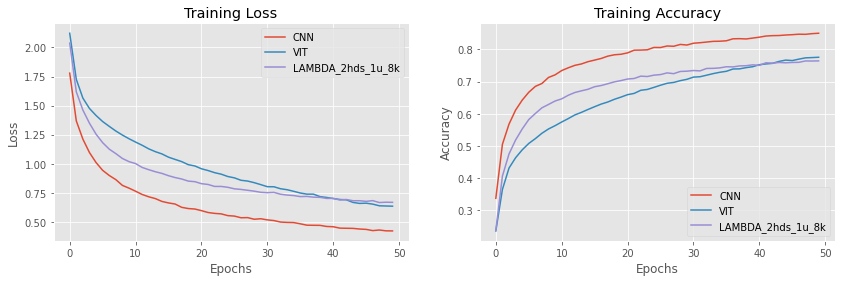

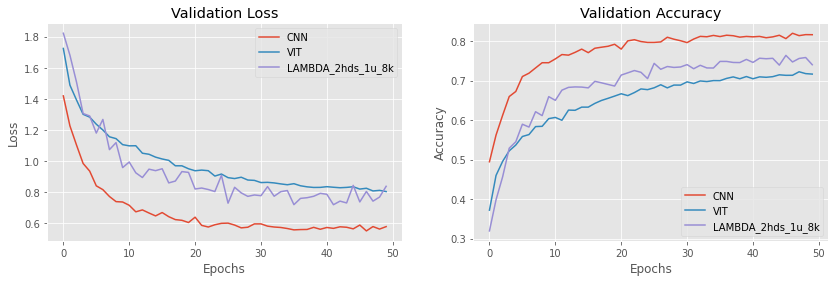

In [18]:
legends = ['CNN', 'VIT', 'LAMBDA_2hds_1u_8k']
histories = [history['CNN'], history['VIT'], history['LAMBDA'][2][1][8]]

plot([i.history['loss'] for i in histories], 
     [i.history['sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Training Loss', 'Training Accuracy'])
plot([i.history['val_loss'] for i in histories], 
     [i.history['val_sparse_categorical_accuracy'] for i in histories],
     legends,
     subplot_title=['Validation Loss', 'Validation Accuracy'])

X heads, 1 udim, Y kdim

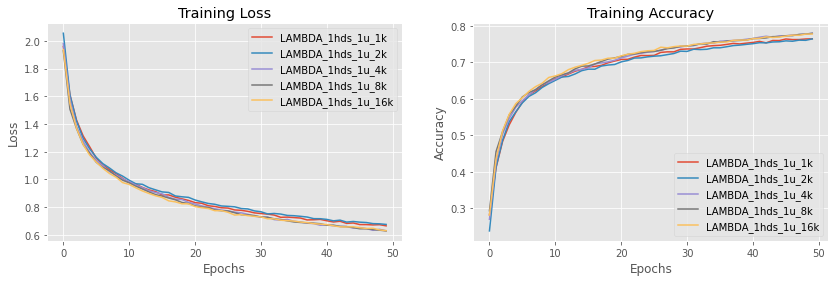

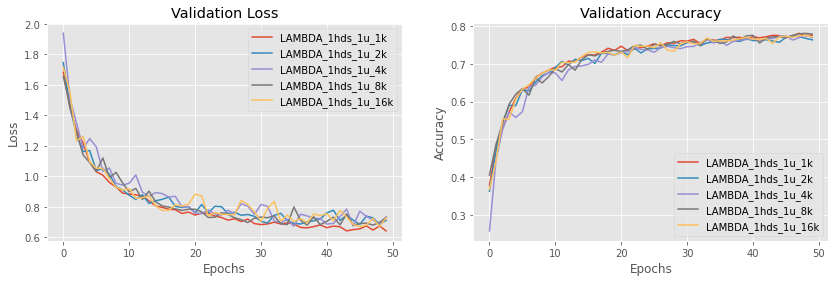

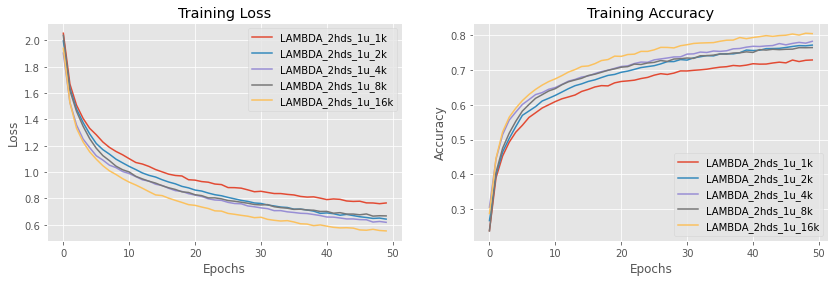

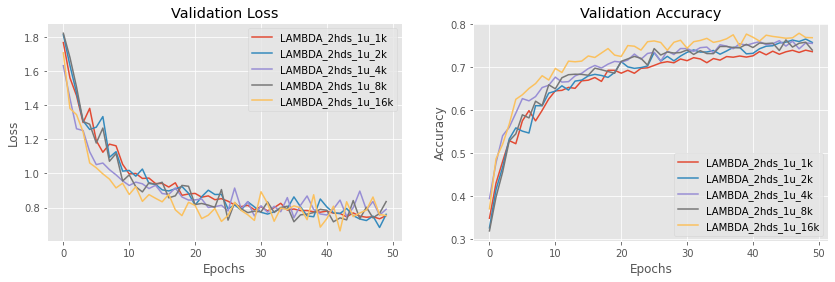

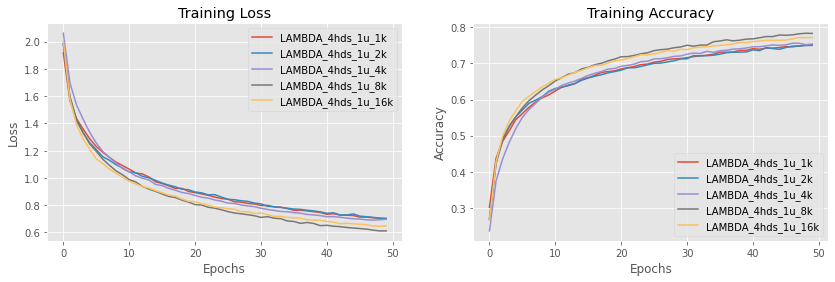

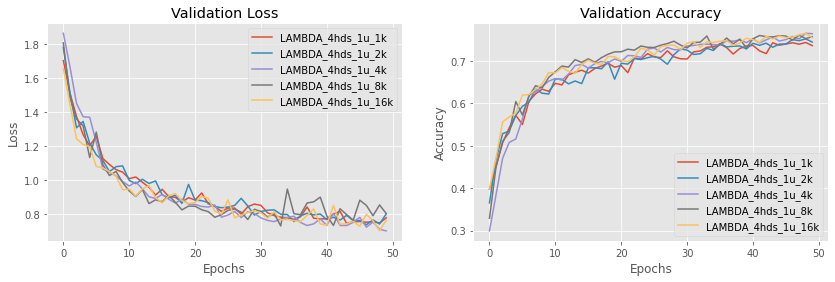

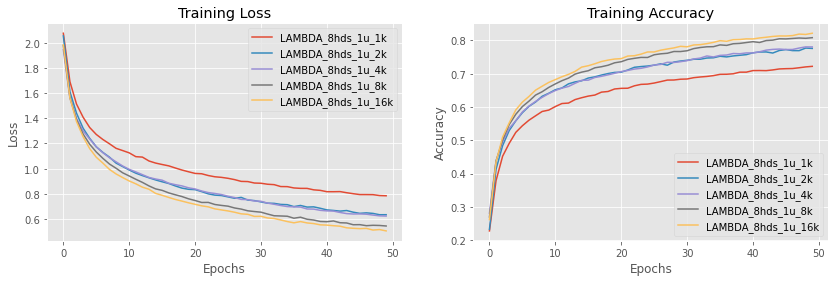

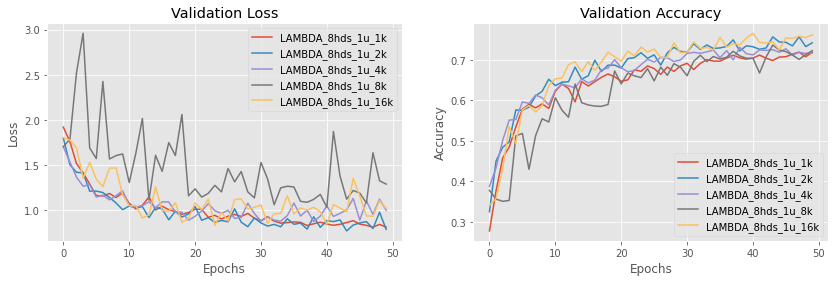

In [19]:
for hds in [1,2,4,8]:
  legends = [f'LAMBDA_{hds}hds_1u_{i}k' for i in [1,2,4,8,16]]
  histories = [history['LAMBDA'][hds][1][i] for i in [1,2,4,8,16]]

  plot([i.history['loss'] for i in histories], 
       [i.history['sparse_categorical_accuracy'] for i in histories],
       legends,
       subplot_title=['Training Loss', 'Training Accuracy'])
  plot([i.history['val_loss'] for i in histories], 
       [i.history['val_sparse_categorical_accuracy'] for i in histories],
       legends,
       subplot_title=['Validation Loss', 'Validation Accuracy'])

2 heads, X udim, Y kdim



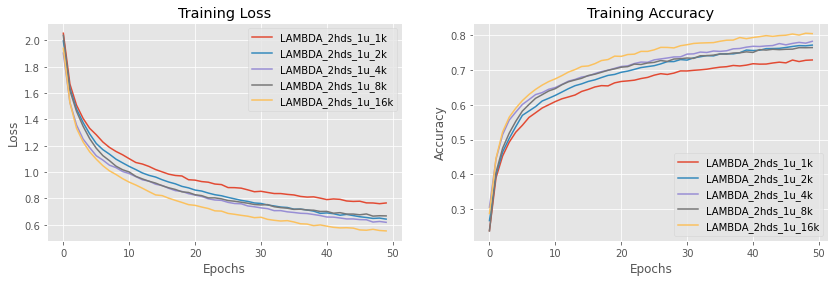

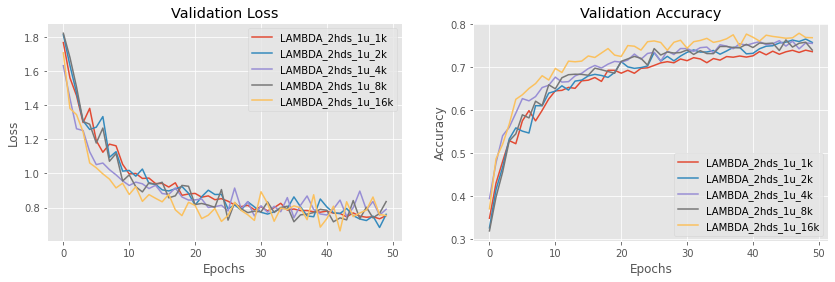

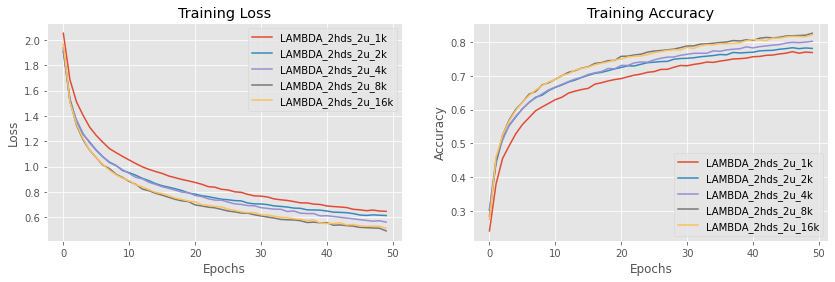

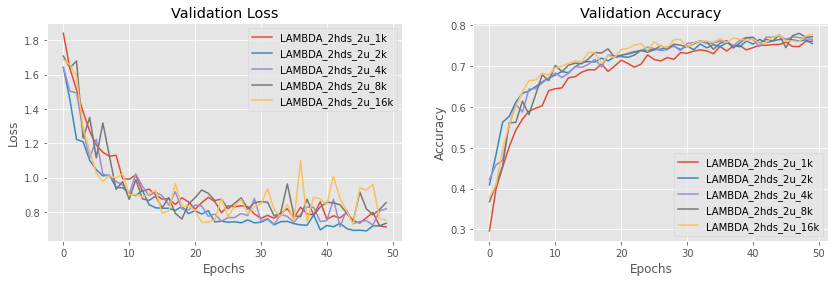

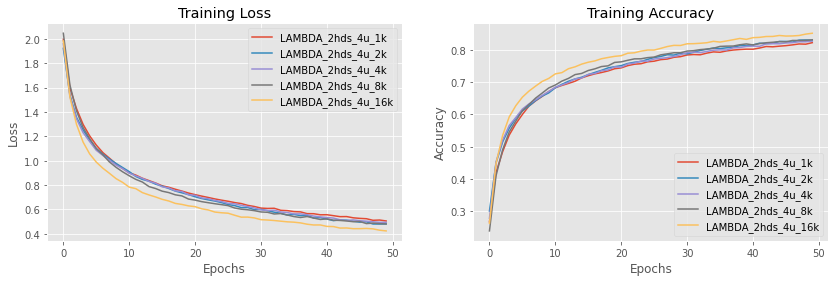

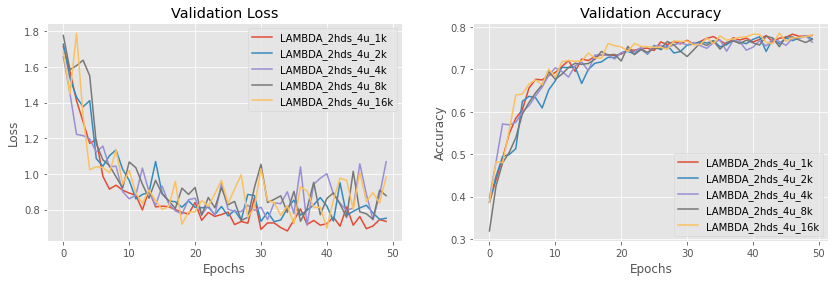

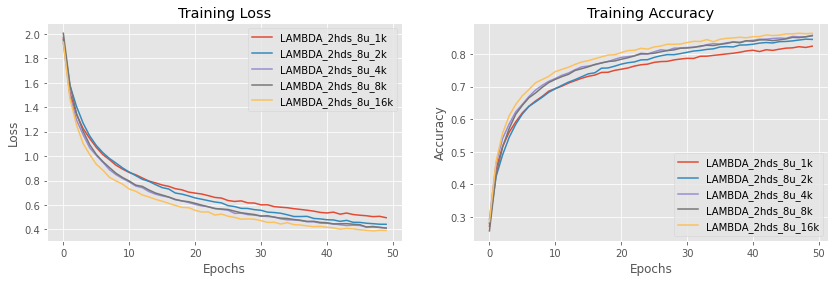

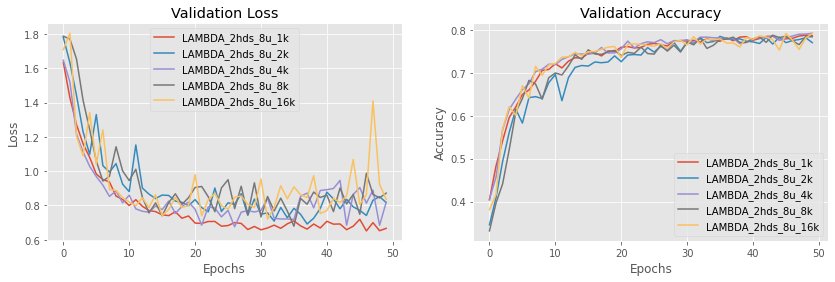

In [20]:
for u in [1,2,4,8]:
  legends = [f'LAMBDA_2hds_{u}u_{i}k' for i in [1,2,4,8,16]]
  histories = [history['LAMBDA'][2][u][i] for i in [1,2,4,8,16]]

  plot([i.history['loss'] for i in histories], 
       [i.history['sparse_categorical_accuracy'] for i in histories],
       legends,
       subplot_title=['Training Loss', 'Training Accuracy'])
  plot([i.history['val_loss'] for i in histories], 
       [i.history['val_sparse_categorical_accuracy'] for i in histories],
       legends,
       subplot_title=['Validation Loss', 'Validation Accuracy'])